In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import subprocess
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerTuple
from scipy.io import loadmat
import natsort, pathlib
import os
import glob


path1 = os.path.abspath('../numpy_files/m1/')
path2 = os.path.abspath('../numpy_files/m2/')
path3 = os.path.abspath('../numpy_files/m3/')
path4 = os.path.abspath('../numpy_files/m4/')

In [2]:
colormap_data = loadmat('cold2hot.mat')
cold2hot = ListedColormap(colormap_data['colormap'])

In [3]:
time_ms1 = np.load(path1+'/time_ms.npy')
time_ms2 = np.load(path2+'/time_ms.npy')
time_ms3 = np.load(path3+'/time_ms.npy')
time_ms4 = np.load(path4+'/time_ms.npy')

time_steps1 =  time_ms1.shape[0]
time_steps2 =  time_ms2.shape[0]
time_steps3 =  time_ms3.shape[0]
time_steps4 =  time_ms4.shape[0]

time_steps1, time_steps2, time_steps3, time_steps4

(1025, 463, 1754, 791)

#### Temperature

In [4]:
temp1 = np.load(path1+'/temp.npy')
temp2 = np.load(path2+'/temp.npy')
temp3 = np.load(path3+'/temp.npy')
temp4 = np.load(path4+'/temp.npy')

#### Area

In [5]:
area_df1 = pd.read_csv(path1+'/7.csv',  encoding='utf-8')
area_df1['area_IMC_total'] =  area_df1['area_h2']+area_df1['area_h3']+area_df1['area_h4']+area_df1['area_h5']
real_time1 = np.array(area_df1['time'])/1e4 ## turning time_scale of 1e7  to 1e3 (into ms scale)
area_df1['real_time_(ms)'] = real_time1

area_df2 = pd.read_csv(path2+'/7.csv',  encoding='utf-8')
area_df2['area_IMC_total'] =  area_df2['area_h2']+area_df2['area_h3']+area_df2['area_h4']+area_df2['area_h5']
real_time2 = np.array(area_df2['time'])/1e4 ## turning time_scale of 1e7  to 1e3 (into ms scale)
area_df2['real_time_(ms)'] = real_time2

area_df3 = pd.read_csv(path3+'/7.csv',  encoding='utf-8')
area_df3['area_IMC_total'] =  area_df3['area_h2']+area_df3['area_h3']+area_df3['area_h4']+area_df3['area_h5']
real_time3 = np.array(area_df3['time'])/1e4 ## turning time_scale of 1e7  to 1e3 (into ms scale)
area_df3['real_time_(ms)'] = real_time3

area_df4 = pd.read_csv(path4+'/7.csv',  encoding='utf-8')
area_df4['area_IMC_total'] =  area_df4['area_h2']+area_df4['area_h3']+area_df4['area_h4']+area_df4['area_h5']
real_time4 = np.array(area_df4['time'])/1e4 ## turning time_scale of 1e7  to 1e3 (into ms scale)
area_df4['real_time_(ms)'] = real_time4

#### Functions

In [6]:
def interface_y_coord(array, x_pos, endtime):
    y = []
    for t in range(endtime):
        for i in range(125): ##  80 is the height (from top) where IMC phase exists for all grains G1 to G4 
            if 0.35<=array[i,x_pos,t]<=0.65:
                y.append(i)
                break
    return np.array(y)

def temperature_calc(array, x, ypos):
    interface_temp = []
    for t, y in enumerate(ypos):
        interface_temp.append(array[y,x,t])
    return np.array(interface_temp)

# Define the function f(x, y)
def Ti(c_temp):
    c1, temp = c_temp
    factor_f1, factor_temp = 1000, 1
    return factor_f1*(14.594*(6.7*c1 - 0.68)**2 + 4.1*factor_temp*(0.0015*temp - 1.65)**2 - 6.95)

def IMC(c_temp):
    c2, temp = c_temp
    factor_f2, factor_temp = 1000, 1
    return factor_f2*(12.4802*(13.66*c2 - 3.5655)**2 + 1.9*factor_temp*(0.0034*temp - 2.921)**2 - 12.6)
    # return factor_f2*(12.4802*(13.66*c2 - 3.5655)**2 + 1.9*factor_temp*(0.0034*temp - 2.921)**2 - 11.3)
  

def Au_liq(c_temp):
    c3, temp = c_temp
    factor_f3, factor_temp = 1000, 1
    return factor_f3*(9.74*(2.8*c3 - 1.64)**2 + 3.9*factor_temp*(0.002*temp - 4.5)**2 - 12.82)
    # return factor_f3*(9.74*(2.8*c3 - 1.64)**2 + 3.9*factor_temp*(0.002*temp - 4.32)**2 - 12.82)
    # return 22*(43*(5.14*c3 - 2.75)**4 + 112*factor_temp*(0.0033*temp - 6.4)**2 -0.7*c3*temp - 21)

def Au_sol(c_temp):
    c4, temp = c_temp
    factor_f4, factor_temp = 1000, 1
    return  factor_f4*(10.34*(2.67*c4 - 1.743)**2 + 3.76*factor_temp*(0.0027*temp - 2.15)**2 - 8.5)
    # return  factor_f4*(12.48*(2.67*c4 - 1.743)**2 + 3.76*factor_temp*(0.0027*temp - 1.8837)**2 - 10.5)

def IMC_front(array, condition, end_time_step):
    front_IMC = []
    width = array.shape[1]
    for t in range(end_time_step):
        for i in range(width-1, 0, -1):
            if np.max(array[:, i-1:i, t])>condition:
                front_IMC.append(i)
                break
    return np.array(front_IMC)

def IMC_rear(array, condition, end_time_step):
    rear_IMC = []
    width = array.shape[1]
    for t in range(end_time_step):
        for i in range(width):
            if np.max(array[:, i:i+1, t])>condition:
                rear_IMC.append(i)
                break
    return np.array(rear_IMC)

#### Global Composition of Regions 

In [7]:
c_IMC = 0.261
c_LIQ = 0.586
c_FCC = 0.653

# IMC

In [8]:
IMC11 = np.load(path1+'/IMC1.npy')
IMC21 = np.load(path1+'/IMC2.npy')
IMC31 = np.load(path1+'/IMC3.npy')
IMC41 = np.load(path1+'/IMC4.npy')

IMC12 = np.load(path2+'/IMC1.npy')
IMC22 = np.load(path2+'/IMC2.npy')
IMC32 = np.load(path2+'/IMC3.npy')
IMC42 = np.load(path2+'/IMC4.npy')

IMC13 = np.load(path3+'/IMC1.npy')
IMC23 = np.load(path3+'/IMC2.npy')
IMC33 = np.load(path3+'/IMC3.npy')
IMC43 = np.load(path3+'/IMC4.npy')

IMC14 = np.load(path4+'/IMC1.npy')
IMC24 = np.load(path4+'/IMC2.npy')
IMC34 = np.load(path4+'/IMC3.npy')
IMC44 = np.load(path4+'/IMC4.npy')

### I-150 V-5  For Model 1 

In [10]:
y_pos_11 = interface_y_coord(IMC11, 43, time_steps1) # 43 -> 150*(371/1300)  ## Mid point in x axis for Grain 1
y_pos_21 = interface_y_coord(IMC21, 114, time_steps1) # 114 -> 400*(371/1300)
y_pos_31 = interface_y_coord(IMC31, 186, time_steps1) # 186 -> 650*(371/1300)
y_pos_41 = interface_y_coord(IMC41, 257, time_steps1) # 257 ->  900*(371/1300) 

len(y_pos_11), len(y_pos_21), len(y_pos_31), len(y_pos_41) 

(1025, 1025, 1025, 1025)

#### Temperature Calculation

In [11]:
M11_Temp = temperature_calc(temp1, 43, y_pos_11)
M21_Temp = temperature_calc(temp1, 114, y_pos_21)
M31_Temp = temperature_calc(temp1, 186, y_pos_31)
M41_Temp = temperature_calc(temp1, 257, y_pos_41)

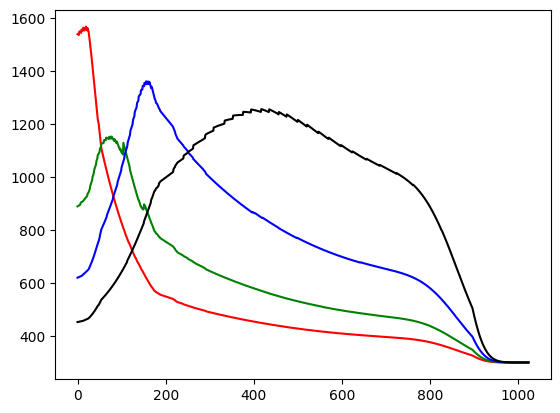

In [12]:
plt.plot(M11_Temp[1:], color='red')
plt.plot(M21_Temp[1:], color='green')
plt.plot(M31_Temp[1:], color='blue')
plt.plot(M41_Temp[1:], color='black')

#### Free Energy Calculation

In [13]:
G11_IMC, G11_FCC, G11_LIQ = IMC((c_IMC, M11_Temp[1:])), Au_sol((c_FCC, M11_Temp[1:])), Au_liq((c_LIQ, M11_Temp[1:]))
G21_IMC, G21_FCC, G21_LIQ = IMC((c_IMC, M21_Temp[1:])), Au_sol((c_FCC, M21_Temp[1:])), Au_liq((c_LIQ, M21_Temp[1:]))
G31_IMC, G31_FCC, G31_LIQ = IMC((c_IMC, M31_Temp[1:])), Au_sol((c_FCC, M31_Temp[1:])), Au_liq((c_LIQ, M31_Temp[1:]))
G41_IMC, G41_FCC, G41_LIQ = IMC((c_IMC, M41_Temp[1:])), Au_sol((c_FCC, M41_Temp[1:])), Au_liq((c_LIQ, M41_Temp[1:]))

Text(0.5, 1.0, 'Model 1 Grain 4 Interface')

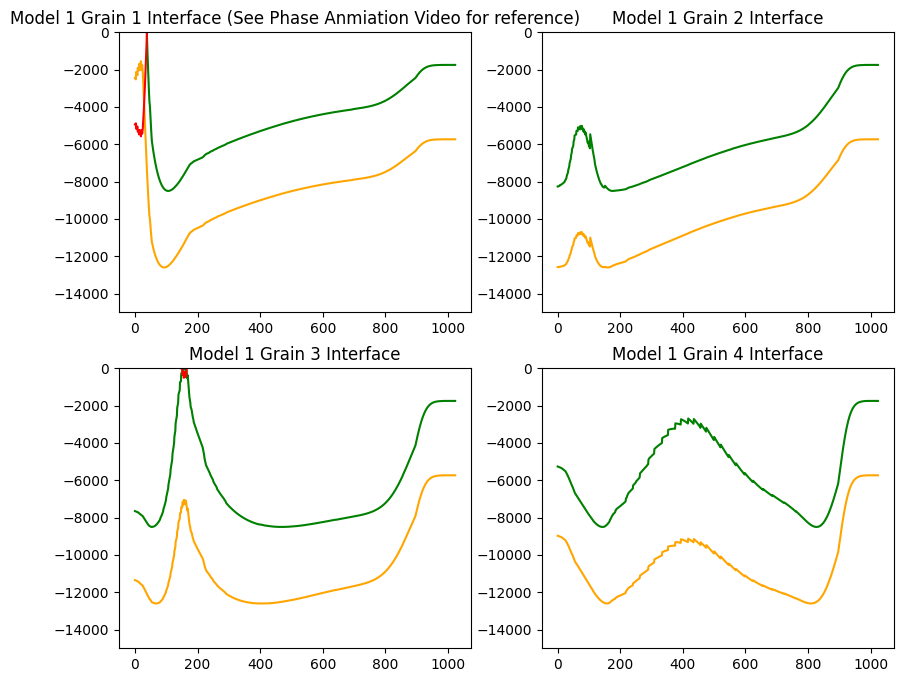

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,8), frameon=True)

ax1.plot(G11_IMC, color='orange')
ax1.plot(G11_FCC, color='green')
ax1.plot(G11_LIQ, color='red')
ax1.set_ylim(-15000, 0)
ax1.set_title('Model 1 Grain 1 Interface (See Phase Anmiation Video for reference)')

ax2.plot(G21_IMC, color='orange')
ax2.plot(G21_FCC, color='green')
ax2.plot(G21_LIQ, color='red')
ax2.set_ylim(-15000, 0)
ax2.set_title('Model 1 Grain 2 Interface')

ax3.plot(G31_IMC, color='orange')
ax3.plot(G31_FCC, color='green')
ax3.plot(G31_LIQ, color='red')
ax3.set_ylim(-15000, 0)
ax3.set_title('Model 1 Grain 3 Interface')

ax4.plot(G41_IMC, color='orange')
ax4.plot(G41_FCC, color='green')
ax4.plot(G41_LIQ, color='red')
ax4.set_ylim(-15000, 0)
ax4.set_title('Model 1 Grain 4 Interface')

### I-134.6 V-5   For Model 2

In [15]:
y_pos_12 = interface_y_coord(IMC12, 43, time_steps2) # 43 -> 150*(371/1300)  ## Mid point in x axis for Grain 1
y_pos_22 = interface_y_coord(IMC22, 114, time_steps2) # 114 -> 400*(371/1300)
y_pos_32 = interface_y_coord(IMC32, 186, time_steps2) # 186 -> 650*(371/1300)
y_pos_42 = interface_y_coord(IMC42, 257, time_steps2) # 257 ->  900*(371/1300) 

len(y_pos_12), len(y_pos_22), len(y_pos_32), len(y_pos_42) 

(463, 463, 463, 463)

#### Temperature Calculation

In [16]:
M12_Temp = temperature_calc(temp2, 43, y_pos_12)
M22_Temp = temperature_calc(temp2, 114, y_pos_22)
M32_Temp = temperature_calc(temp2, 186, y_pos_32)
M42_Temp = temperature_calc(temp2, 257, y_pos_42)

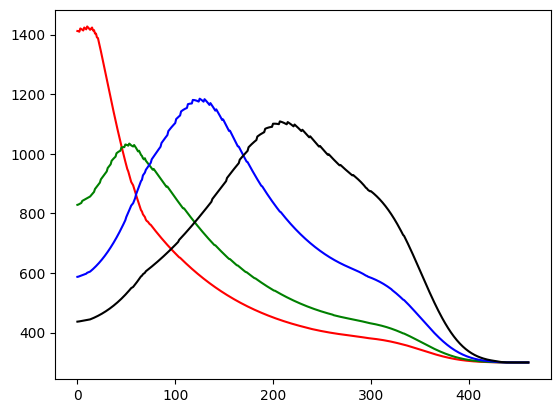

In [17]:
plt.plot(M12_Temp[1:], color='red')
plt.plot(M22_Temp[1:], color='green')
plt.plot(M32_Temp[1:], color='blue')
plt.plot(M42_Temp[1:], color='black')

#### Free Energy Calculation

In [18]:
G12_IMC, G12_FCC, G12_LIQ = IMC((c_IMC, M12_Temp[1:])), Au_sol((c_FCC, M12_Temp[1:])), Au_liq((c_LIQ, M12_Temp[1:]))
G22_IMC, G22_FCC, G22_LIQ = IMC((c_IMC, M22_Temp[1:])), Au_sol((c_FCC, M22_Temp[1:])), Au_liq((c_LIQ, M22_Temp[1:]))
G32_IMC, G32_FCC, G32_LIQ = IMC((c_IMC, M32_Temp[1:])), Au_sol((c_FCC, M32_Temp[1:])), Au_liq((c_LIQ, M32_Temp[1:]))
G42_IMC, G42_FCC, G42_LIQ = IMC((c_IMC, M42_Temp[1:])), Au_sol((c_FCC, M42_Temp[1:])), Au_liq((c_LIQ, M42_Temp[1:]))

Text(0.5, 1.0, 'Model 2 Grain 4 Interface')

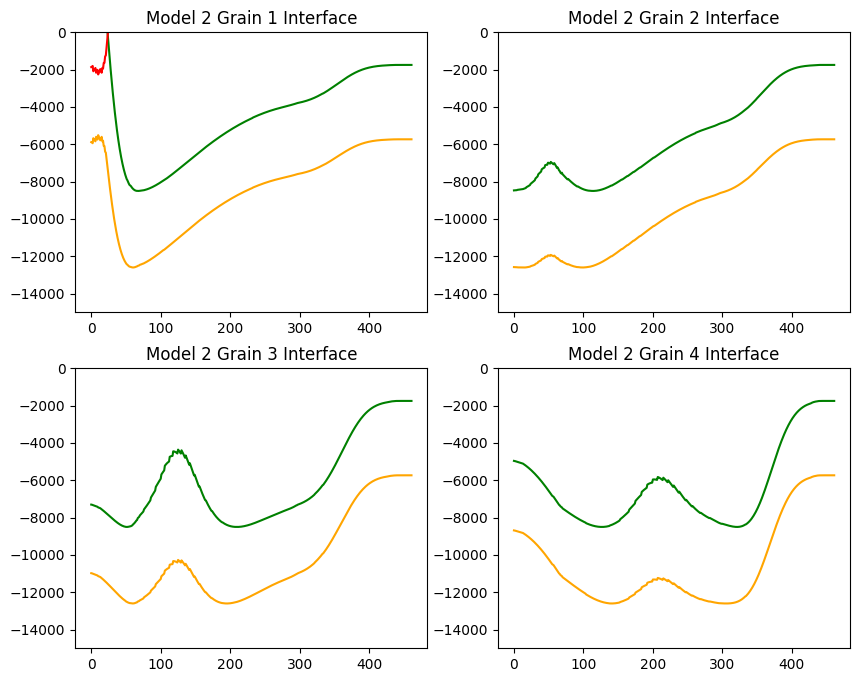

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,8), frameon=True)

ax1.plot(G12_IMC, color='orange')
ax1.plot(G12_FCC, color='green')
ax1.plot(G12_LIQ, color='red')
ax1.set_ylim(-15000, 0)
ax1.set_title('Model 2 Grain 1 Interface')

ax2.plot(G22_IMC, color='orange')
ax2.plot(G22_FCC, color='green')
ax2.plot(G22_LIQ, color='red')
ax2.set_ylim(-15000, 0)
ax2.set_title('Model 2 Grain 2 Interface')

ax3.plot(G32_IMC, color='orange')
ax3.plot(G32_FCC, color='green')
ax3.plot(G32_LIQ, color='red')
ax3.set_ylim(-15000, 0)
ax3.set_title('Model 2 Grain 3 Interface')

ax4.plot(G42_IMC, color='orange')
ax4.plot(G42_FCC, color='green')
ax4.plot(G42_LIQ, color='red')
ax4.set_ylim(-15000, 0)
ax4.set_title('Model 2 Grain 4 Interface')

### I-150 V-4   For Model 3

In [20]:
y_pos_13 = interface_y_coord(IMC13, 43, time_steps3) # 43 -> 150*(371/1300)  ## Mid point in x axis for Grain 1
y_pos_23 = interface_y_coord(IMC23, 114, time_steps3) # 114 -> 400*(371/1300)
y_pos_33 = interface_y_coord(IMC33, 186, time_steps3) # 186 -> 650*(371/1300)
y_pos_43 = interface_y_coord(IMC43, 257, time_steps3) # 257 ->  900*(371/1300) 

len(y_pos_13), len(y_pos_23), len(y_pos_33), len(y_pos_43) 

(1754, 1754, 1754, 1754)

#### Temperature Calculation

In [21]:
M13_Temp = temperature_calc(temp3, 43, y_pos_13)
M23_Temp = temperature_calc(temp3, 114, y_pos_23)
M33_Temp = temperature_calc(temp3, 186, y_pos_33)
M43_Temp = temperature_calc(temp3, 257, y_pos_43)

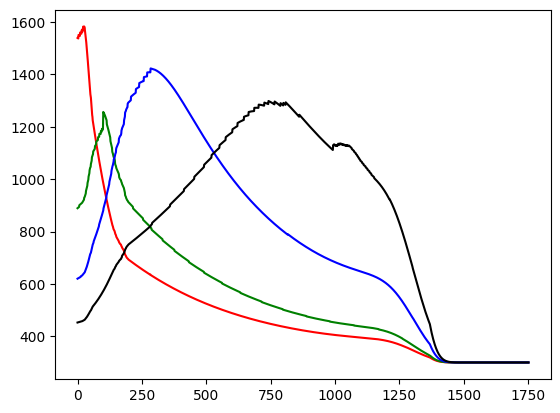

In [22]:
plt.plot(M13_Temp[1:], color='red')
plt.plot(M23_Temp[1:], color='green')
plt.plot(M33_Temp[1:], color='blue')
plt.plot(M43_Temp[1:], color='black')

#### Free Energy Calculation

In [23]:
G13_IMC, G13_FCC, G13_LIQ = IMC((c_IMC, M13_Temp[1:])), Au_sol((c_FCC, M13_Temp[1:])), Au_liq((c_LIQ, M13_Temp[1:]))
G23_IMC, G23_FCC, G23_LIQ = IMC((c_IMC, M23_Temp[1:])), Au_sol((c_FCC, M23_Temp[1:])), Au_liq((c_LIQ, M23_Temp[1:]))
G33_IMC, G33_FCC, G33_LIQ = IMC((c_IMC, M33_Temp[1:])), Au_sol((c_FCC, M33_Temp[1:])), Au_liq((c_LIQ, M33_Temp[1:]))
G43_IMC, G43_FCC, G43_LIQ = IMC((c_IMC, M43_Temp[1:])), Au_sol((c_FCC, M43_Temp[1:])), Au_liq((c_LIQ, M43_Temp[1:]))

Text(0.5, 1.0, 'Model 3 Grain 4 Interface')

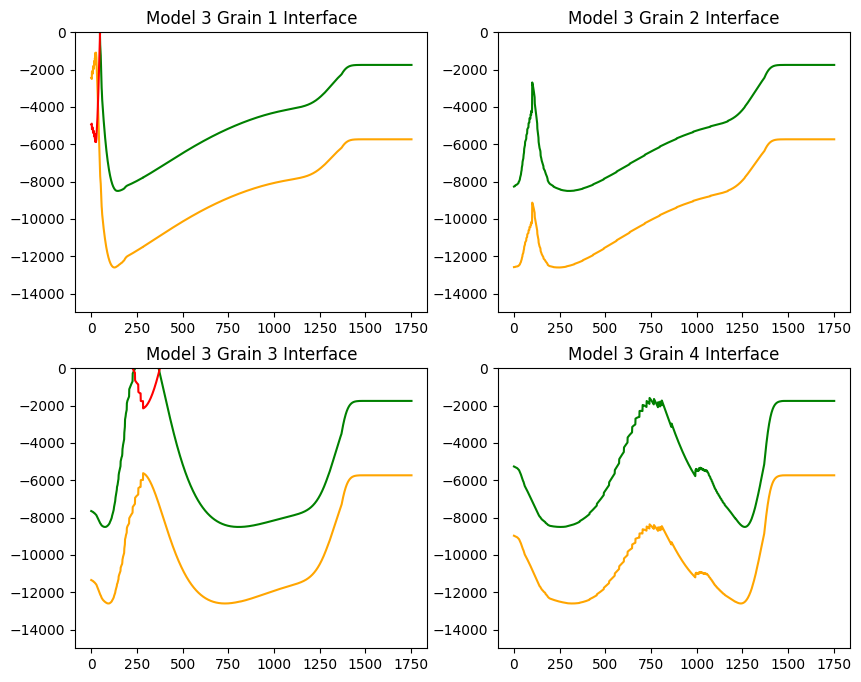

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,8), frameon=True)

ax1.plot(G13_IMC, color='orange')
ax1.plot(G13_FCC, color='green')
ax1.plot(G13_LIQ, color='red')
ax1.set_ylim(-15000, 0)
ax1.set_title('Model 3 Grain 1 Interface')

ax2.plot(G23_IMC, color='orange')
ax2.plot(G23_FCC, color='green')
ax2.plot(G23_LIQ, color='red')
ax2.set_ylim(-15000, 0)
ax2.set_title('Model 3 Grain 2 Interface')

ax3.plot(G33_IMC, color='orange')
ax3.plot(G33_FCC, color='green')
ax3.plot(G33_LIQ, color='red')
ax3.set_ylim(-15000, 0)
ax3.set_title('Model 3 Grain 3 Interface')

ax4.plot(G43_IMC, color='orange')
ax4.plot(G43_FCC, color='green')
ax4.plot(G43_LIQ, color='red')
ax4.set_ylim(-15000, 0)
ax4.set_title('Model 3 Grain 4 Interface')

### I-134.6 V-4   For Model 4

In [25]:
y_pos_14 = interface_y_coord(IMC14, 43, time_steps4) # 43 -> 150*(371/1300)  ## Mid point in x axis for Grain 1
y_pos_24 = interface_y_coord(IMC24, 114, time_steps4) # 114 -> 400*(371/1300)
y_pos_34 = interface_y_coord(IMC34, 186, time_steps4) # 186 -> 650*(371/1300)
y_pos_44 = interface_y_coord(IMC44, 257, time_steps4) # 257 ->  900*(371/1300) 

len(y_pos_14), len(y_pos_24), len(y_pos_34), len(y_pos_44) 

(791, 791, 791, 791)

#### Temperature Calculation

In [26]:
M14_Temp = temperature_calc(temp4, 43, y_pos_14)
M24_Temp = temperature_calc(temp4, 114, y_pos_24)
M34_Temp = temperature_calc(temp4, 186, y_pos_34)
M44_Temp = temperature_calc(temp4, 257, y_pos_44)

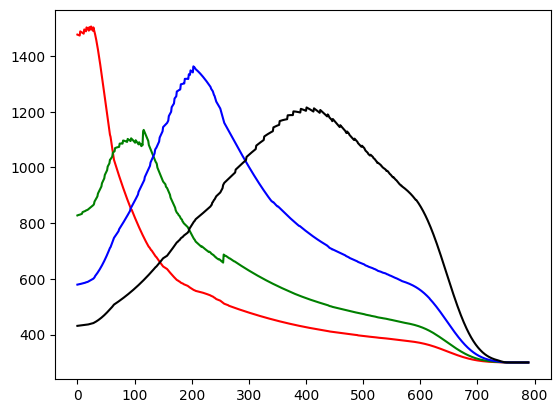

In [27]:
plt.plot(M14_Temp[1:], color='red')
plt.plot(M24_Temp[1:], color='green')
plt.plot(M34_Temp[1:], color='blue')
plt.plot(M44_Temp[1:], color='black')

#### Free Energy Calculation

In [28]:
G14_IMC, G14_FCC, G14_LIQ = IMC((c_IMC, M14_Temp[1:])), Au_sol((c_FCC, M14_Temp[1:])), Au_liq((c_LIQ, M14_Temp[1:]))
G24_IMC, G24_FCC, G24_LIQ = IMC((c_IMC, M24_Temp[1:])), Au_sol((c_FCC, M24_Temp[1:])), Au_liq((c_LIQ, M24_Temp[1:]))
G34_IMC, G34_FCC, G34_LIQ = IMC((c_IMC, M34_Temp[1:])), Au_sol((c_FCC, M34_Temp[1:])), Au_liq((c_LIQ, M34_Temp[1:]))
G44_IMC, G44_FCC, G44_LIQ = IMC((c_IMC, M44_Temp[1:])), Au_sol((c_FCC, M44_Temp[1:])), Au_liq((c_LIQ, M44_Temp[1:]))

Text(0.5, 1.0, 'Model 4 Grain 4 Interface')

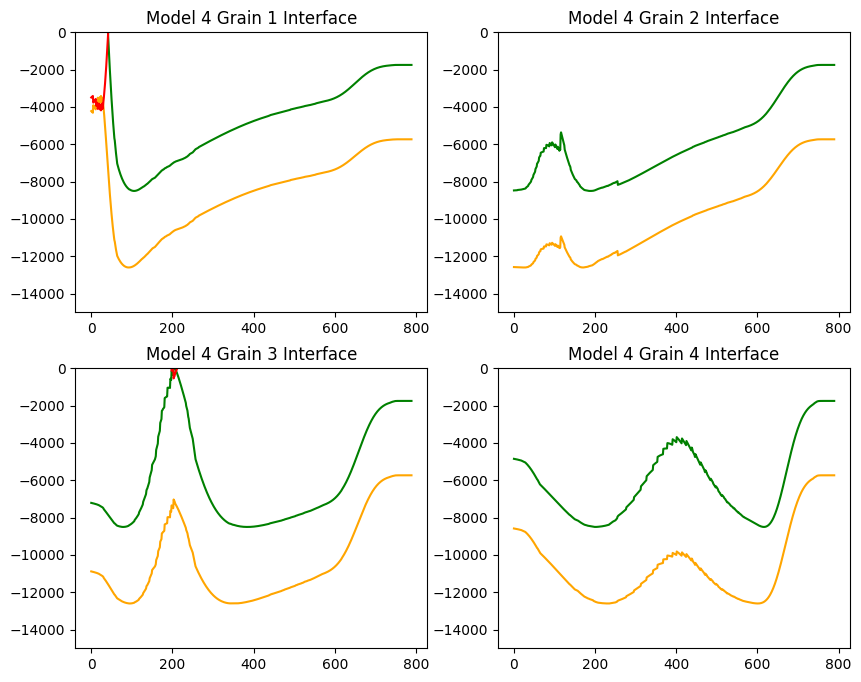

In [29]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,8), frameon=True)

ax1.plot(G14_IMC, color='orange')
ax1.plot(G14_FCC, color='green')
ax1.plot(G14_LIQ, color='red')
ax1.set_ylim(-15000, 0)
ax1.set_title('Model 4 Grain 1 Interface')

ax2.plot(G24_IMC, color='orange')
ax2.plot(G24_FCC, color='green')
ax2.plot(G24_LIQ, color='red')
ax2.set_ylim(-15000, 0)
ax2.set_title('Model 4 Grain 2 Interface')

ax3.plot(G34_IMC, color='orange')
ax3.plot(G34_FCC, color='green')
ax3.plot(G34_LIQ, color='red')
ax3.set_ylim(-15000, 0)
ax3.set_title('Model 4 Grain 3 Interface')

ax4.plot(G44_IMC, color='orange')
ax4.plot(G44_FCC, color='green')
ax4.plot(G44_LIQ, color='red')
ax4.set_ylim(-15000, 0)
ax4.set_title('Model 4 Grain 4 Interface')

## For IMC

In [9]:
y_pos_11 = interface_y_coord(IMC11, 43, time_steps1) # 43 -> 150*(371/1300)  ## Mid point in x axis for Grain 1
y_pos_21 = interface_y_coord(IMC21, 114, time_steps1) # 114 -> 400*(371/1300)
y_pos_31 = interface_y_coord(IMC31, 186, time_steps1) # 186 -> 650*(371/1300)
y_pos_41 = interface_y_coord(IMC41, 257, time_steps1) # 257 ->  900*(371/1300) 

M11_Temp = temperature_calc(temp1, 43, y_pos_11)
M21_Temp = temperature_calc(temp1, 114, y_pos_21)
M31_Temp = temperature_calc(temp1, 186, y_pos_31)
M41_Temp = temperature_calc(temp1, 257, y_pos_41)

G11_IMC, G11_FCC, G11_LIQ = IMC((c_IMC, M11_Temp[1:])), Au_sol((c_FCC, M11_Temp[1:])), Au_liq((c_LIQ, M11_Temp[1:]))
G21_IMC, G21_FCC, G21_LIQ = IMC((c_IMC, M21_Temp[1:])), Au_sol((c_FCC, M21_Temp[1:])), Au_liq((c_LIQ, M21_Temp[1:]))
G31_IMC, G31_FCC, G31_LIQ = IMC((c_IMC, M31_Temp[1:])), Au_sol((c_FCC, M31_Temp[1:])), Au_liq((c_LIQ, M31_Temp[1:]))
G41_IMC, G41_FCC, G41_LIQ = IMC((c_IMC, M41_Temp[1:])), Au_sol((c_FCC, M41_Temp[1:])), Au_liq((c_LIQ, M41_Temp[1:]))

In [10]:
y_pos_12 = interface_y_coord(IMC12, 43, time_steps2) # 43 -> 150*(371/1300)  ## Mid point in x axis for Grain 1
y_pos_22 = interface_y_coord(IMC22, 114, time_steps2) # 114 -> 400*(371/1300)
y_pos_32 = interface_y_coord(IMC32, 186, time_steps2) # 186 -> 650*(371/1300)
y_pos_42 = interface_y_coord(IMC42, 257, time_steps2) # 257 ->  900*(371/1300) 

M12_Temp = temperature_calc(temp2, 43, y_pos_12)
M22_Temp = temperature_calc(temp2, 114, y_pos_22)
M32_Temp = temperature_calc(temp2, 186, y_pos_32)
M42_Temp = temperature_calc(temp2, 257, y_pos_42)

G12_IMC, G12_FCC, G12_LIQ = IMC((c_IMC, M12_Temp[1:])), Au_sol((c_FCC, M12_Temp[1:])), Au_liq((c_LIQ, M12_Temp[1:]))
G22_IMC, G22_FCC, G22_LIQ = IMC((c_IMC, M22_Temp[1:])), Au_sol((c_FCC, M22_Temp[1:])), Au_liq((c_LIQ, M22_Temp[1:]))
G32_IMC, G32_FCC, G32_LIQ = IMC((c_IMC, M32_Temp[1:])), Au_sol((c_FCC, M32_Temp[1:])), Au_liq((c_LIQ, M32_Temp[1:]))
G42_IMC, G42_FCC, G42_LIQ = IMC((c_IMC, M42_Temp[1:])), Au_sol((c_FCC, M42_Temp[1:])), Au_liq((c_LIQ, M42_Temp[1:]))

In [11]:
y_pos_13 = interface_y_coord(IMC13, 43, time_steps3) # 43 -> 150*(371/1300)  ## Mid point in x axis for Grain 1
y_pos_23 = interface_y_coord(IMC23, 114, time_steps3) # 114 -> 400*(371/1300)
y_pos_33 = interface_y_coord(IMC33, 186, time_steps3) # 186 -> 650*(371/1300)
y_pos_43 = interface_y_coord(IMC43, 257, time_steps3) # 257 ->  900*(371/1300) 

M13_Temp = temperature_calc(temp3, 43, y_pos_13)
M23_Temp = temperature_calc(temp3, 114, y_pos_23)
M33_Temp = temperature_calc(temp3, 186, y_pos_33)
M43_Temp = temperature_calc(temp3, 257, y_pos_43)

G13_IMC, G13_FCC, G13_LIQ = IMC((c_IMC, M13_Temp[1:])), Au_sol((c_FCC, M13_Temp[1:])), Au_liq((c_LIQ, M13_Temp[1:]))
G23_IMC, G23_FCC, G23_LIQ = IMC((c_IMC, M23_Temp[1:])), Au_sol((c_FCC, M23_Temp[1:])), Au_liq((c_LIQ, M23_Temp[1:]))
G33_IMC, G33_FCC, G33_LIQ = IMC((c_IMC, M33_Temp[1:])), Au_sol((c_FCC, M33_Temp[1:])), Au_liq((c_LIQ, M33_Temp[1:]))
G43_IMC, G43_FCC, G43_LIQ = IMC((c_IMC, M43_Temp[1:])), Au_sol((c_FCC, M43_Temp[1:])), Au_liq((c_LIQ, M43_Temp[1:]))

In [12]:
y_pos_14 = interface_y_coord(IMC14, 43, time_steps4) # 43 -> 150*(371/1300)  ## Mid point in x axis for Grain 1
y_pos_24 = interface_y_coord(IMC24, 114, time_steps4) # 114 -> 400*(371/1300)
y_pos_34 = interface_y_coord(IMC34, 186, time_steps4) # 186 -> 650*(371/1300)
y_pos_44 = interface_y_coord(IMC44, 257, time_steps4) # 257 ->  900*(371/1300) 

M14_Temp = temperature_calc(temp4, 43, y_pos_14)
M24_Temp = temperature_calc(temp4, 114, y_pos_24)
M34_Temp = temperature_calc(temp4, 186, y_pos_34)
M44_Temp = temperature_calc(temp4, 257, y_pos_44)

G14_IMC, G14_FCC, G14_LIQ = IMC((c_IMC, M14_Temp[1:])), Au_sol((c_FCC, M14_Temp[1:])), Au_liq((c_LIQ, M14_Temp[1:]))
G24_IMC, G24_FCC, G24_LIQ = IMC((c_IMC, M24_Temp[1:])), Au_sol((c_FCC, M24_Temp[1:])), Au_liq((c_LIQ, M24_Temp[1:]))
G34_IMC, G34_FCC, G34_LIQ = IMC((c_IMC, M34_Temp[1:])), Au_sol((c_FCC, M34_Temp[1:])), Au_liq((c_LIQ, M34_Temp[1:]))
G44_IMC, G44_FCC, G44_LIQ = IMC((c_IMC, M44_Temp[1:])), Au_sol((c_FCC, M44_Temp[1:])), Au_liq((c_LIQ, M44_Temp[1:]))

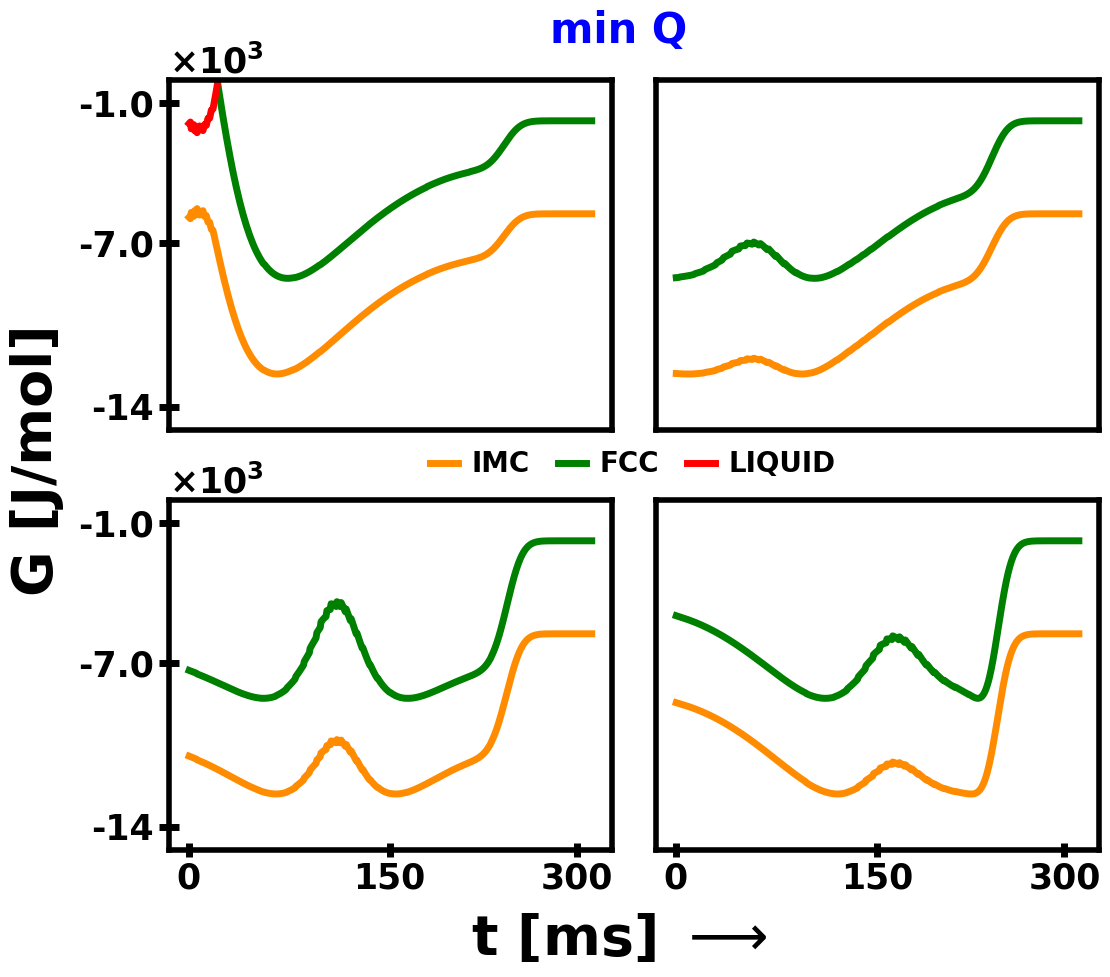

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,10), frameon=False)
ax1.set_facecolor((0, 0, 0, 0))
ax2.set_facecolor((0, 0, 0, 0))
ax3.set_facecolor((0, 0, 0, 0))
ax4.set_facecolor((0, 0, 0, 0))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.2)

ax1.plot(time_ms2[1:], G12_IMC, color='darkorange', linewidth=5, label='IMC')
ax1.plot(time_ms2[1:], G12_FCC, color='green', linewidth=5, label='FCC')
ax1.plot(time_ms2[1:], G12_LIQ, color='red', linewidth=5, label='LIQUID')
ax1.set_ylim(-15000, 0)
# ax1.set_title(r'G$_1$', fontsize=30, weight='bold')
ax1.tick_params(axis='x', labelcolor='black', labelsize=30, bottom=False, top=False, labelbottom=False)
ax1.set_yticks([-1000, -7000, -14000], labels=['-1.0', '-7.0', '-14'], size=25, color='k', weight='bold' )
ax1.set_title(r'$\mathbf{\times10^3}$', pad=0, loc='left', color='black', fontsize=25, weight='bold')
ax1.legend(loc=(0.565, -0.17), ncol=3, framealpha=0,  columnspacing=1.0, prop={'weight':'bold', 'size':'20',}, 
           handletextpad=0.5, handlelength=1.0,   frameon=True)#.get_frame().set_facecolor('none')


ax2.plot(time_ms2[1:], G22_IMC, color='darkorange', linewidth=5, label='IMC')
ax2.plot(time_ms2[1:], G22_FCC, color='green', linewidth=5, label='FCC')
ax2.plot(time_ms2[1:], G22_LIQ, color='red', linewidth=5, label='LIQUID')
ax2.set_ylim(-15000, 0)
# ax2.set_title(r'G$_2$', fontsize=30, weight='bold')
ax2.tick_params(axis='x', labelcolor='black', labelsize=30, bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', labelcolor='black', labelsize=30, left=False, right=False, labelleft=False)


ax3.plot(time_ms2[1:], G32_IMC, color='darkorange', linewidth=5, label='IMC')
ax3.plot(time_ms2[1:], G32_FCC, color='green', linewidth=5, label='FCC')
ax3.plot(time_ms2[1:], G32_LIQ, color='red', linewidth=5, label='LIQUID')
ax3.set_ylim(-15000, 0)
# ax3.set_title(r'G$_3$', fontsize=30, weight='bold')
ax3.set_yticks([-1000, -7000, -14000], labels=['-1.0', '-7.0', '-14'], size=25, color='k', weight='bold' )
ax3.set_xticks([0, 150, 290], labels=['0', '150', '300'], size=25, color='k', weight='bold')
ax3.set_title(r'$\mathbf{\times10^3}$', pad=0, loc='left', color='black', fontsize=25, weight='bold')

ax4.plot(time_ms2[1:], G42_IMC, color='darkorange', linewidth=5, label='IMC')
ax4.plot(time_ms2[1:], G42_FCC, color='green', linewidth=5, label='FCC')
ax4.plot(time_ms2[1:], G42_LIQ, color='red', linewidth=5, label='LIQUID')
ax4.set_ylim(-15000, 0)
# ax4.set_title(r'G$_4$', fontsize=30, weight='bold')
ax4.set_xticks([0, 150, 290], labels=['0', '150', '300'], size=25, color='k', weight='bold')
ax4.tick_params(axis='y', labelcolor='black', labelsize=30, left=False, right=False, labelleft=False)

main_title = plt.suptitle(r'min Q', y=0.95, fontsize=30, weight='bold', color='blue')


fig.text(0.5, 0.02, r't [ms] $\longrightarrow$', ha='center', va='center', fontsize=40, weight='bold')
fig.text(0.015, 0.5, r'G [J/mol]', ha='center', va='center', rotation='vertical', fontsize=40, weight='bold')

ax1.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax3.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax3.tick_params(axis='x', direction='inout', which='both', length=10, width=5)
ax4.tick_params(axis='x', direction='inout', which='both', length=10, width=5)

ax1.spines[:].set_linewidth(4)
ax2.spines[:].set_linewidth(4)
ax3.spines[:].set_linewidth(4)
ax4.spines[:].set_linewidth(4)

# plt.savefig('for_manuscript/T_u/F5/jpg/a.jpg', bbox_inches='tight')
# plt.savefig('for_manuscript/T_u/F5/a.png', bbox_inches='tight', dpi=800)

plt.show()

In [108]:
G12_LIQ[24], time_ms2[25]

(-31.363168282368292, 21.875)

In [75]:
G13_IMC.shape, time_ms3.shape

((1753,), (1754,))

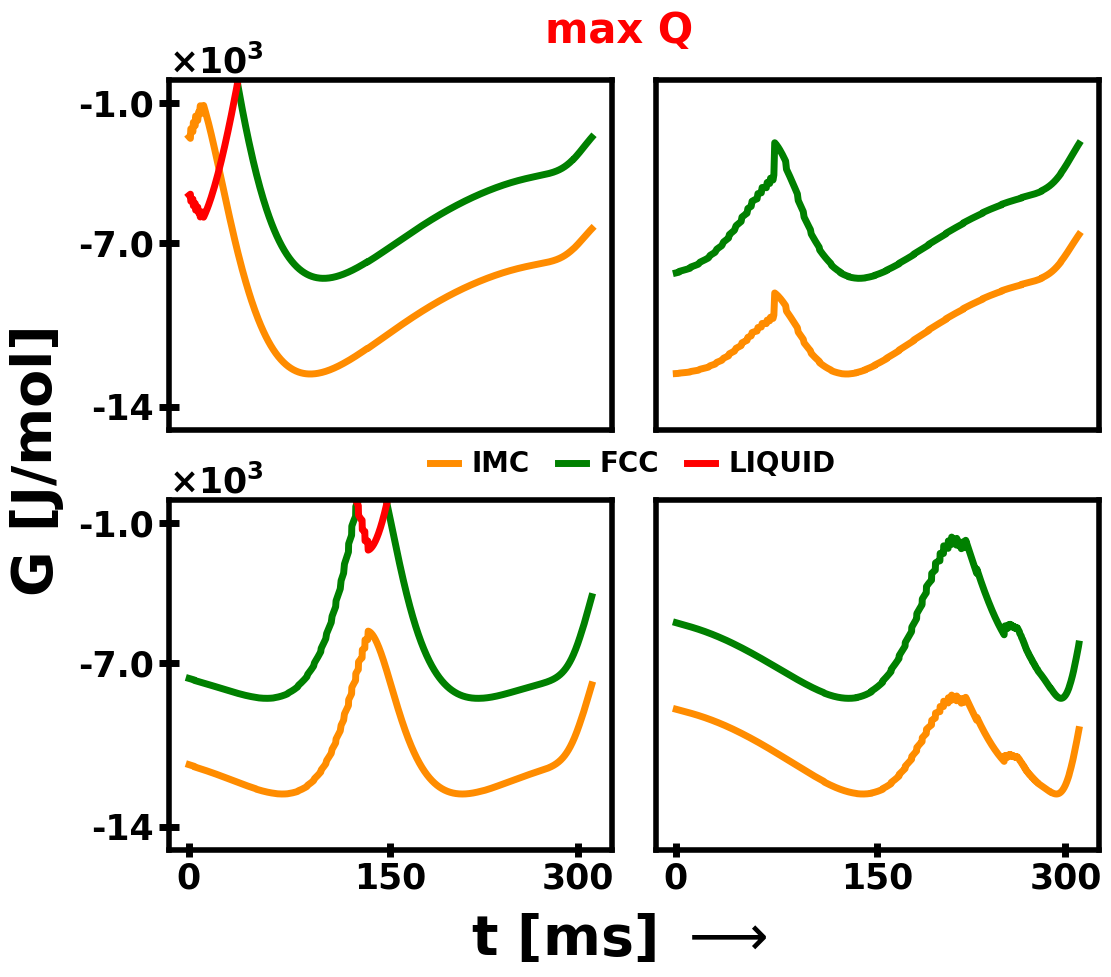

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,10), frameon=False)
ax1.set_facecolor((0, 0, 0, 0))
ax2.set_facecolor((0, 0, 0, 0))
ax3.set_facecolor((0, 0, 0, 0))
ax4.set_facecolor((0, 0, 0, 0))

t_300ms = 1350

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.2)

ax1.plot(time_ms3[1:1350], G13_IMC[:1349], color='darkorange', linewidth=5, label='IMC')
ax1.plot(time_ms3[1:1350], G13_FCC[:1349], color='green', linewidth=5, label='FCC')
ax1.plot(time_ms3[1:1350], G13_LIQ[:1349], color='red', linewidth=5, label='LIQUID')
ax1.set_ylim(-15000, 0)
# ax1.set_title(r'G$_1$', fontsize=30, weight='bold')
ax1.tick_params(axis='x', labelcolor='black', labelsize=30, bottom=False, top=False, labelbottom=False)
ax1.set_yticks([-1000, -7000, -14000], labels=['-1.0', '-7.0', '-14'], size=25, color='k', weight='bold' )
ax1.set_title(r'$\mathbf{\times10^3}$', pad=0, loc='left', color='black', fontsize=25, weight='bold')
ax1.legend(loc=(0.565, -0.17), ncol=3, framealpha=0,  columnspacing=1.0, prop={'weight':'bold', 'size':'20',}, 
           handletextpad=0.5, handlelength=1.0,   frameon=True)#.get_frame().set_facecolor('none')

ax2.plot(time_ms3[1:1350], G23_IMC[:1349], color='darkorange', linewidth=5, label='IMC')
ax2.plot(time_ms3[1:1350], G23_FCC[:1349], color='green', linewidth=5, label='FCC')
ax2.plot(time_ms3[1:1350], G23_LIQ[:1349], color='red', linewidth=5, label='LIQUID')
ax2.set_ylim(-15000, 0)
# ax2.set_title(r'G$_2$', fontsize=30, weight='bold')
ax2.tick_params(axis='x', labelcolor='black', labelsize=30, bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', labelcolor='black', labelsize=30, left=False, right=False, labelleft=False)


ax3.plot(time_ms3[1:1350], G33_IMC[:1349], color='darkorange', linewidth=5, label='IMC')
ax3.plot(time_ms3[1:1350], G33_FCC[:1349], color='green', linewidth=5, label='FCC')
ax3.plot(time_ms3[1:1350], G33_LIQ[:1349], color='red', linewidth=5, label='LIQUID')
ax3.set_ylim(-15000, 0)
# ax3.set_title(r'G$_3$', fontsize=30, weight='bold')
ax3.set_yticks([-1000, -7000, -14000], labels=['-1.0', '-7.0', '-14'], size=25, color='k', weight='bold' )
ax3.set_xticks([0, 150, 290], labels=['0', '150', '300'], size=25, color='k', weight='bold')
ax3.set_title(r'$\mathbf{\times10^3}$', pad=0, loc='left', color='black', fontsize=25, weight='bold')

ax4.plot(time_ms3[1:1350], G43_IMC[:1349], color='darkorange', linewidth=5, label='IMC')
ax4.plot(time_ms3[1:1350], G43_FCC[:1349], color='green', linewidth=5, label='FCC')
ax4.plot(time_ms3[1:1350], G43_LIQ[:1349], color='red', linewidth=5, label='LIQUID')
ax4.set_ylim(-15000, 0)
# ax4.set_title(r'G$_4$', fontsize=30, weight='bold')
ax4.set_xticks([0, 150, 290], labels=['0', '150', '300'], size=25, color='k', weight='bold')
ax4.tick_params(axis='y', labelcolor='black', labelsize=30, left=False, right=False, labelleft=False)


main_title = plt.suptitle('max Q', y=0.95, fontsize=30, weight='bold', color='red')
fig.text(0.5, 0.02, r't [ms] $\longrightarrow$', ha='center', va='center', fontsize=40, weight='bold')
fig.text(0.015, 0.5, r'G [J/mol]', ha='center', va='center', rotation='vertical', fontsize=40, weight='bold')

ax1.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax3.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax3.tick_params(axis='x', direction='inout', which='both', length=10, width=5)
ax4.tick_params(axis='x', direction='inout', which='both', length=10, width=5)

ax1.spines[:].set_linewidth(4)
ax2.spines[:].set_linewidth(4)
ax3.spines[:].set_linewidth(4)
ax4.spines[:].set_linewidth(4)

# plt.savefig('for_manuscript/T_u/F5/jpg/b.jpg', bbox_inches='tight')
# plt.savefig('for_manuscript/T_u/F5/b.png', bbox_inches='tight', dpi=800)

plt.show()

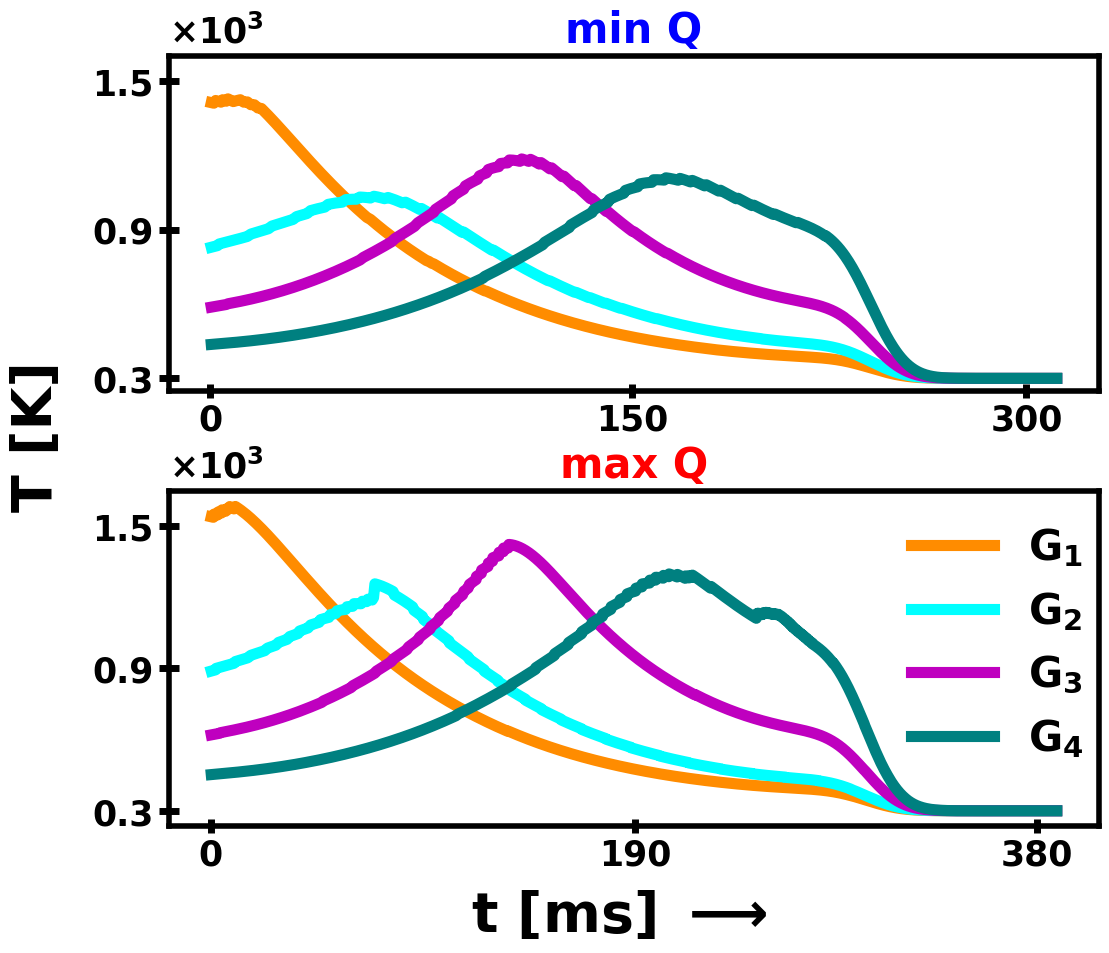

In [102]:
fig, ((ax1, ax2)) = plt.subplots(2,1, figsize=(12,10), frameon=False)
ax1.set_facecolor((0, 0, 0, 0))
ax2.set_facecolor((0, 0, 0, 0))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

ax1.plot(time_ms2[1:], M12_Temp[1:], color='darkorange', linewidth=8, label=r'G$_1$')
ax1.plot(time_ms2[1:], M22_Temp[1:], color='cyan', linewidth=8, label=r'G$_2$')
ax1.plot(time_ms2[1:], M32_Temp[1:], color='m', linewidth=8, label=r'G$_3$')
ax1.plot(time_ms2[1:], M42_Temp[1:], color='teal', linewidth=8, label=r'G$_4$')

# ax1.legend(loc=(0.565, -0.18), ncol=3,  columnspacing=1.0, prop={'weight':'bold', 'size':'20',}, 
#            handletextpad=0.5, handlelength=1.0,   frameon=True)#.get_frame().set_facecolor('none')


ax1.set_yticks([300, 900, 1500], labels=['0.3', '0.9', '1.5'], size=25, color='k', weight='bold')
ax1.set_title(r'$\mathbf{\times10^3}$', pad=0, loc='left', color='black', fontsize=25, weight='bold')
ax1.set_title('min Q',  fontsize=30, pad=10, weight='bold', color='blue')
# ax1.tick_params(axis='x', labelcolor='black', labelsize=30, bottom=False, top=False, labelbottom=False)
ax1.set_xticks([0, 150, 290], labels=['0', '150', '300'], size=25, color='k', weight='bold')
ax1.set_ylim(250,1600)

####################
ax2.plot(time_ms3[1:1525], M13_Temp[1:1525], color='darkorange', linewidth=8, label=r'G$\mathbf{_{1}}$')
ax2.plot(time_ms3[1:1525], M23_Temp[1:1525], color='cyan', linewidth=8, label=r'G$\mathbf{_{2}}$')
ax2.plot(time_ms3[1:1525], M33_Temp[1:1525], color='m', linewidth=8, label=r'G$\mathbf{_{3}}$')
ax2.plot(time_ms3[1:1525], M43_Temp[1:1525], color='teal', linewidth=8, label=r'G$\mathbf{_{4}}$')
ax2.legend(loc=(0.78, 0.150), framealpha=0, prop={'weight':'bold', 'size':'30'})


ax2.set_yticks([300, 900, 1500], labels=['0.3', '0.9', '1.5'], size=25, color='k', weight='bold')
ax2.set_title(r'$\mathbf{\times10^3}$', pad=0, loc='left', color='black', fontsize=25, weight='bold')
ax2.set_title('max Q', pad=10, fontsize=30, weight='bold', color='red')
ax2.set_xticks([0, 190, 370], labels=['0', '190', '380'], size=25, color='k', weight='bold')



fig.text(0.5, 0.02, r't [ms] $\mathbf{\longrightarrow}$', ha='center', va='center', fontsize=40, weight='bold')
fig.text(0.015, 0.5, r'T [K]', ha='center', va='center', rotation='vertical', fontsize=40, weight='bold')

ax1.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax1.tick_params(axis='x', direction='inout', which='both', length=10, width=5)
ax2.tick_params(axis='x', direction='inout', which='both', length=10, width=5)
ax2.tick_params(axis='y', direction='inout', which='both', length=15, width=5)

ax1.spines[:].set_linewidth(4)
ax2.spines[:].set_linewidth(4)


# plt.savefig('for_manuscript/T_u/F5/jpg/c.jpg', bbox_inches='tight')
# plt.savefig('for_manuscript/T_u/F5/c.png', bbox_inches='tight', dpi=800)

plt.show()

In [104]:
end_time_step1 = len(time_ms1)
end_time_step2 = len(time_ms2)
condition = 0.3

## Distance between far right end of IMC grain and far left end of IMC grain
effective_length_IMC_m1 = (IMC_front(IMC41, condition=condition, end_time_step=end_time_step1) - IMC_rear(IMC11, condition=condition, end_time_step=end_time_step1))*(1300/371)
effective_length_IMC_m2 = (IMC_front(IMC42, condition=condition, end_time_step=end_time_step2) - IMC_rear(IMC12, condition=condition, end_time_step=end_time_step2))*(1300/371)

area_IMC_m1 = np.array(area_df1['area_IMC_total'][:end_time_step1]) ## end_time_step1 (1025) coz we only have 1025 t_steps imported for all IMC1_
area_IMC_m2 = np.array(area_df2['area_IMC_total']) 

effective_height_IMC_m1 = area_IMC_m1/effective_length_IMC_m1
effective_height_IMC_m2 = area_IMC_m2/effective_length_IMC_m2

effective_radius_IMC_m1 = (area_IMC_m1/np.pi)**0.5
effective_radius_IMC_m2 = (area_IMC_m2/np.pi)**0.5

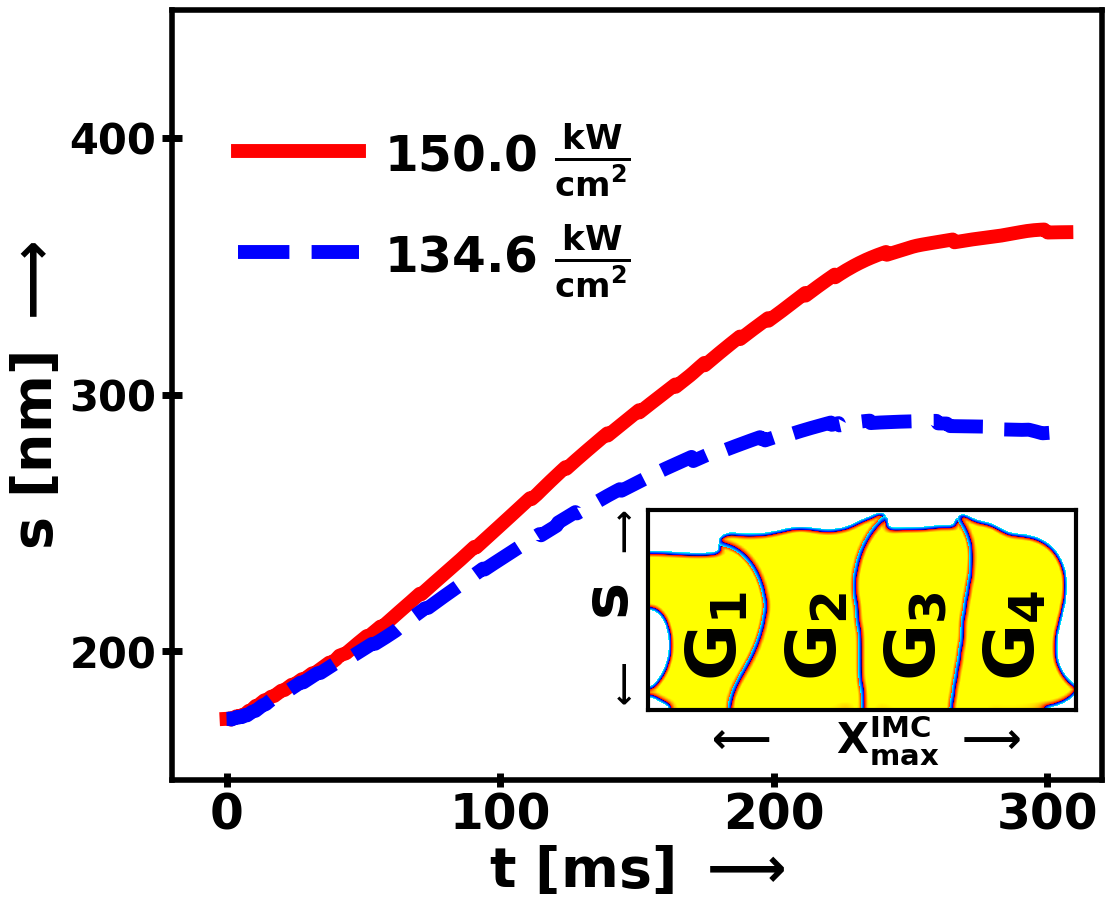

In [123]:
fig, ax1 = plt.subplots(figsize=(12, 10), nrows=1, ncols=1, frameon=False)
ax1.set_facecolor((0, 0, 0, 0))

h1, = ax1.plot(time_ms1, effective_height_IMC_m1, color='red', linestyle='-', linewidth=10,  label =r'150.0 $\mathbf{\frac{kW}{cm^2}}$')
h2, = ax1.plot(time_ms2, effective_height_IMC_m2, color='blue', linestyle='--', linewidth=10, label =r'134.6 $\mathbf{\frac{kW}{cm^2}}$') ## time_ms2[4:] find the shape of meltpool_length2 and determine time_ms[:]
ax1.set_yticks([200, 300, 400], labels=['200', '300', '400',], color='k', size=30, rotation=0,  weight='bold')
ax1.set_ylim(150,450)
ax1.set_xlim(-20,320)
ax1.set_xlabel(r't [ms] $\mathbf{\longrightarrow}$', color='k', weight='bold', fontsize=40)
ax1.set_xticks([0, 100, 200, 300], labels=['0', '100', '200', '300'], size=35, color='k', weight='bold')
ax1.set_ylabel(r's [nm] $\mathbf{\longrightarrow}$', color='k', weight='bold', fontsize=40)
legend1 = ax1.legend(loc=(0.05,0.6), ncol=1, columnspacing=0.5, prop={'weight':'bold', 'size':'35',},
                     handleheight=1,  handletextpad=0.5, handlelength=2.5,  frameon=False).get_frame().set_facecolor('none')

ax3 = fig.add_axes([0.50, 0.18, 0.4, 0.20], frameon=True)  # [left, bottom, width, height]
ax3.set_facecolor((0, 0, 0, 0))

ax3.tick_params(axis='both', labelcolor='black', labelsize=1, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False,)
cmap=cold2hot
cmap.set_under('white', alpha=0)
hmap21 = ax3.imshow(IMC11[20:,:302,1024], cmap=cmap, vmin=0.3, vmax=0.9, interpolation='bilinear')
hmap22 = ax3.imshow(IMC21[20:,:302,1024], cmap=cmap, vmin=0.3, vmax=0.9, interpolation='bilinear')
hmap23 = ax3.imshow(IMC31[20:,:302,1024], cmap=cmap, vmin=0.3, vmax=0.9, interpolation='bilinear')
hmap24 = ax3.imshow(IMC41[20:,:302,1024], cmap=cmap, vmin=0.3, vmax=0.9, interpolation='bilinear')

ax3.set_xlabel('$\mathbf{\longleftarrow}$    X$\mathbf{^{IMC}_{max}}$ $\mathbf{\longrightarrow}$', fontsize = 30, weight ='bold', labelpad=3)
ax3.set_ylabel('$\mathbf{\longleftarrow}$         $\mathbf{\longrightarrow}$', fontsize = 22, weight ='bold', labelpad=5, color='k')
ax3.text(x=-50, y=65, s=r's', rotation=90, fontsize=45, weight='bold', color='black')
ax3.text(x=25, y=110, s=r'G$\mathbf{_1}$', rotation=90, fontsize=50, weight='bold', color='black')
ax3.text(x=95, y=110, s=r'G$\mathbf{_2}$', rotation=90, fontsize=50, weight='bold', color='black')
ax3.text(x=165, y=110, s=r'G$\mathbf{_3}$', rotation=90, fontsize=50, weight='bold', color='black')
ax3.text(x=235, y=110, s=r'G$\mathbf{_4}$', rotation=90, fontsize=50, weight='bold', color='black')

# ax3.plot(32, 31, marker='x', color='black', markersize=20)
# ax3.plot(110, 14, marker='x', color='black', markersize=20)
# ax3.plot(192, 14, marker='x', color='black', markersize=20)
# ax3.plot(255, 16, marker='x', color='black', markersize=20)

ax1.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax1.tick_params(axis='x', direction='inout', which='both', length=10, width=5)

ax1.spines[:].set_linewidth(4)
ax3.spines[:].set_linewidth(3)

# plt.savefig('for_manuscript/T_u/F5/jpg/d.jpg', bbox_inches='tight')
# plt.savefig('for_manuscript/T_u/F5/d.png', bbox_inches='tight', dpi=800)

plt.show()

In [126]:
max(effective_height_IMC_m1), max(effective_height_IMC_m2)

(364.32556931787724, 289.8716480585454)

In [125]:
time_ms1[np.argmax(effective_height_IMC_m1)], time_ms2[np.argmax(effective_height_IMC_m2)]

(298.90625, 235.15625)

# Temperature-time graph

In [5]:
irridance1 = r"$\mathbf{150.0 \frac{kW}{cm^2}}$"
irridance2 = r" $\mathbf{134.6 \frac{kW}{cm^2}}$"

In [6]:
Ti1 = np.load(path1+'/Ti.npy')
Au_SOL1 = np.load(path1+'/Au_SOL.npy')
Au_LIQ1 = np.load(path1+'/Au_LIQ.npy')
IMC11 = np.load(path1+'/IMC1.npy')
IMC21 = np.load(path1+'/IMC2.npy')
IMC31 = np.load(path1+'/IMC3.npy')
IMC41 = np.load(path1+'/IMC4.npy')

In [7]:
x1 = time_ms1[1:time_steps1] 
point_11 = temp1[0,30,1:time_steps1]
point_21 = temp1[0,130,1:time_steps1]
point_31 = temp1[0,230,1:time_steps1]

x2 = time_ms2[1:time_steps2] 
point_12 = temp2[0,30,1:time_steps2]
point_22 = temp2[0,130,1:time_steps2]
point_32 = temp2[0,230,1:time_steps2]

In [8]:
def index_tracker(array, condition):
    return [index for index, element in enumerate(array) if element >= condition]

p11 = [index_tracker(point_11, 1337)[0], index_tracker(point_11, 1337)[-1]]
p21 = [index_tracker(point_21, 1337)[0], index_tracker(point_21, 1337)[-1]]
p31 = [index_tracker(point_31, 1337)[0], index_tracker(point_31, 1337)[-1]]

p12 = [index_tracker(point_12, 1337)[0], index_tracker(point_12, 1337)[-1]]
p22 = [index_tracker(point_22, 1337)[0], index_tracker(point_22, 1337)[-1]]
p32 = [index_tracker(point_32, 1337)[0], index_tracker(point_32, 1337)[-1]]

In [9]:
print(f'Point P is at {(1300/371)*30:.0f} nm' )
print(f'Point Q is at {(1300/371)*130-1:.0f} nm')
print(f'Point R is at {(1300/371)*230-1:.0f} nm')

Point P is at 105 nm
Point Q is at 455 nm
Point R is at 805 nm


In [10]:
Tmax_P1 = np.max(point_11)
Tmax_P2 = np.max(point_12)

Tmax_Q1 = np.max(point_21)
Tmax_Q2 = np.max(point_22)

Tmax_R1 = np.max(point_31)
Tmax_R2 = np.max(point_32)

del_P1 =  x1[p11[1]]-x1[p11[0]]
del_P2 =  x2[p12[1]]-x2[p12[0]]

del_Q1 = x1[p21[1]]-x1[p21[0]]
del_Q2 = x2[p22[1]]-x2[p22[0]]

del_R1 = x1[p31[1]]-x1[p31[0]]
del_R2 = x2[p32[1]]-x2[p32[0]]

print(f"The maximum temperautre attained for I = 150 kw/cm2 by point \n P: {Tmax_P1:.1f} k \n Q: {Tmax_Q1:.1f} k \n R: {Tmax_R1:.1f} k")
print("\n")
print(f"The maximum temperautre attained for I = 134.6 kw/cm2 by point \n P: {Tmax_P2:.1f} k \n Q: {Tmax_Q2:.1f} k \n R: {Tmax_R2:.1f} k")
print("\n")
print(f"The time above thermal melting attained for I = 150 kw/cm2 \n P: {del_P1:.1f} ms (only half is considered) \n Q: {del_Q1:.1f} ms \n R: {del_R1:.1f} ms")
print("\n")
print(f"The time above thermal melting attained for I = 134.6 kw/cm2 \n P: {del_P2:.1f} ms  (only half is considered) \n Q: {del_Q2:.1f} ms \n R: {del_R2:.1f} ms")

The maximum temperautre attained for I = 150 kw/cm2 by point 
 P: 2407.7 k 
 Q: 1893.9 k 
 R: 1874.7 k


The maximum temperautre attained for I = 134.6 kw/cm2 by point 
 P: 2191.4 k 
 Q: 1723.1 k 
 R: 1701.6 k


The time above thermal melting attained for I = 150 kw/cm2 
 P: 38.4 ms (only half is considered) 
 Q: 55.0 ms 
 R: 52.7 ms


The time above thermal melting attained for I = 134.6 kw/cm2 
 P: 32.8 ms  (only half is considered) 
 Q: 42.5 ms 
 R: 41.2 ms


In [11]:
del_t_P = del_P1-del_P2
del_T_P = Tmax_P1-Tmax_P2

del_t_Q = del_Q1-del_Q2
del_T_Q = Tmax_Q1-Tmax_Q2

del_t_R = del_R1-del_R2
del_T_R = Tmax_R1-Tmax_R2

In [12]:
(del_T_P/del_t_P)/2, del_T_Q/del_t_Q, del_T_R/del_t_R

(19.229426715219436, 13.667262979668976, 15.171740975243331)

In [13]:
print(f'For Point P: {Tmax_P1/Tmax_P2:.2f}', f'{del_P1/del_P2:.2f}', f'{150/134.6:.2f}')
print(f'For Point Q: {Tmax_Q1/Tmax_Q2:.3f}', f'{del_Q1/del_Q2:.3f}', f'{150/134.6:.3f}')
print(f'For Point R: {Tmax_R1/Tmax_R2:.3f}', f'{del_R1/del_R2:.3f}', f'{150/134.6:.3f}')
print('\n')
print(f'The ratio of maximum temperature at 2 laser irradiance for a point is nearly equal to the ratio of laser irradiance itself and nearly equal to the time it lies above thermal metling that is: {1.1}')

For Point P: 1.10 1.17 1.11
For Point Q: 1.099 1.294 1.114
For Point R: 1.102 1.277 1.114


The ratio of maximum temperature at 2 laser irradiance for a point is nearly equal to the ratio of laser irradiance itself and nearly equal to the time it lies above thermal metling that is: 1.1


In [17]:
Tmax_P1/(2*del_P1), Tmax_Q1/del_Q1, Tmax_R1/del_R1

(31.320119589956768, 34.43452471308468, 35.60178051218252)

In [18]:
Tmax_P2/(2*del_P2), Tmax_Q2/del_Q2, Tmax_R2/del_R2

(33.392809797054596, 40.542542869971655, 41.2509959901998)

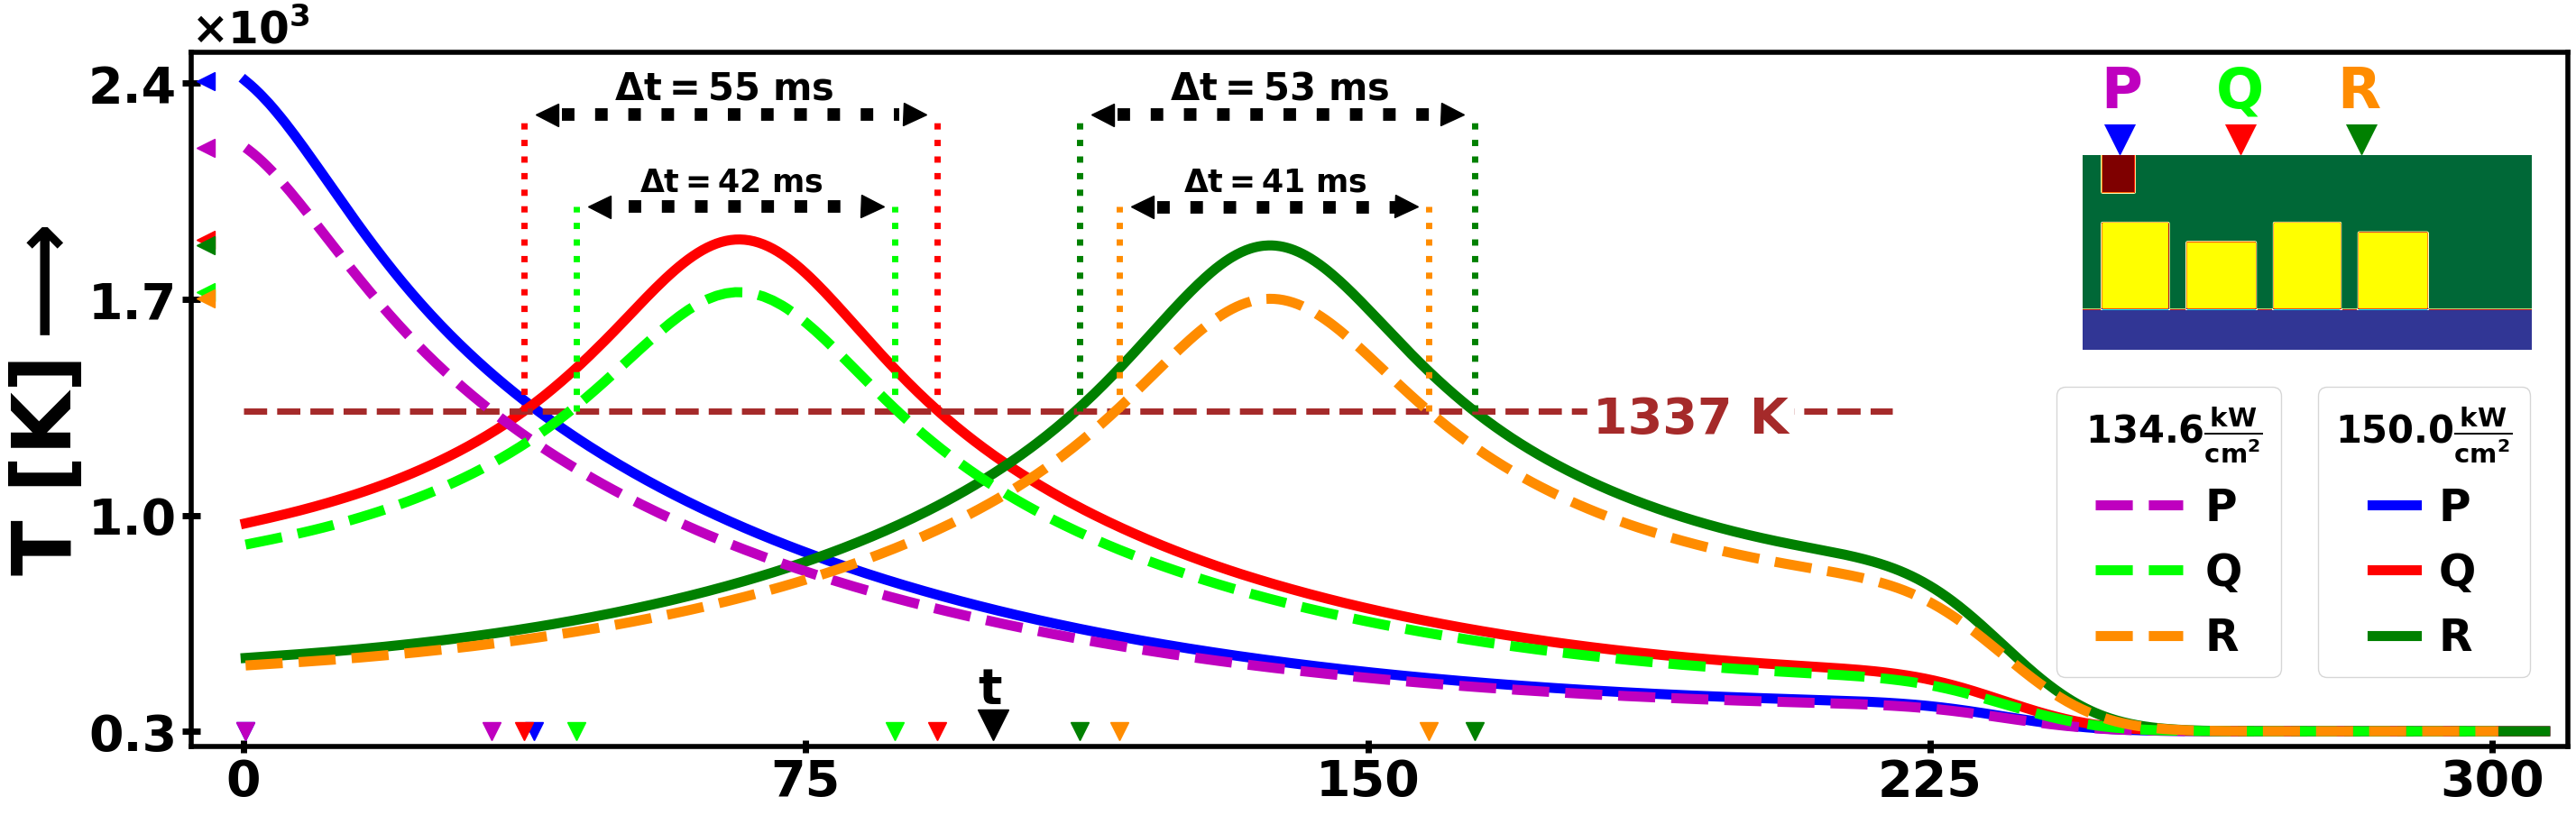

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize=[34, 10],  frameon=True)
ax1.set_facecolor((0, 0, 0, 0))

ax1.plot(x1, point_11, linewidth=8, linestyle='-', color = 'blue', label ='P')
ax1.plot(x1, point_21, linewidth=8, linestyle='-', color='red', label='Q')
ax1.plot(x1, point_31, linewidth=8, linestyle='-', color='green', label='R')
ax1.set_ylabel(r"T [K]$\mathbf{\longrightarrow}$", loc='center',  weight = 'bold', labelpad=0, size=65, color='k')
# ax1.set_xlabel(r"t [ms]$\mathbf{\longrightarrow}$", loc='center',  weight = 'bold', labelpad=0, size=65, color='k')
ax1.set_xticks([0, 75, 150, 225, 300], labels=['0', '75', '150', '225', '300'], size=40, color='k')
ax1.set_yticks([300, 1000, 1700, 2400], labels=['0.3', '1.0', '1.7', '2.4',], size=40, color='k' )
ax1.set_title(r'$\mathbf{\times10^3}$', pad=0, loc='left', color='k', fontsize=35, weight='bold')
ax1.set_ylim(250, 2500)
ax1.set_xlim(-7, 310)

for label in ax1.get_xticklabels(): label.set_fontweight('bold')
for label in ax1.get_yticklabels(): label.set_fontweight('bold')
legend1 = ax1.legend(title = f'{irridance1}', title_fontsize=30, loc=(0.895, 0.1), ncol=1,  columnspacing=1.0, prop={'weight':'bold', 'size':'35',}, handletextpad=0.5, handlelength=1.0,   frameon=True).get_frame().set_facecolor('none')

ax1.hlines(y=1337, xmin=0, xmax=220, color='brown', linestyle='--', linewidth=5)
ax1.text(180, 1337-70, r"1337 K", rotation=0, color='brown', fontsize=40, weight='bold', backgroundcolor='white',)

ax1.vlines(x=x1[p21[0]], ymin=1337, ymax=2300,  linewidth=5, color='red', linestyle=':')
ax1.vlines(x=x1[p21[1]], ymin=1337, ymax=2300,  linewidth=5, color='red', linestyle=':')
ax1.text(x=x1[p21[0]]+12, y=2350, s=r'$\mathbf{\Delta t =}$'+f'{x1[p21[1]]-x1[p21[0]]:.0f} ms', fontsize=30, weight='bold')
ax1.hlines(y=2300, xmin=x1[p21[0]]+5, xmax=x1[p21[1]]-5, linewidth=10, color='k', linestyle=':')
ax1.plot(x1[p21[0]]+3,  2300, marker='<', color='black', markersize=18)
ax1.plot(x1[p21[1]]-3,  2300, marker='>', color='black', markersize=18)


ax1.vlines(x=x1[p31[0]], ymin=1337, ymax=2300,  linewidth=5, color='green', linestyle=':')
ax1.vlines(x=x1[p31[1]], ymin=1337, ymax=2300,  linewidth=5, color='green', linestyle=':')
ax1.text(x=x1[p31[0]]+12, y=2350, s=r'$\mathbf{\Delta t =}$'+f'{x1[p31[1]]-x1[p31[0]]:.0f} ms', fontsize=30, weight='bold')
ax1.hlines(y=2300, xmin=x1[p31[0]]+5, xmax=x1[p31[1]]-5, linewidth=10, color='k', linestyle=':')
ax1.plot(x1[p31[0]]+3,  2300, marker='<', color='black', markersize=18)
ax1.plot(x1[p31[1]]-3,  2300, marker='>', color='black', markersize=18)

ax4 = fig.add_axes([0.64, 0.55, 0.35, 0.25], frameon=False)  # [left, bottom, width, height]
ax4.tick_params(axis='both', labelcolor='black', labelsize=1, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False,)

t_step=0
cmap1 = plt.get_cmap('RdYlBu')
cmap2 = cold2hot
cmap3 = plt.get_cmap('jet')
cmap4 = plt.get_cmap('RdYlGn')
cmap1.set_under('white', alpha=0)
cmap2.set_under('white', alpha=0)
cmap3.set_under('white', alpha=0)
cmap4.set_under('white', alpha=0)
hmap1 = ax4.imshow(Ti1[:,:,t_step], cmap=cmap1, vmin=0.3, vmax=1.0, interpolation='bilinear')
hmap21 = ax4.imshow(IMC11[:,:,t_step], cmap=cmap2, vmin=0.3, vmax=0.9, interpolation='bilinear')
hmap22 = ax4.imshow(IMC21[:,:,t_step], cmap=cmap2, vmin=0.3, vmax=0.9, interpolation='bilinear')
hmap23 = ax4.imshow(IMC31[:,:,t_step], cmap=cmap2, vmin=0.3, vmax=0.9, interpolation='bilinear')
hmap24 = ax4.imshow(IMC41[:,:,t_step], cmap=cmap2, vmin=0.3, vmax=0.9, interpolation='bilinear')
hmap3 = ax4.imshow(Au_LIQ1[:,:,t_step], cmap=cmap3, vmin=0.3, vmax=0.9, interpolation='bilinear')
hmap4 = ax4.imshow(Au_SOL1[:,:,t_step], cmap=cmap4, vmin=0.3, vmax=0.9, interpolation='bilinear')

########### Points P and Q ######################
ax4.plot(30,  -17, marker='v', color='blue', markersize=30) ## Point P is selected to be the point where laser hits the material
ax4.text(15,  -40, "P", rotation=0, color='m', fontsize=45, weight='bold')
ax4.plot(130, -17, marker='v', color='red', markersize=30)  # random point Q which is 100 distance far away from point P 
ax4.text(110, -40, "Q", rotation=0, color='lime', fontsize=45, weight='bold')
ax4.plot(230, -17, marker='v', color='green', markersize=30)  # random point R which is 100 distance far away from point Q
ax4.text(210, -40, "R", rotation=0, color='darkorange', fontsize=45, weight='bold')

######################################
######################################
ax2 = ax1.twinx()
ax2.plot(x2, point_12, linewidth=8, linestyle='--', color = 'm', label ='P')
ax2.plot(x2, point_22, linewidth=8, linestyle='--', color='lime', label='Q')
ax2.plot(x2, point_32, linewidth=8, linestyle='--', color='darkorange', label='R')

for label in ax2.get_xticklabels(): label.set_fontweight('bold')
ax2.set_yticks([])
legend2 = ax2.legend(title = f'{irridance2}', title_fontsize=30, loc=(0.785, 0.1), ncol=1, columnspacing=1.0, prop={'weight':'bold', 'size':'35',}, handletextpad=0.5, handlelength=2.0, frameon=True).get_frame().set_facecolor('none')

ax2.set_ylim(250, 2500)
ax2.vlines(x=x2[p22[0]], ymin=1337, ymax=2000,  linewidth=5, color='lime', linestyle=':')
ax2.vlines(x=x2[p22[1]], ymin=1337, ymax=2000,  linewidth=5, color='lime', linestyle=':')
ax2.text(x=x2[p22[0]]+8.5, y=2050, s=r'$\mathbf{\Delta t =}$'+f'{x2[p22[1]]-x2[p22[0]]:.0f} ms', fontsize=25, weight='bold')
ax2.hlines(y=2000, xmin=x2[p22[0]]+7, xmax=x2[p22[1]]-5, linewidth=10, color='k', linestyle=':')
ax2.plot(x2[p22[0]]+3,  2000, marker='<', color='black', markersize=18)
ax2.plot(x2[p22[1]]-3,  2000, marker='>', color='black', markersize=18)

ax2.vlines(x=x2[p32[0]], ymin=1337, ymax=2000,  linewidth=5, color='darkorange', linestyle=':')
ax2.vlines(x=x2[p32[1]], ymin=1337, ymax=2000,  linewidth=5, color='darkorange', linestyle=':')
ax2.text(x=x2[p32[0]]+8.5, y=2050, s=r'$\mathbf{\Delta t =}$'+f'{x2[p32[1]]-x2[p32[0]]:.0f} ms', fontsize=25, weight='bold')
ax2.hlines(y=1998, xmin=x2[p32[0]]+5, xmax=x2[p32[1]]-4, linewidth=10, color='k', linestyle=':')
ax2.plot(x2[p32[0]]+3,  2000, marker='<', color='black', markersize=18)
ax2.plot(x2[p32[1]]-3,  2000, marker='>', color='black', markersize=18)

ax1.plot(-5, np.max(point_11), marker='<', color='blue', markersize=15)
ax1.plot(-5, np.max(point_21), marker='<', color='red', markersize=15)
ax1.plot(-5, np.max(point_31), marker='<', color='green', markersize=15)

ax2.plot(-5, np.max(point_12), marker='<', color='m', markersize=15)
ax2.plot(-5, np.max(point_22), marker='<', color='lime', markersize=15)
ax2.plot(-5, np.max(point_32), marker='<', color='darkorange', markersize=15)


ax1.plot(x1[p11[0]], 300, marker='v', color='blue', markersize=15)
ax1.plot(x1[p11[1]], 300, marker='v', color='blue', markersize=15)
ax1.plot(x1[p21[0]], 300, marker='v', color='red', markersize=15)
ax1.plot(x1[p21[1]], 300, marker='v', color='red', markersize=15)
ax1.plot(x1[p31[0]], 300, marker='v', color='green', markersize=15)
ax1.plot(x1[p31[1]], 300, marker='v', color='green', markersize=15)

ax2.plot(x2[p12[0]], 300, marker='v', color='m', markersize=15)
ax2.plot(x2[p12[1]], 300, marker='v', color='m', markersize=15)
ax2.plot(x2[p22[0]], 300, marker='v', color='lime', markersize=15)
ax2.plot(x2[p22[1]], 300, marker='v', color='lime', markersize=15)
ax2.plot(x2[p32[0]], 300, marker='v', color='darkorange', markersize=15)
ax2.plot(x2[p32[1]], 300, marker='v', color='darkorange', markersize=15)

ax1.spines[:].set_linewidth(4)
ax2.spines[:].set_linewidth(2)

ax1.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax1.tick_params(axis='x', direction='inout', which='both', length=10, width=5)

ax2.plot(100, 320, marker='v', color='black', markersize=25)
ax1.text(x=98, y=390, s=r't', fontsize=40, weight='bold', color='black')


# plt.savefig('for_manuscript/T_u/F2/jpg/T_t_s_5.jpg', bbox_inches='tight',)
# plt.savefig('for_manuscript/T_u/F2/T_t_s_5.png', bbox_inches='tight', dpi=800)
plt.show()

# Meltpool-FCC Free Energy  Difference

### LIQUID & FCC

In [8]:
Au_LIQ1 = np.load(path1+'/Au_LIQ.npy')
Au_SOL1 = np.load(path1+'/Au_SOL.npy')

Au_LIQ2 = np.load(path2+'/Au_LIQ.npy')
Au_SOL2 = np.load(path2+'/Au_SOL.npy')

Au_LIQ3 = np.load(path3+'/Au_LIQ.npy')
Au_SOL3 = np.load(path3+'/Au_SOL.npy')

Au_LIQ4 = np.load(path4+'/Au_LIQ.npy')
Au_SOL4 = np.load(path4+'/Au_SOL.npy')

In [9]:
def leading_front(array, condition, end_time_step):
    condition = condition
    end_step = end_time_step
    leading_front = []
    for t in range(end_step):
        A = array[10:11,:,t][0]  # 10:11 ->10 -> 31nm is a constant height point from the top for consideration here
        for i in range(len(A)-1,0,-1):
            if A[i]>=condition:
                # print(i)
                break
        leading_front.append(i)
    return np.array(leading_front)

def temperature_LIQ_FCC(array, xpos, y=10): # 10 -> 31nm is a constant height point from the top for consideration here
    LIQ_temp, FCC_temp = [], []
    for t, x in enumerate(xpos):
        LIQ_temp.append(array[10,x-3,t]) # -3 -> 10.5 nm inside at LIQUID from interface
        FCC_temp.append(array[10,x+3,t]) # +3 -> 10.5 nm outside at FCC from interface
    return np.array(LIQ_temp), np.array(FCC_temp)

In [10]:
t1, t2, t3, t4 = 726, 285, 1091, 528 # end_time 760, 295, 1125, 543 for at around 365+-3 xpoints check using MF1[:760]
MF1= leading_front(array=Au_LIQ1, condition=0.45, end_time_step= time_steps1)[:t1]
MF2= leading_front(array=Au_LIQ2, condition=0.45, end_time_step= time_steps2)[:t2]
MF3= leading_front(array=Au_LIQ3, condition=0.45, end_time_step= time_steps3)[:t3]
MF4= leading_front(array=Au_LIQ4, condition=0.45, end_time_step= time_steps4)[:t4]

In [11]:
LIQ_temp1, FCC_temp1 = temperature_LIQ_FCC(temp1, MF1, 10) # 10 -> 31nm is a constant height point from the top for consideration here
LIQ_temp2, FCC_temp2 = temperature_LIQ_FCC(temp2, MF2, 10)
LIQ_temp3, FCC_temp3 = temperature_LIQ_FCC(temp3, MF3, 10)
LIQ_temp4, FCC_temp4 = temperature_LIQ_FCC(temp4, MF4, 10)

#### Free Energy Calculation

In [12]:
G1_LIQ, G1_FCC =  Au_liq((c_LIQ, LIQ_temp1)),  Au_sol((c_FCC, FCC_temp1))
G2_LIQ, G2_FCC =  Au_liq((c_LIQ, LIQ_temp2)),  Au_sol((c_FCC, FCC_temp2))
G3_LIQ, G3_FCC =  Au_liq((c_LIQ, LIQ_temp3)),  Au_sol((c_FCC, FCC_temp3))
G4_LIQ, G4_FCC =  Au_liq((c_LIQ, LIQ_temp4)),  Au_sol((c_FCC, FCC_temp4))

### Meltpool Depth

In [13]:
def total_depth(array, condition, end_time_step):
    height = array.shape[0]
    depth = []
    for t in range(end_time_step):
        for i in range(height):
            if np.max(array[i:i+1,:,t])<condition:
                # print(i)
                depth.append(i) 
                break
    return np.array(depth)

def meltpool_width(array, condition, end_time_step):
    width = []
    for t in range(end_time_step):
        meltpool_region = np.where(array[0:1,:,t][0] > condition)[0]
        consecutive_regions = np.split(meltpool_region, np.where(np.diff(meltpool_region) != 1)[0] + 1)
        width_t = 0
        for i in range(len(consecutive_regions)):
            width_t += len(consecutive_regions[i])-1  ##  -1 coz we're measuring the width distance of meltpool, and len() gives value of 21 for 20,21,22,...40 but it is 40-20 i.e.20
        width.append(width_t)
    return np.array(width)

In [14]:
end_time_step1 = 1025 # time_steps1
end_time_step2 = 463 # time_steps2
end_time_step3 = 1754 # time_steps3
end_time_step4 = 791 # time_steps4
condition = 0.5

# meltpool_width1 = width_calculator(Au_LIQ1, condition=condition, end_time_step=end_time_step1)*(1300/371)
# meltpool_width2 = width_calculator(Au_LIQ2, condition=condition, end_time_step=end_time_step2)*(1300/371)
# meltpool_width3 = width_calculator(Au_LIQ3, condition=condition, end_time_step=end_time_step3)*(1300/371)
# meltpool_width4 = width_calculator(Au_LIQ4, condition=condition, end_time_step=end_time_step4)*(1300/371)

meltpool_width1 = meltpool_width(Au_LIQ1, condition=condition, end_time_step=end_time_step1)*(1300/371)
meltpool_width2 = meltpool_width(Au_LIQ2, condition=condition, end_time_step=end_time_step2)*(1300/371)
meltpool_width3 = meltpool_width(Au_LIQ3, condition=condition, end_time_step=end_time_step3)*(1300/371)
meltpool_width4 = meltpool_width(Au_LIQ4, condition=condition, end_time_step=end_time_step4)*(1300/371)


meltpool_depth1 = total_depth(Au_LIQ1, condition=condition, end_time_step=end_time_step1)*(500/161)
meltpool_depth2 = total_depth(Au_LIQ2, condition=condition, end_time_step=end_time_step2)*(500/161)
meltpool_depth3 = total_depth(Au_LIQ3, condition=condition, end_time_step=end_time_step3)*(500/161)
meltpool_depth4 = total_depth(Au_LIQ4, condition=condition, end_time_step=end_time_step4)*(500/161)

####  Fig 6a

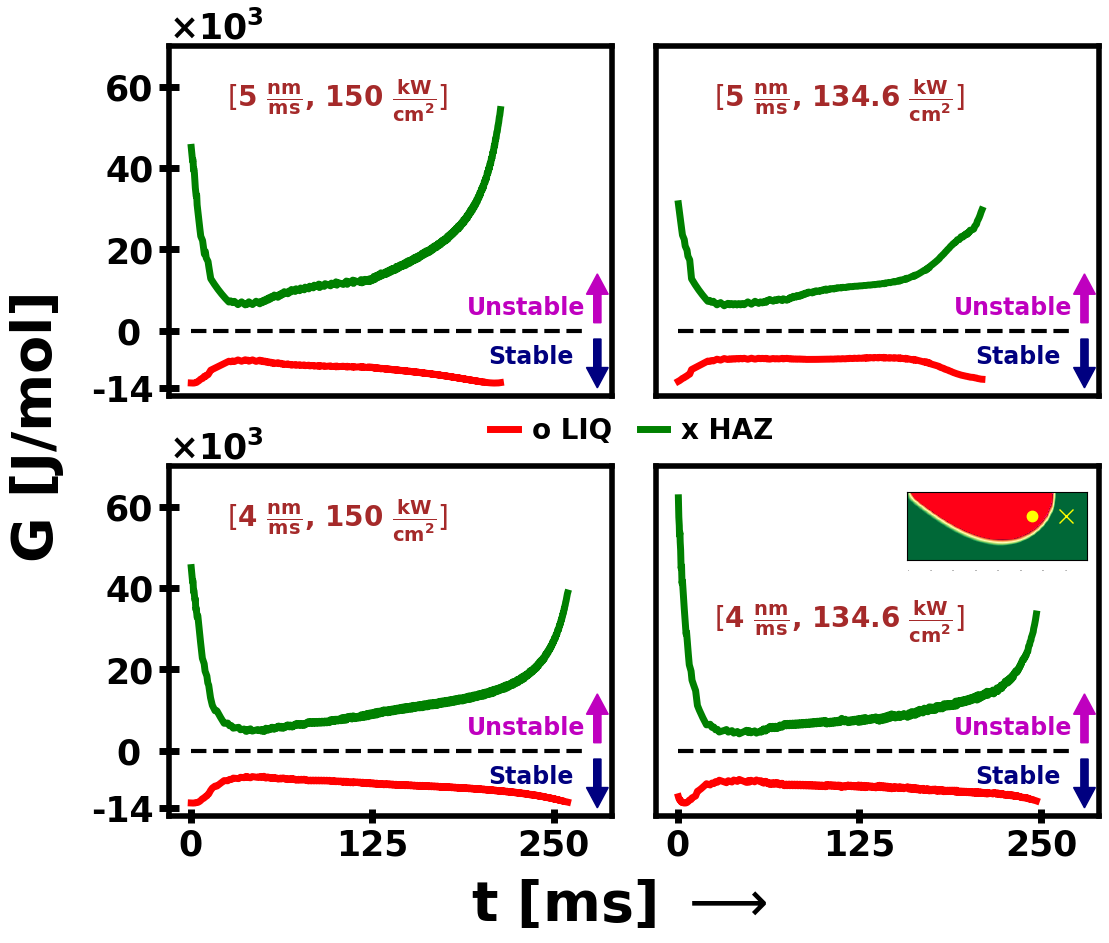

In [16]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,10), frameon=False)
ax1.set_facecolor((0, 0, 0, 0))
ax2.set_facecolor((0, 0, 0, 0))
ax3.set_facecolor((0, 0, 0, 0))
ax4.set_facecolor((0, 0, 0, 0))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.2)

ax1.plot(time_ms1[1:t1], G1_LIQ[1:], color='red', linewidth=5, label=r'o LIQ')
ax1.plot(time_ms1[1:t1], G1_FCC[1:], color='green', linewidth=5, label=r'x HAZ')
ax1.set_ylim(-16000, 70000)
ax1.set_xlim(-15, 290)
# ax1.set_xticks([0, 125, 250], labels=['0', '125', '250'], size=25, color='k', weight='bold')
# ax1.set_title(r'G$_1$', fontsize=30, weight='bold')
ax1.tick_params(axis='x', labelcolor='black', labelsize=30, bottom=False, top=False, labelbottom=False)
ax1.set_yticks([60000, 40000, 20000, 0, -14000], labels=['60', '40', '20', '0 ', '-14'], size=25, color='k', weight='bold' )
ax1.set_title(r'$\times$10$^3$', pad=0, loc='left', color='black', fontsize=20, weight='bold')
ax1.set_title(r'$\mathbf{\times10^3}$', pad=0, loc='left', color='black', fontsize=25, weight='bold')
ax1.hlines(y=0, xmin=0, xmax=270, linestyle = '--', linewidth=3, color='k')
ax1.text(x=190, y=4000, s='Unstable', rotation=0, fontsize=17, weight='bold', color='m')
ax1.text(x=205, y=-8000, s='Stable', rotation=0, fontsize=17, weight='bold', color='navy')
ax1.arrow(x=280, y=2000, dx=0, dy=12000, width=5, color='m', length_includes_head=True, head_length=5000, clip_on=False)
ax1.arrow(x=280, y=-2000, dx=0, dy=-12000, width=5, color='navy', length_includes_head=True, head_length=5000, clip_on=False)
ax1.legend(loc=(0.7, -0.17), ncol=3, framealpha=0, columnspacing=1.0, prop={'weight':'bold', 'size':'20',}, handletextpad=0.5, handlelength=1.0,   frameon=True)#.get_frame().set_facecolor('none')
ax1.text(x=25, y=55000 ,s=r'$\lbrack$5 $\mathbf{\frac{nm}{ms}}$, 150 $\mathbf{\frac{kW}{cm^2}}$$\rbrack$',  fontsize=20, weight='bold', color='brown')
# ax1.text(x=80, y=50000 ,s=r'150 $\mathbf{\frac{kW}{cm^2}}$',  fontsize=20, weight='bold', color='k')


ax2.plot(time_ms2[1:t2], G2_FCC[1:], color='green', linewidth=5, label='Right')
ax2.plot(time_ms2[1:t2], G2_LIQ[1:], color='red', linewidth=5, label='Left')
ax2.set_ylim(-16000, 70000)
ax2.set_xlim(-15, 290)
# ax2.set_xticks([0, 125, 250], labels=['0', '125', '250'], size=25, color='k', weight='bold')
# ax2.set_title(r'G$_2$', fontsize=30, weight='bold')
ax2.tick_params(axis='x', labelcolor='black', labelsize=30, bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', labelcolor='black', labelsize=30, left=False, right=False, labelleft=False)
ax2.hlines(y=0, xmin=0, xmax=270, linestyle = '--', linewidth=3, color='k')
ax2.text(x=190, y=4000, s='Unstable', rotation=0, fontsize=17, weight='bold', color='m')
ax2.text(x=205, y=-8000, s='Stable', rotation=0, fontsize=17, weight='bold', color='navy')
ax2.arrow(x=280, y=2000, dx=0, dy=12000, width=5, color='m', length_includes_head=True, head_length=5000, clip_on=False)
ax2.arrow(x=280, y=-2000, dx=0, dy=-12000, width=5, color='navy', length_includes_head=True, head_length=5000, clip_on=False)
# ax2.text(x=80, y=60000 ,s='min Q',  fontsize=30, weight='bold', color='blue')
ax2.text(x=25, y=55000 ,s=r'$\lbrack$5 $\mathbf{\frac{nm}{ms}}$, 134.6 $\mathbf{\frac{kW}{cm^2}}$$\rbrack$',  fontsize=20, weight='bold', color='brown')


ax3.plot(time_ms3[1:t3], G3_FCC[1:], color='green', linewidth=5, label='Right')
ax3.plot(time_ms3[1:t3], G3_LIQ[1:], color='red', linewidth=5, label='Left')
ax3.set_ylim(-16000, 70000)
ax3.set_xlim(-15, 290)
# ax3.set_title(r'G$_3$', fontsize=30, weight='bold')
ax3.set_yticks([60000, 40000, 20000, 0, -14000], labels=['60', '40', '20', '0 ', '-14'], size=25, color='k', weight='bold' )
ax3.set_xticks([0, 125, 250], labels=['0', '125', '250'], size=25, color='k', weight='bold')
ax3.set_title(r'$\mathbf{\times10^3}$', pad=0, loc='left', color='black', fontsize=25, weight='bold')
ax3.hlines(y=0, xmin=0, xmax=270, linestyle = '--', linewidth=3, color='k')
ax3.text(x=190, y=4000, s='Unstable', rotation=0, fontsize=17, weight='bold', color='m')
ax3.text(x=205, y=-8000, s='Stable', rotation=0, fontsize=17, weight='bold', color='navy')
ax3.arrow(x=280, y=2000, dx=0, dy=12000, width=5, color='m', length_includes_head=True, head_length=5000, clip_on=False)
ax3.arrow(x=280, y=-2000, dx=0, dy=-12000, width=5, color='navy', length_includes_head=True, head_length=5000, clip_on=False)
# ax3.text(x=80, y=60000 ,s='max Q',  fontsize=30, weight='bold', color='red')
ax3.text(x=25, y=55000 ,s=r'$\lbrack$4 $\mathbf{\frac{nm}{ms}}$, 150 $\mathbf{\frac{kW}{cm^2}}$$\rbrack$',  fontsize=20, weight='bold', color='brown')



ax4.plot(time_ms4[1:t4], G4_FCC[1:], color='green', linewidth=5, label='Right')
ax4.plot(time_ms4[1:t4], G4_LIQ[1:], color='red', linewidth=5, label='Left')
ax4.set_ylim(-16000, 70000)
ax4.set_xlim(-15, 290)
ax4.set_xticks([0, 125, 250], labels=['0', '125', '250'], size=25, color='k', weight='bold')
# ax4.set_title(r'G$_4$', fontsize=30, weight='bold')
ax4.tick_params(axis='y', labelcolor='black', labelsize=30, left=False, right=False, labelleft=False)
ax4.hlines(y=0, xmin=0, xmax=270, linestyle = '--', linewidth=3, color='k')
ax4.text(x=190, y=4000, s='Unstable', rotation=0, fontsize=17, weight='bold', color='m')
ax4.text(x=205, y=-8000, s='Stable', rotation=0, fontsize=17, weight='bold', color='navy')
ax4.arrow(x=280, y=2000, dx=0, dy=12000, width=5, color='m', length_includes_head=True, head_length=5000, clip_on=False)
ax4.arrow(x=280, y=-2000, dx=0, dy=-12000, width=5, color='navy', length_includes_head=True, head_length=5000, clip_on=False)
ax4.text(x=25, y=30000 ,s=r'$\lbrack$4 $\mathbf{\frac{nm}{ms}}$, 134.6 $\mathbf{\frac{kW}{cm^2}}$$\rbrack$',  fontsize=20, weight='bold', color='brown')

ax5 = fig.add_axes([0.74, 0.35, 0.15, 0.1])
ax5.tick_params(axis='x', labelcolor='black', labelsize=0, top=False, bottom=False, labelleft=False)
ax5.tick_params(axis='y', labelcolor='black', labelsize=0, left=False, right=False, labelleft=False)
cmap = plt.get_cmap('hsv')
cmap.set_under('white', alpha=0)
hmap1 = ax5.imshow(Au_LIQ2[0:30,190:270,200], cmap=cmap, vmin=0.3, vmax=0.7, interpolation='bilinear')
cmap = plt.get_cmap('RdYlGn')
cmap.set_under('white', alpha=0)
hmap2 = ax5.imshow(Au_SOL2[0:30,190:270,200], cmap=cmap, vmin=0.3, vmax=0.7, interpolation='bilinear')
# ax5.text(x=55, y=10, s='^', fontsize=15, color='k')
# ax5.text(x=67, y=10, s='*', fontsize=15, color='k')

ax5.plot(55,10, marker='.', color='k', markersize=15, markeredgecolor='yellow', markerfacecolor='yellow')
ax5.plot(70,10, marker='x', color='k', markersize=10, markeredgecolor='yellow', markerfacecolor='yellow')

# main_title = plt.suptitle('min Q', y=0.95, fontsize=30, weight='bold', color='blue')




fig.text(0.5, 0.02, r't [ms] $\longrightarrow$', ha='center', va='center', fontsize=40, weight='bold')
fig.text(0.015, 0.5, r'G [J/mol]', ha='center', va='center', rotation='vertical', fontsize=40, weight='bold')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# fig.text(0.52, 0.81, r'5 $\mathbf{\frac{nm}{ms}}$', ha='center', va='center', fontsize=35, weight='bold', bbox=props)
# fig.text(0.015, 0.5, r'F [J/mol]', ha='center', va='center', rotation='vertical', fontsize=40, weight='bold')
ax1.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax3.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax3.tick_params(axis='x', direction='inout', which='both', length=10, width=5)
ax4.tick_params(axis='x', direction='inout', which='both', length=10, width=5)

ax1.spines[:].set_linewidth(4)
ax2.spines[:].set_linewidth(4)
ax3.spines[:].set_linewidth(4)
ax4.spines[:].set_linewidth(4)

# plt.savefig('for_manuscript/T_u/F6/jpg/a.jpg', bbox_inches='tight') 
# plt.savefig('for_manuscript/T_u/F6/a.png', bbox_inches='tight', dpi=800)

plt.show()

#### Fig 6b

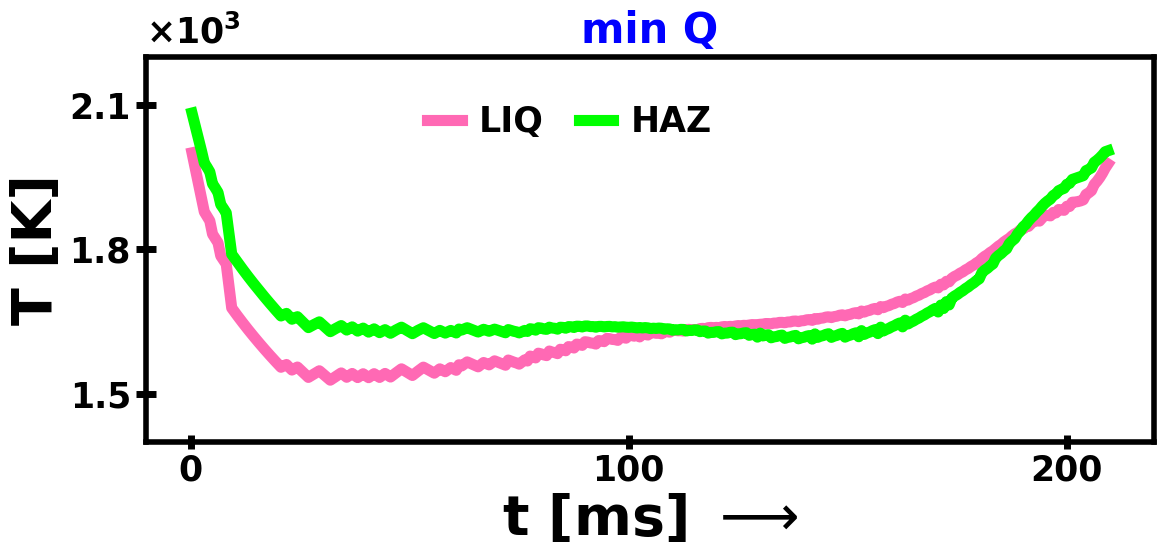

In [30]:
fig, ax1 = plt.subplots(1,1, figsize=(13,5), frameon=False)
ax1.set_facecolor((0, 0, 0, 0))


ax1.plot(time_ms2[1:t2], FCC_temp2[1:], color='hotpink', linewidth=8, label=r'LIQ')
ax1.plot(time_ms2[1:t2], LIQ_temp2[1:], color='lime', linewidth=8, label=r'HAZ')
ax1.legend(loc=(0.265, 0.75), ncol=2,  columnspacing=1.0, prop={'weight':'bold', 'size':'25',}, handletextpad=0.5, handlelength=1.0,   frameon=False)#.get_frame().set_facecolor('none')
ax1.set_yticks([1500, 1800, 2100], labels=['1.5', '1.8', '2.1'], size=25, color='k', weight='bold')
ax1.set_title(r'$\mathbf{\times10^3}$', pad=0, loc='left', color='black', fontsize=25, weight='bold')
ax1.set_title('min Q',  fontsize=30, weight='bold', color='blue', pad = 10)
# ax1.tick_params(axis='x', labelcolor='black', labelsize=30, bottom=False, top=False, labelbottom=False)
# ax1.set_xticks([0, 150, 290], labels=['0', '150', '300'], size=25, color='k', weight='bold')
ax1.set_xticks([0, 100, 200], labels=['0', '100', '200'], size=25, color='k', weight='bold')
ax1.set_ylim(1400,2200)


ax1.set_xlabel(r't [ms] $\longrightarrow$',  fontsize=40, weight='bold')
ax1.set_ylabel(r'T [K]',  fontsize=40, weight='bold')

ax1.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax1.tick_params(axis='x', direction='inout', which='both', length=10, width=5)
ax1.spines[:].set_linewidth(4)

# plt.savefig('for_manuscript/T_u/F6/jpg/b.jpg', bbox_inches='tight')
# plt.savefig('for_manuscript/T_u/F6/b.png', bbox_inches='tight', dpi=800)

plt.show()

#### Fig 6c

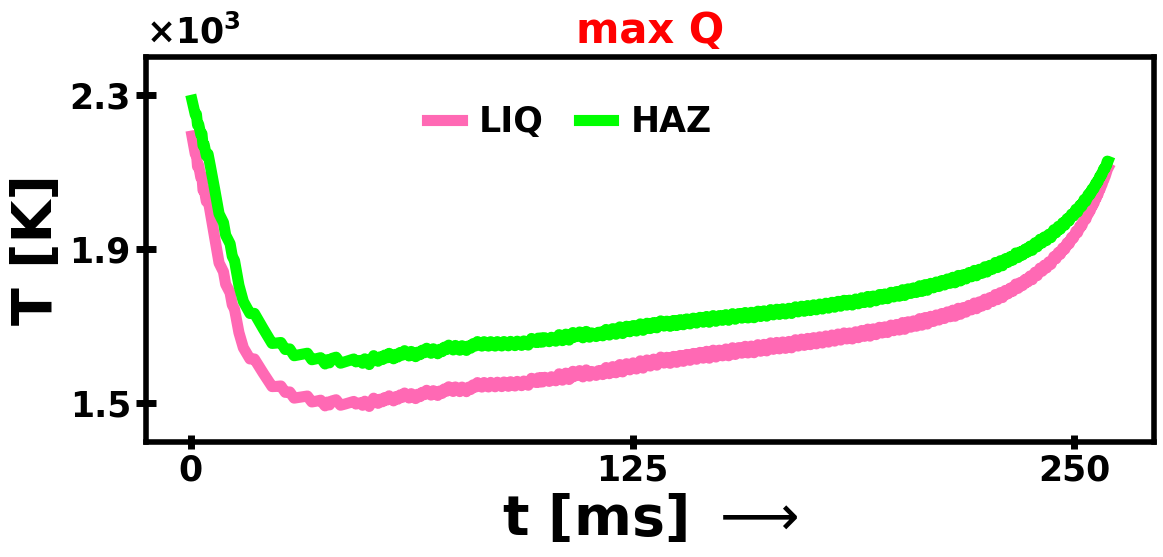

In [31]:
fig, ax1 = plt.subplots(1,1, figsize=(13,5), frameon=False)
ax1.set_facecolor((0, 0, 0, 0))


ax1.plot(time_ms3[1:t3], FCC_temp3[1:], color='hotpink', linewidth=8, label=r'LIQ')
ax1.plot(time_ms3[1:t3], LIQ_temp3[1:], color='lime', linewidth=8, label=r'HAZ')
ax1.legend(loc=(0.265, 0.75), ncol=2,  columnspacing=1.0, prop={'weight':'bold', 'size':'25',}, handletextpad=0.5, handlelength=1.0,   frameon=False)#.get_frame().set_facecolor('none')
ax1.set_yticks([1500, 1900, 2300], labels=['1.5', '1.9', '2.3'], size=25, color='k', weight='bold')
ax1.set_title(r'$\mathbf{\times10^3}$', pad=0, loc='left', color='black', fontsize=25, weight='bold')
ax1.set_title('max Q',  fontsize=30, weight='bold', pad=10, color='red')
# ax1.tick_params(axis='x', labelcolor='black', labelsize=30, bottom=False, top=False, labelbottom=False)
# ax1.set_xticks([0, 150, 290], labels=['0', '150', '300'], size=25, color='k', weight='bold')
ax1.set_xticks([0, 125, 250], labels=['0', '125', '250'], size=25, color='k', weight='bold')
ax1.set_ylim(1400,2400)


ax1.set_xlabel(r't [ms] $\longrightarrow$',  fontsize=40, weight='bold')
ax1.set_ylabel(r'T [K]',  fontsize=40, weight='bold')

ax1.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax1.tick_params(axis='x', direction='inout', which='both', length=10, width=5)

ax1.spines[:].set_linewidth(4)

# plt.savefig('for_manuscript/T_u/F6/jpg/c.jpg', bbox_inches='tight')
# plt.savefig('for_manuscript/T_u/F6/c.png', bbox_inches='tight', dpi=800)

plt.show()

#### Fig 6d

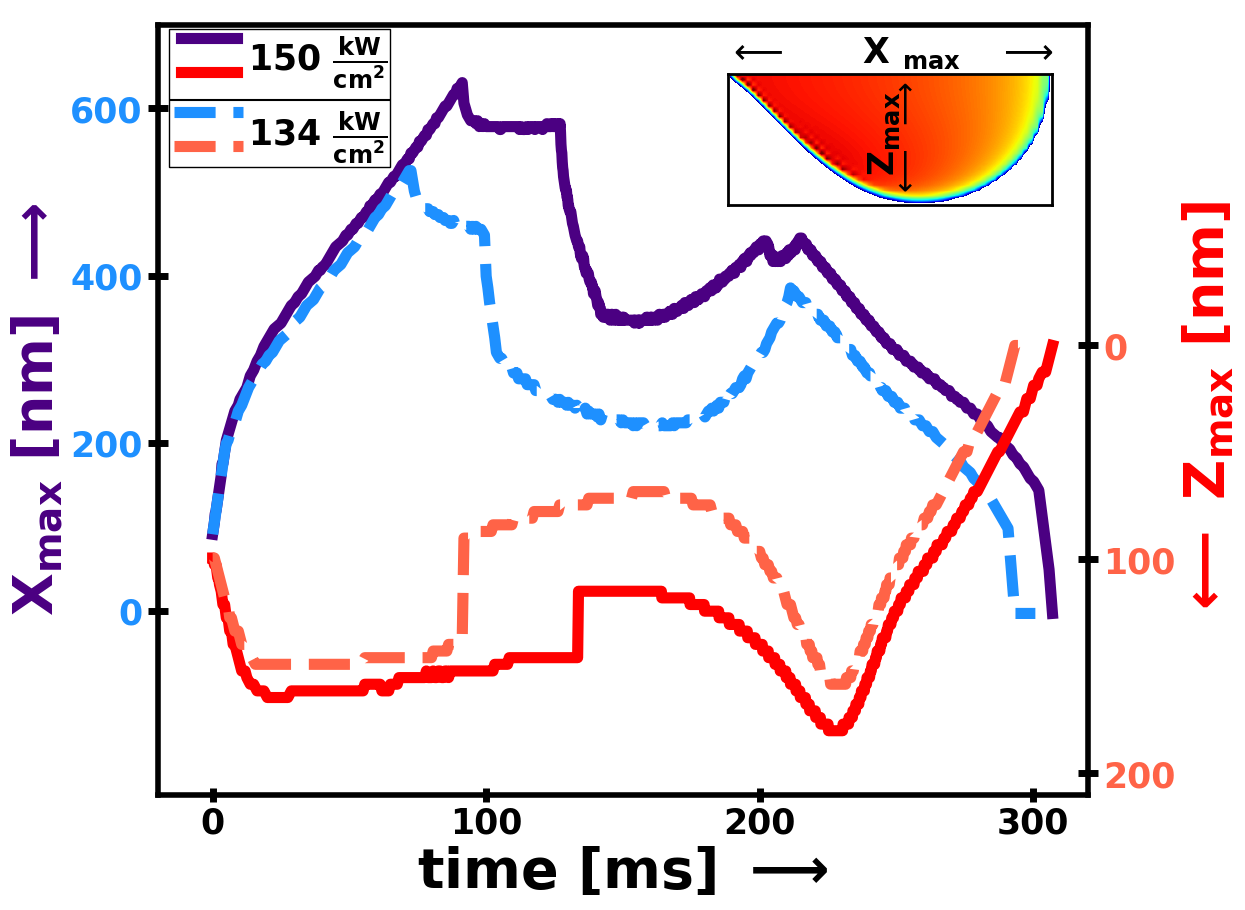

In [65]:
fig, ax1 = plt.subplots(figsize=(12, 10), nrows=1, ncols=1, frameon=False)
ax1.set_facecolor((0, 0, 0, 0))

l1, = ax1.plot(time_ms1, meltpool_width1, color='indigo', linestyle='-', linewidth=8,  label =r'150$\frac{kW}{cm^2}$')
l2, = ax1.plot(time_ms2, meltpool_width2, color='dodgerblue', linestyle='--', linewidth=8, label =r'134$\frac{kW}{cm^2}$') ## time_ms2[4:] find the shape of meltpool_length2 and determine time_ms[:]
ax1.set_yticks([0, 200, 400, 600,], labels=['0', r'200', r'400', r'600',], size=30, rotation=0,  weight='bold')
ax1.set_ylim(-220,700)
ax1.set_xlim(-20,320)
ax1.set_xlabel(r'time [ms] $\mathbf{\longrightarrow}$', color='k', weight='bold', fontsize=40)
ax1.set_xticks([0, 100, 200, 300], labels=['0', '100', '200', '300'], size=25, color='k', weight='bold')
ax1.yaxis.set_tick_params(labelcolor='dodgerblue', labelsize=25)  
ax1.set_ylabel(r'X$\mathbf{_{max}}$ [nm] $\mathbf{\longrightarrow}$', color='indigo', weight='bold', fontsize=40)
# legend1 = ax1.legend(loc=(0.00,0.75), ncol=1, columnspacing=0.5, prop={'weight':'bold', 'size':'25',},handleheight=1,  handletextpad=0.5, handlelength=0.5,  frameon=False).get_frame().set_facecolor('none')


ax2 = ax1.twinx()
d1, = ax2.plot(time_ms1, -meltpool_depth1, color='red', linestyle='-', linewidth=8, label =r'150$\frac{kW}{cm^2}$')
d2, = ax2.plot(time_ms2, -meltpool_depth2, color='tomato', linestyle='--', linewidth=8,  label =r'134$\frac{kW}{cm^2}$')
ax2.set_yticks([0, -100, -200], labels=['0', r'100', r'200'], size=30, rotation=0,  weight='bold')
ax2.set_ylim(-210, 150)
ax2.yaxis.set_tick_params(labelcolor='tomato', labelsize=25)  
ax2.set_ylabel(r'$\mathbf{\longleftarrow}$ Z$\mathbf{_{max}}$ [nm]', color='red', weight='bold', fontsize=40)
# legend2 = ax2.legend(loc=(0.75,0.05), ncol=1, columnspacing=0.5, prop={'weight':'bold', 'size':'25',}, handletextpad=0.5, handlelength=1.9,  frameon=False).get_frame().set_facecolor('none')


# borderpad
# labelspacing
# handlelength
# handleheight
# handletextpad
# borderaxespad
# columnspacing

########## Legend
legend_150 = ax1.legend([l1, d1], ['', ''], loc=(0.01,0.895), handler_map={tuple: HandlerTuple(ndivide=None)}, ncol=1, labelspacing=0.0, columnspacing=0.0, prop={'weight':'bold', 'size':'25',}, handletextpad=4.5, handlelength=1.6,  frameon=False).get_frame().set_facecolor('none')
fig.text(0.20, 0.835, s= r'150 $\mathbf{\frac{kW}{cm^2}}$',  fontsize=25, rotation=0, color='k', weight = 'bold')
legend_134 = ax2.legend([l2, d2], ['', ''], loc=(0.002,0.8), handler_map={tuple: HandlerTuple(ndivide=None)}, ncol=1, labelspacing=0.0, columnspacing=0.0, prop={'weight':'bold', 'size':'25',},  handletextpad=4.5, handlelength=2.0,  frameon=False).get_frame().set_facecolor('none')
fig.text(0.20, 0.76, s= r'134 $\mathbf{\frac{kW}{cm^2}}$',  fontsize=25, rotation=0, color='k', weight = 'bold')
ax1.add_patch(patches.Rectangle((-16, 530), 81, 165, fill=False))
ax1.hlines(y=610, xmin=-16, xmax=65, color='k')


ax3 = fig.add_axes([0.6, 0.69, 0.27, 0.15])  # [left, bottom, width, height]
ax3.set_facecolor((0, 0, 0, 0))
ax3.tick_params(axis='both', labelcolor='black', labelsize=1, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False,)
cmap = plt.get_cmap('jet')
cmap.set_under('white', alpha=0)
hmap3 = ax3.imshow(Au_LIQ1[0:50,235:358,700], cmap=cmap, vmin=0.5, vmax=1.0, interpolation='bilinear')
ax3.set_title('$\longleftarrow$      X $\mathbf{_{max}}$   $\longrightarrow$', fontsize = 25, weight ='bold', pad=8)
ax3.set_ylabel('$\longleftarrow$ $\longrightarrow$', fontsize = 22, weight ='bold', labelpad=-140)
ax3.text(x=52, y=35, s=r'Z$\mathbf{_{max}}$', rotation=90, fontsize=25, weight='bold', color='black')

ax1.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax2.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax1.tick_params(axis='x', direction='inout', which='both', length=10, width=5)

ax1.spines[:].set_linewidth(4)
ax3.spines[:].set_linewidth(2)

# ax1.vlines(x=127, ymin=0, ymax=600)
# ax1.vlines(x=143, ymin=0, ymax=600)

# plt.savefig('for_manuscript/T_u/F6/jpg/d.jpg', bbox_inches='tight')
# plt.savefig('for_manuscript/T_u/F6/d.png', bbox_inches='tight', dpi=800)

plt.show()

In [22]:
max(meltpool_width1), time_ms1[meltpool_width1.argmax(axis=0)], max(meltpool_width2), time_ms2[meltpool_width2.argmax(axis=0)]

(630.7277628032344, 91.25, 525.6064690026953, 71.875)

In [23]:
max(meltpool_depth1), time_ms1[meltpool_depth1.argmax(axis=0)], max(meltpool_depth2), time_ms2[meltpool_depth2.argmax(axis=0)]

(180.12422360248448, 225.15625, 158.38509316770188, 225.9375)

# Lewis Number

Lewis Number (Le) = $\frac{k}{cD\rho}$

Where
c (Sp) : specific heat capacity

D: diffusion coefficient

k: thermal conductivity

$\rho$:mass density

In [17]:
Coeff_FCC =  1e3*12.48*2.67**2/10.21e-6 
Coeff_LIQ =  1e3*9.74*2.8**2/10.21e-6 

def Meltpool_Interface(array, condition, end_time_step):
    condition = condition
    end_step = end_time_step
    leading_front = []
    for t in range(end_step):
        A = array[0:1,:,t][0]
        for i in range(len(A)-1,0,-1):
            if A[i]>=condition:
                # print(i)
                break
        leading_front.append(i)
    return leading_front

def Mat_prop_LIQ(temp):
    k_LIQ = 100+0.027397*temp
    rho_LIQ = 19300-1.44*temp
    Sp_LIQ = 158+5.08e7*np.exp(-0.0114*temp)
    M_LIQ = 3.39e-06*np.exp(-3043/(8.31*temp))
    return k_LIQ,  rho_LIQ,  Sp_LIQ,  M_LIQ, 
    
def Mat_prop_FCC(temp):
    k_SOL = 339-0.0693*temp
    rho_SOL = 19300-1.2*temp
    Sp_SOL = 132-0.011*temp+2.5e-5*temp**2
    M_SOL = 2.03e-06*np.exp(-7501/(8.31*temp))
    return k_SOL, rho_SOL, Sp_SOL, M_SOL

def Phase_mobility_calc(temp):
    factor = 8.58e-10 
    # factor = 1e-9 #Factor taken to make mobility and lewis no realistic 
    Mob_FCC = factor*2.03e-06*np.exp(-7501/(8.31*temp))
    Mob_LIQ = factor*3.39e-06*np.exp(-3043/(8.31*temp))
    return Mob_FCC, Mob_LIQ

def Phase_diffusion_calc(temp):
    factor = 8.58e-10 
    # factor = 1.0e-9 #Factor taken to make mobility and lewis no realistic 
    Diff_FCC = factor*(2.03e-06*np.exp(-7501/(8.31*temp)))*(Coeff_FCC) # mobility * coefficient
    Diff_LIQ = factor*(3.39e-06*np.exp(-3043/(8.31*temp)))*(Coeff_LIQ)
    return Diff_FCC, Diff_LIQ

In [18]:
k_FCC_1,  rho_FCC_1,  Sp_FCC_1,  M_FCC_1, = Mat_prop_FCC(1337)
k_FCC_2,  rho_FCC_2,  Sp_FCC_2,  M_FCC_2, = Mat_prop_FCC(1337)
k_FCC_3,  rho_FCC_3,  Sp_FCC_3,  M_FCC_3, = Mat_prop_FCC(1337)
k_FCC_4,  rho_FCC_4,  Sp_FCC_4,  M_FCC_4, = Mat_prop_FCC(1337)

In [19]:
Thermal_Diff_1 = k_FCC_1/(rho_FCC_1*Sp_FCC_1)
Thermal_Diff_2 = k_FCC_2/(rho_FCC_2*Sp_FCC_2)
Thermal_Diff_3 = k_FCC_3/(rho_FCC_3*Sp_FCC_3)
Thermal_Diff_4 = k_FCC_4/(rho_FCC_4*Sp_FCC_4)

D_phase_1 = Phase_diffusion_calc(FCC_temp1)[0]
D_phase_2 = Phase_diffusion_calc(FCC_temp2)[0]
D_phase_3 = Phase_diffusion_calc(FCC_temp3)[0]
D_phase_4 = Phase_diffusion_calc(FCC_temp4)[0]

In [20]:
Le_M1 = Thermal_Diff_1/D_phase_1
Le_M2 = Thermal_Diff_2/D_phase_2
Le_M3 = Thermal_Diff_3/D_phase_3
Le_M4 = Thermal_Diff_4/D_phase_4

In [21]:
Le_M2[32], Le_M2[228], Le_M3[44], Le_M3[549]

(10.186091652579922, 9.503574144233395, 10.275743240974219, 9.748255095899173)

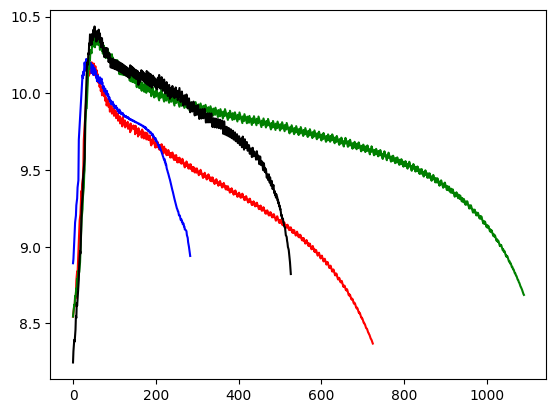

In [22]:
plt.plot(Le_M1[1:], color='red')
plt.plot(Le_M2[1:], color='blue')
plt.plot(Le_M3[1:], color='green')
plt.plot(Le_M4[1:], color='k')

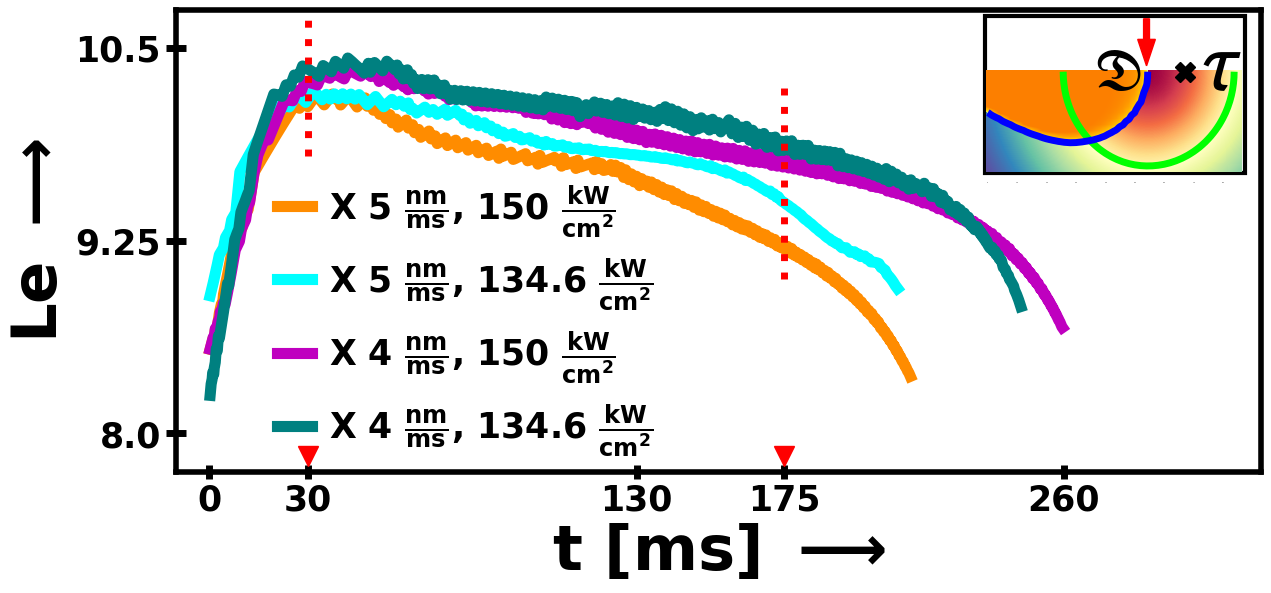

In [23]:
m1=r'X 5 $\mathbf{\frac{nm}{ms}}$, 150 $\mathbf{\frac{kW}{cm^2}}$'
m2=r'X 5 $\mathbf{\frac{nm}{ms}}$, 134.6 $\mathbf{\frac{kW}{cm^2}}$'
m3=r'X 4 $\mathbf{\frac{nm}{ms}}$, 150 $\mathbf{\frac{kW}{cm^2}}$'
m4=r'X 4 $\mathbf{\frac{nm}{ms}}$, 134.6 $\mathbf{\frac{kW}{cm^2}}$'

fig, ax1 = plt.subplots(1,1, figsize=(14,6), frameon=False)
ax1.set_facecolor((0, 0, 0, 0))

ax1.plot(time_ms1[1:t1], Le_M1[1:], color='darkorange', linewidth=8, label=m1)
ax1.plot(time_ms2[1:t2], Le_M2[1:], color='cyan', linewidth=8, label=m2)
ax1.plot(time_ms3[1:t3], Le_M3[1:], color='m', linewidth=8, label=m3)
ax1.plot(time_ms4[1:t4], Le_M4[1:], color='teal', linewidth=8, label=m4)

ax1.legend(loc=(0.08, 0.0), ncol=1,  columnspacing=1.0, prop={'weight':'bold', 'size':'25',}, 
           handletextpad=0.5, handlelength=1.0,   frameon=False)#.get_frame().set_facecolor('none')


ax1.set_yticks([8, 9.25, 10.5], labels=['8.0', '9.25', '10.5'], size=25, color='k', weight='bold')
ax1.set_xticks([0, 30,  130, 175, 260], labels=['0', '30', '130', '175', '260'], size=25, color='k', weight='bold')
ax1.set_ylim(7.75,10.75)
ax1.set_xlim(-10,320)

ax1.set_ylabel(r'Le $\mathbf{\longrightarrow}$', fontsize=45, weight='bold')
ax1.set_xlabel(r't [ms] $\mathbf{\longrightarrow}$', fontsize=45, weight='bold')

#################
ax2 = fig.add_axes([0.68, 0.61, 0.23, 0.24], frameon=False)
ax2.tick_params(axis='x', labelcolor='black', labelsize=0, top=False, bottom=False, labelleft=False)
ax2.tick_params(axis='y', labelcolor='black', labelsize=0, left=False, right=False, labelleft=False)

hmap1 = ax2.imshow(temp2[0:35,160:247,150], cmap='Spectral_r', interpolation='bilinear')
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
meltpool_1 = ax2.imshow(Au_LIQ2[0:35,160:247,150], cmap=cmap, vmin=0.5, vmax=0.9, interpolation='bilinear')
ax2.set_ylim(34,-15)

contour = plt.contour(temp2[0:35, 160:247,150], levels=[1337], colors='lime', linewidths=5,)
contour_LIQ = plt.contour(Au_LIQ2[0:35, 160:247,150], levels=[0.5], colors='blue', linestyles='-', linewidths=5,)
ax2.arrow(54, -18, 0, 16,  width = 2, color='red', length_includes_head=True, clip_on=False) ## 54 = max_temp_pos(214)-160

ax2.plot(67,0, marker='X', color='k', markersize=15, markeredgecolor='k', markerfacecolor='k')
ax2.text(72, 6, s=r'$\mathfrak{\tau}$', fontsize=60, weight = 'bold')
ax2.text(36, 6, s=r'$\mathfrak{D}$', fontsize=40, weight = 'bold')
ax1.add_patch(patches.Rectangle((236, 9.69), 79, 1.02, fill=False, linewidth=3))


# ax1.vlines(x=28, ymin=8, ymax=10.5, linewidth=5, color='k', linestyle='--')

ax1.vlines(x=30, ymin=9.8, ymax=10.7, linewidth=5, color='red', linestyle=':')
# ax1.text(x=17, y=10.5, s=r't$\mathbf{_1}$', fontsize=30, rotation=0, color='k', weight='bold')
ax1.vlines(x=175, ymin=9, ymax=10.3, linewidth=5, color='red', linestyle=':')
# ax1.text(x=160, y=10.1, s=r't$\mathbf{_2}$', fontsize=30, rotation=0, color='k', weight='bold')


ax1.plot(30, 7.85, marker='v', color='red', markersize=15)
ax1.plot(175, 7.85, marker='v', color='red', markersize=15)

ax1.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax1.tick_params(axis='x', direction='inout', which='both', length=10, width=5)

ax1.spines[:].set_linewidth(4)

# plt.savefig('for_manuscript/T_u/F7/jpg/Le.jpg', bbox_inches='tight')
# plt.savefig('for_manuscript/T_u/F7/Le.png', bbox_inches='tight', dpi=800)

plt.show()

# Isotherm-Lead_Lag

In [24]:
def fit_real_time(data, order):
    position, time_lead_lag = data
    coefficients_real = np.polyfit(position, time_lead_lag, order)
    fitted_real_time = np.poly1d(coefficients_real)
    return fitted_real_time

def fit_dt(data, order):
    position, dt = data
    coefficients_dt = np.polyfit(position, dt, order)
    fitted_dt = np.poly1d(coefficients_dt)
    return fitted_dt

def Leading_Front_Cacl(array, condition, end_time_step):
    condition = condition
    end_step = end_time_step
    leading_front = []
    for t in range(end_step):
        A = array[0:1,:,t][0]
        for i in range(len(A)-1,0,-1):
            if A[i]>=condition:
                # print(i)
                break
        leading_front.append(i)
    return leading_front

In [25]:
end_step1 = 801
end_step2 = 306
end_step3 = 1138
end_step4 = 548

Interface_LIQ1 = Leading_Front_Cacl(array=Au_LIQ1[:,:,:end_step1], condition=0.85, end_time_step= end_step1)
Interface_LIQ2 = Leading_Front_Cacl(array=Au_LIQ2[:,:,:end_step2], condition=0.85, end_time_step= end_step2)
Interface_LIQ3 = Leading_Front_Cacl(array=Au_LIQ3[:,:,:end_step3], condition=0.85, end_time_step= end_step3)
Interface_LIQ4 = Leading_Front_Cacl(array=Au_LIQ4[:,:,:end_step4], condition=0.85, end_time_step= end_step4)

In [26]:
Lead_Temp1 = Leading_Front_Cacl(array=temp1[:,:,:end_step1], condition=1337, end_time_step=end_step1)
Lead_Temp2 = Leading_Front_Cacl(array=temp2[:,:,:end_step2], condition=1337, end_time_step=end_step2)
Lead_Temp3 = Leading_Front_Cacl(array=temp3[:,:,:end_step3], condition=1337, end_time_step=end_step3)
Lead_Temp4 = Leading_Front_Cacl(array=temp4[:,:,:end_step4], condition=1337, end_time_step=end_step4)

Lead_LIQ1 = Leading_Front_Cacl(array=Au_LIQ1[:,:,:end_step1], condition=0.85, end_time_step= end_step1)
Lead_LIQ2 = Leading_Front_Cacl(array=Au_LIQ2[:,:,:end_step2], condition=0.85, end_time_step= end_step2)
Lead_LIQ3 = Leading_Front_Cacl(array=Au_LIQ3[:,:,:end_step3], condition=0.85, end_time_step= end_step3)
Lead_LIQ4 = Leading_Front_Cacl(array=Au_LIQ4[:,:,:end_step4], condition=0.85, end_time_step= end_step4)

time_duration1 = np.arange(end_step1)
time_duration2 = np.arange(end_step2)
time_duration3 = np.arange(end_step3)
time_duration4 = np.arange(end_step4)

time_lead_lag1 =  real_time1[:end_step1]
time_lead_lag2 =  real_time2[:end_step2]
time_lead_lag3 =  real_time3[:end_step3]
time_lead_lag4 =  real_time4[:end_step4]

In [27]:
common_position1 = Lead_LIQ1.index(94)
common_position2 = Lead_LIQ2.index(84)
common_position3 = Lead_LIQ3.index(92)
common_position4 = Lead_LIQ4.index(84)


phase_fit_real_time1 = fit_real_time([Lead_LIQ1[1:], time_lead_lag1[1:]], 15)
phase_fit_real_time2 = fit_real_time([Lead_LIQ2[1:], time_lead_lag2[1:]], 15)
phase_fit_real_time3 = fit_real_time([Lead_LIQ3[1:], time_lead_lag3[1:]], 15)
phase_fit_real_time4 = fit_real_time([Lead_LIQ4[1:], time_lead_lag4[1:]], 15)

phase_fit_dt1 = fit_dt([Lead_LIQ1[1:], time_duration1[1:]], 15)
phase_fit_dt2 = fit_dt([Lead_LIQ2[1:], time_duration2[1:]], 15)
phase_fit_dt3 = fit_dt([Lead_LIQ3[1:], time_duration3[1:]], 15)
phase_fit_dt4 = fit_dt([Lead_LIQ4[1:], time_duration4[1:]], 15)

temp_fit_real_time1 = fit_real_time([Lead_Temp1[1:], time_lead_lag1[1:]], 15)
temp_fit_real_time2 = fit_real_time([Lead_Temp2[1:], time_lead_lag2[1:]], 15)
temp_fit_real_time3 = fit_real_time([Lead_Temp3[1:], time_lead_lag3[1:]], 15)
temp_fit_real_time4 = fit_real_time([Lead_Temp4[1:], time_lead_lag4[1:]], 15)

temp_fit_dt1 = fit_dt([Lead_Temp1[1:], time_duration1[1:]], 15)
temp_fit_dt2 = fit_dt([Lead_Temp2[1:], time_duration2[1:]], 15)
temp_fit_dt3 = fit_dt([Lead_Temp3[1:], time_duration3[1:]], 15)
temp_fit_dt4 = fit_dt([Lead_Temp4[1:], time_duration4[1:]], 15)

/tmp/ipykernel_12823/193529333.py:3: RankWarning: Polyfit may be poorly conditioned
  coefficients_real = np.polyfit(position, time_lead_lag, order)
/tmp/ipykernel_12823/193529333.py:3: RankWarning: Polyfit may be poorly conditioned
  coefficients_real = np.polyfit(position, time_lead_lag, order)
/tmp/ipykernel_12823/193529333.py:3: RankWarning: Polyfit may be poorly conditioned
  coefficients_real = np.polyfit(position, time_lead_lag, order)
/tmp/ipykernel_12823/193529333.py:3: RankWarning: Polyfit may be poorly conditioned
  coefficients_real = np.polyfit(position, time_lead_lag, order)
/tmp/ipykernel_12823/193529333.py:9: RankWarning: Polyfit may be poorly conditioned
  coefficients_dt = np.polyfit(position, dt, order)
/tmp/ipykernel_12823/193529333.py:9: RankWarning: Polyfit may be poorly conditioned
  coefficients_dt = np.polyfit(position, dt, order)
/tmp/ipykernel_12823/193529333.py:9: RankWarning: Polyfit may be poorly conditioned
  coefficients_dt = np.polyfit(position, dt, ord

In [28]:
T_end_dt1 = Lead_Temp1.index(370)+1 # dt at which thermal front reach end of specimen 
T_end_dt2 = Lead_Temp2.index(370)+1
T_end_dt3 = Lead_Temp3.index(370)+1
T_end_dt4 = Lead_Temp4.index(370)+1

T_slope0_dt1 = 760 # dt at which thermal front's slope is flat, and no change in time occurs as it has reached end of specimen (first put end time and calculate 'lag_time' and then find np.argmax(lag_time) for exact value)
T_slope0_dt2 = 292
T_slope0_dt3 = 1104
T_slope0_dt4 = 532


lag_time1 = []
for t in range(end_step1):
    if t>=T_slope0_dt1:
        lag_time1.append(phase_fit_real_time1(Lead_LIQ1[t]) - temp_fit_real_time1(Lead_LIQ1[T_slope0_dt1]))
    else:
        lag_time1.append(phase_fit_real_time1(Lead_LIQ1[t]) - temp_fit_real_time1(Lead_LIQ1[t]))

lag_time2 = []
for t in range(end_step2):
    if t>=T_slope0_dt2:
        lag_time2.append(phase_fit_real_time2(Lead_LIQ2[t]) - temp_fit_real_time2(Lead_LIQ2[T_slope0_dt2]))
    else:
        lag_time2.append(phase_fit_real_time2(Lead_LIQ2[t]) - temp_fit_real_time2(Lead_LIQ2[t]))

lag_time3 = []
for t in range(end_step3):
    if t>=T_slope0_dt3:
        lag_time3.append(phase_fit_real_time3(Lead_LIQ3[t]) - temp_fit_real_time3(Lead_LIQ3[T_slope0_dt3]))
    else:
        lag_time3.append(phase_fit_real_time3(Lead_LIQ3[t]) - temp_fit_real_time3(Lead_LIQ3[t]))

lag_time4 = []
for t in range(end_step4):
    if t>=T_slope0_dt4:
        lag_time4.append(phase_fit_real_time4(Lead_LIQ4[t]) - temp_fit_real_time4(Lead_LIQ4[T_slope0_dt4]))
    else:
        lag_time4.append(phase_fit_real_time4(Lead_LIQ4[t]) - temp_fit_real_time4(Lead_LIQ4[t]))


#### Model 1
#### I 150 v 5

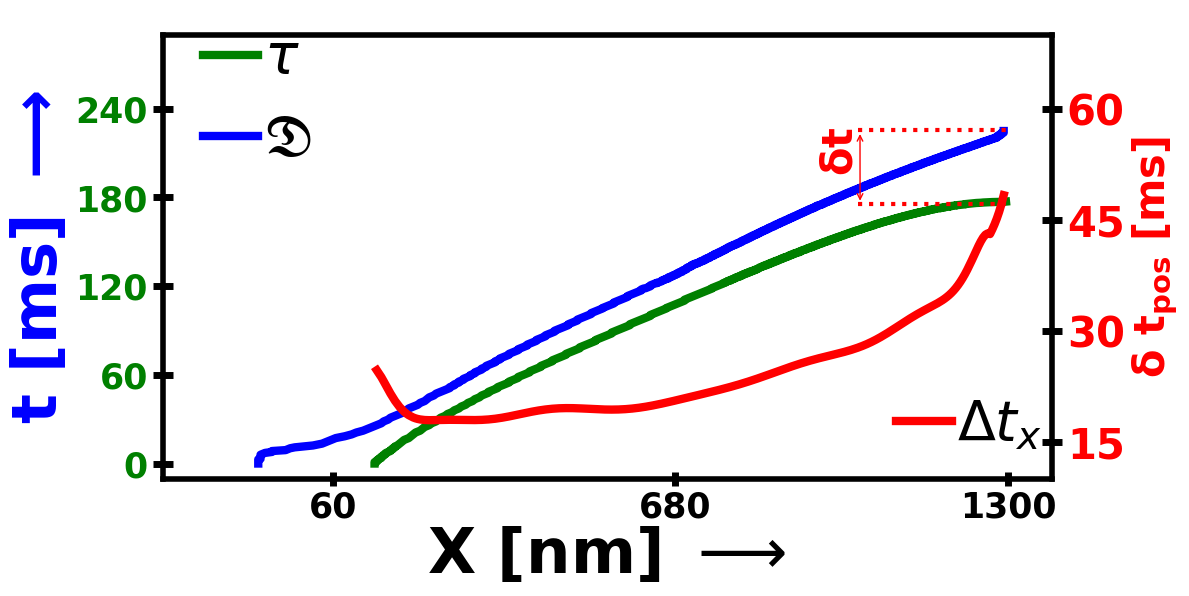

In [24]:
t_step = 800


fig, (ax1) = plt.subplots(1, 1, figsize=(12,6), frameon=False)
ax1.set_facecolor((0, 0, 0, 0))

if t_step>=T_end_dt1:
    ax1.plot(Lead_Temp1[1:T_end_dt1], time_lead_lag1[1:T_end_dt1], marker='o', c='green',markersize=1, linewidth=6, label =r'$\tau$')
else:
    ax1.plot(Lead_Temp1[1:t_step], time_lead_lag1[1:t_step], marker='o', c='green',markersize=1, linewidth=6, label =r'$\tau$')
    
ax1.plot(Lead_LIQ1[1:t_step], time_lead_lag1[1:t_step], marker='.', c='blue',markersize=1,linewidth=6, label =r'$\mathfrak{D}$')

ax1.set_ylabel("t [ms] $\mathbf{\longrightarrow}$",  weight = 'bold', size=45,  color='blue')
ax1.set_xlabel(r"X [nm] $\longrightarrow$", weight='bold', size=45, color='k', labelpad=1, ha='center')
ax1.set_xticks([75, 225, 371], labels=['60', '680', '1300'], size=25, color='k', weight='bold')
ax1.yaxis.set_tick_params(labelcolor='green', labelsize=25, pad=3,)
for label in ax1.get_yticklabels(): label.set_fontweight('bold')

if t_step>=common_position1:
    ax1.hlines(y=phase_fit_real_time1(Lead_LIQ1[t_step]), xmax=Lead_LIQ1[t_step], xmin=Lead_LIQ1[t_step]-65, linewidth=3, linestyle=':', color='red')
    if t_step>=T_slope0_dt1:
        ax1.hlines(y=temp_fit_real_time1(Lead_LIQ1[T_slope0_dt1]), xmax=Lead_LIQ1[t_step], xmin=Lead_LIQ1[t_step]-65,  linewidth=3, linestyle=':', color='red')
        # ax1.vlines(x=Lead_LIQ1[t_step],  ymin=temp_fit_real_time1(Lead_LIQ1[T_slope0_dt1])+1, ymax=phase_fit_real_time1(Lead_LIQ1[t_step]), linestyle='-', color='k', linewidth=2)
        ax1.text(x=Lead_LIQ1[t_step]-82, y= np.mean([phase_fit_real_time1(Lead_LIQ1[t_step]), temp_fit_real_time1(Lead_LIQ1[T_slope0_dt1])]), s=r"$\mathbf{\delta}$t", color='red', fontsize=30, rotation=90, weight='bold')
        ax1.annotate(text=' ', xy=(Lead_LIQ1[t_step]-65+1,temp_fit_real_time1(Lead_LIQ1[T_slope0_dt1])), xytext=(Lead_LIQ1[t_step]-65, phase_fit_real_time1(Lead_LIQ1[t_step])+3), arrowprops=dict(arrowstyle='<->', color='red'), )
    else:
        ax1.hlines(y=temp_fit_real_time1(Lead_LIQ1[t_step]), xmax=Lead_LIQ1[t_step], xmin=Lead_LIQ1[t_step]-65, linewidth=3, linestyle=':', color='red')
        # ax1.vlines(x=Lead_LIQ1[t_step],  ymin=temp_fit_real_time1(Lead_LIQ1[t_step])+1, ymax=phase_fit_real_time1(Lead_LIQ1[t_step]), linestyle='-', color='k', linewidth=2)
        ax1.text(x=Lead_LIQ1[t_step]-82, y=np.mean([phase_fit_real_time1(Lead_LIQ1[t_step]), temp_fit_real_time1(Lead_LIQ1[t_step])]), s=r"$\mathbf{\delta}$t", color='red', fontsize=30, rotation=90, weight='bold')
        ax1.annotate(text=' ', xy=(Lead_LIQ1[t_step]-65+1, temp_fit_real_time1(Lead_LIQ1[t_step])), xytext=(Lead_LIQ1[t_step]-65,phase_fit_real_time1(Lead_LIQ1[t_step])+3), arrowprops=dict(arrowstyle='<->', color='red'))

ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_ylim([-10,290])
ax1.set_xlim([00,380])
legend_1 = ax1.legend(loc=(0.02,0.65), prop={'weight':'bold', 'size':'40',}, handletextpad=0.1, handlelength=1.0,   frameon=False).get_frame().set_facecolor('none')

ax2 = ax1.twinx()
if t_step>common_position1:
    ax2.plot(Lead_LIQ1[common_position1:t_step],lag_time1[common_position1:t_step],   c='red', linewidth=6, label =r'$\Delta t_{x}$') # positional_timelag

legend_2 = ax2.legend(loc=(0.80,0.01), prop={'weight':'bold', 'size':'40',}, handletextpad=0.1, handlelength=1.0, frameon=False).get_frame().set_facecolor('none')

ax2.set_ylabel("$\mathbf{\delta}$ t$\mathbf{_{pos}}$ [ms]",  weight = 'bold', size=30, color='red')
ax2.yaxis.set_tick_params(labelcolor='red', labelsize=30)  
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
for label in ax2.get_yticklabels(): label.set_fontweight('bold')
ax2.set_ylim([10,70])
ax2.set_xlim([0,390])

ax1.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax2.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax1.tick_params(axis='x', direction='inout', which='both', length=10, width=5)

ax1.spines[:].set_linewidth(4)

plt.tight_layout()

# plt.savefig('for_manuscript/T_u/F7/jpg/m1.jpg', bbox_inches='tight')
# plt.savefig('for_manuscript/T_u/F7/m1.png', bbox_inches='tight', dpi=800)

plt.show()

##### t=30ms

In [ ]:
Le_M1[40]

/tmp/ipykernel_21354/2663971778.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


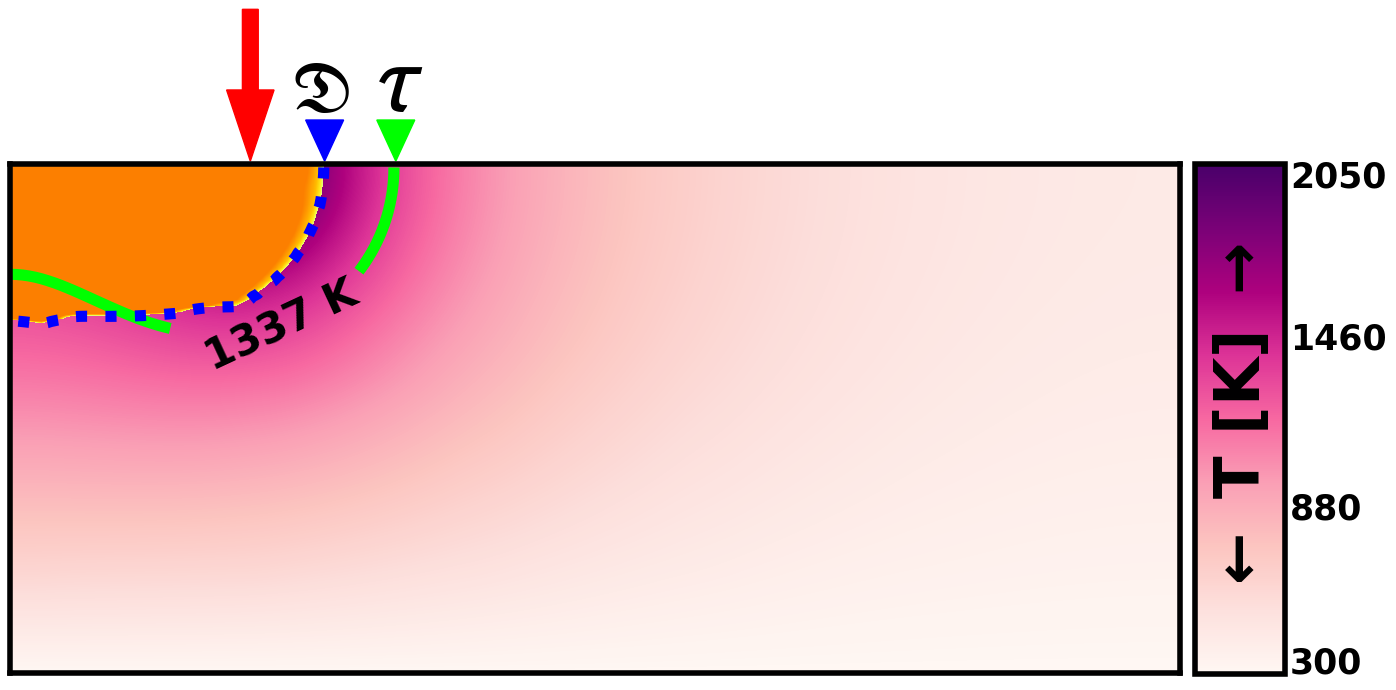

In [194]:
t_step = 40
if t_step>=end_step1:
    t_step=end_step1-1
    
scan_speed = '5' # nano meter per micro sec ==> 5e-4 * t (1e-7m / 1e-9s)
irradiance = r"150 $\mathbf{\frac{kW}{cm^2}}$"

max_temp = round(temp1[:,:,t_step].max())
max_temp_pos = np.unravel_index(np.argmax(temp1[:,:,t_step]), temp1[:,:,t_step].shape)
####################################################
x = np.arange(time_steps1-1)

fig, ax1 = plt.subplots(1, 1, figsize=[12, 8], frameon=False) #figsize=[8, 10])
hmap1 = ax1.imshow(temp1[:,:,t_step], cmap='RdPu', interpolation='bilinear')
ax1.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

############### Arrow #########################
ax1.arrow(max_temp_pos[1], -50, 0, 48,  width = 5, color='red', length_includes_head=True, clip_on=False)

ax1.set_ylim(160, -1)
ax1.set_xlim(0,370)
# ##############################################

################## Meltpool and Isotherm ################
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
meltpool_1 = ax1.imshow(Au_LIQ1[:,:,t_step], cmap=cmap, vmin=0.85, vmax=0.89, interpolation='bilinear')

ax1.arrow(Lead_Temp1[t_step]+1, -15, 0, 13,  width = 10, head_width=12, head_length=13, color='lime', length_includes_head=True, clip_on=False)
ax1.text(Lead_Temp1[t_step]-6, -18, s=r'$\mathfrak{\tau}$', fontsize=70, weight = 'bold')
ax1.arrow(Lead_LIQ1[t_step]+0.5, -15, 0, 13,  width = 10, head_width=12,  head_length=13,  color='b', length_includes_head=True, clip_on=False)
ax1.text(Lead_LIQ1[t_step]-10, -18, s=r'$\mathfrak{D}$', fontsize=50, weight = 'bold')


################# Contour ##################
contour_levels = [1337]
contour = plt.contour(temp1[:, :, t_step], levels=contour_levels, colors='lime', linewidths=8,)
clabels = plt.clabel(contour, inline=True, fontsize=30, colors='k', fmt=' %1.0f K ')
for label in clabels: label.set_fontweight('bold')

contour_level_LIQ = [0.85]
contour_LIQ = plt.contour(Au_LIQ1[:, :, t_step], levels=contour_level_LIQ, colors='blue', linestyles=':', linewidths=8,)
############## Color Bar ###########
ax2 = fig.add_axes([1.0, 0.17, 0.075, 0.637]) # [left, bottom, width, height]
ax2.tick_params(axis='both', labelcolor='black', labelsize=1, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
cbar = fig.colorbar(hmap1, cax=ax2, orientation='vertical')
cbar.ax.tick_params(labelsize=25,direction='in', length=0) 
cbar.set_ticks([300+50, 880, 1460, max_temp-30],labels=['300', '880', '1460',  f'{max_temp+3}'], weight='bold') 
cbar.set_label(r'$\mathbf{{\leftarrow}}$ T $\mathbf{[K]}$ ${\mathbf{\rightarrow}}$', color='k',  labelpad=-125, fontsize=45, rotation=90, weight='bold')


ax1.spines[:].set_linewidth(4)
ax2.spines[:].set_linewidth(4)

plt.tight_layout()

# plt.savefig('for_manuscript/T_u/F7/jpg/m1_150_5_30_L10_11.jpg', bbox_inches='tight')
# plt.savefig('for_manuscript/T_u/F7/m1_150_5_30_L10_11.png', bbox_inches='tight', dpi=800)
plt.show()

##### t=175ms

/tmp/ipykernel_21354/3693952782.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


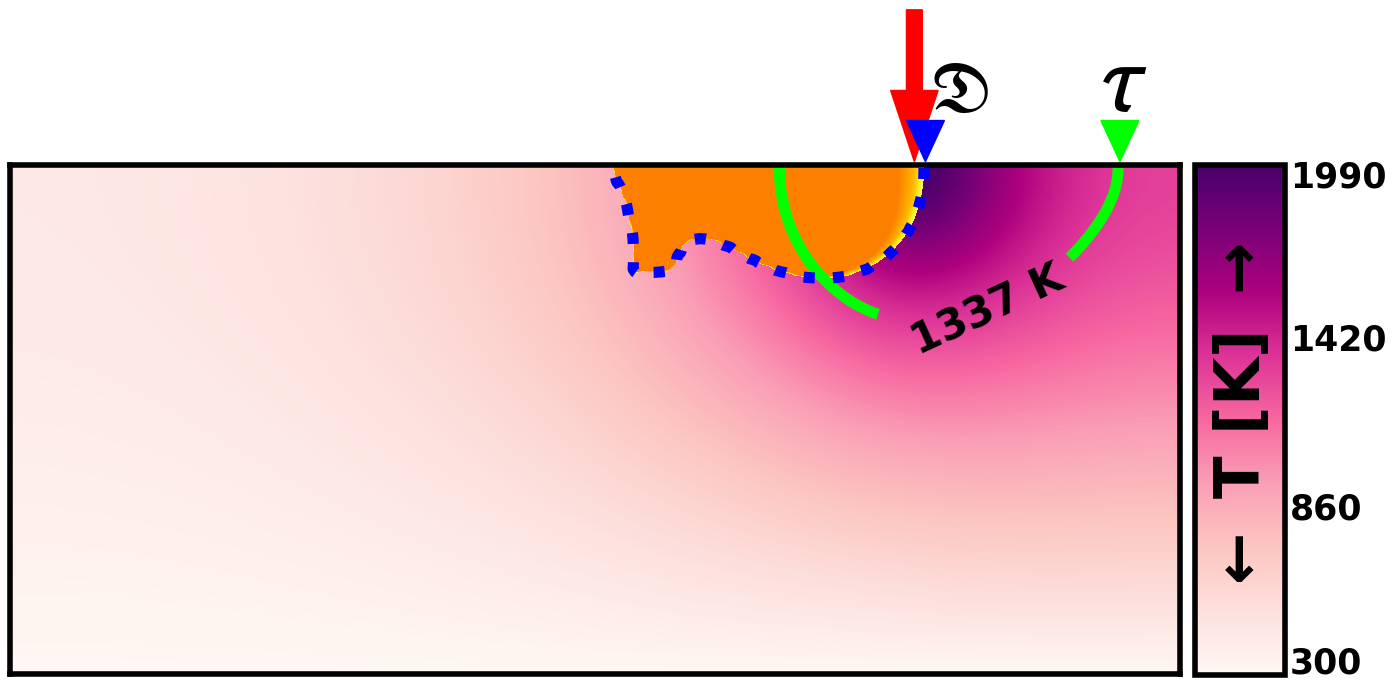

In [203]:
t_step = 480
if t_step>=end_step1:
    t_step=end_step1-1
    
scan_speed = '5' # nano meter per micro sec ==> 5e-4 * t (1e-7m / 1e-9s)
irradiance = r"150 $\mathbf{\frac{kW}{cm^2}}$"

max_temp = round(temp1[:,:,t_step].max())
max_temp_pos = np.unravel_index(np.argmax(temp1[:,:,t_step]), temp1[:,:,t_step].shape)
####################################################
x = np.arange(time_steps1-1)

fig, ax1 = plt.subplots(1, 1, figsize=[12, 8], frameon=False) #figsize=[8, 10])
hmap1 = ax1.imshow(temp1[:,:,t_step], cmap='RdPu', interpolation='bilinear') # 'Spectral_r'
ax1.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

############### Arrow #########################
ax1.arrow(max_temp_pos[1], -50, 0, 48,  width = 5, color='red', length_includes_head=True, clip_on=False)

ax1.set_ylim(160, -1)
ax1.set_xlim(0,370)
# ##############################################

################## Meltpool and Isotherm ################
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
meltpool_1 = ax1.imshow(Au_LIQ1[:,:,t_step], cmap=cmap, vmin=0.85, vmax=0.89, interpolation='bilinear')

ax1.arrow(Lead_Temp1[t_step]+1, -15, 0, 13,  width = 10, head_width=12, head_length=13, color='lime', length_includes_head=True, clip_on=False)
ax1.text(Lead_Temp1[t_step]-6, -18, s=r'$\mathfrak{\tau}$', fontsize=70, weight = 'bold')
ax1.arrow(Lead_LIQ1[t_step]+0.5, -15, 0, 13,  width = 10, head_width=12,  head_length=13,  color='b', length_includes_head=True, clip_on=False)
ax1.text(Lead_LIQ1[t_step]+2, -18, s=r'$\mathfrak{D}$', fontsize=50, weight = 'bold')

################# Contour ##################
contour_levels = [1337]
contour = plt.contour(temp1[:, :, t_step], levels=contour_levels, colors='lime', linewidths=8,)
clabels = plt.clabel(contour, inline=True, fontsize=30, colors='k', fmt=' %1.0f K ')
for label in clabels: label.set_fontweight('bold')

contour_level_LIQ = [0.85]
contour_LIQ = plt.contour(Au_LIQ1[:, :, t_step], levels=contour_level_LIQ, colors='blue', linestyles=':', linewidths=8,)

############## Color Bar ###########
ax2 = fig.add_axes([1.0, 0.17, 0.075, 0.637]) # [left, bottom, width, height]
ax2.tick_params(axis='both', labelcolor='black', labelsize=1, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
cbar = fig.colorbar(hmap1, cax=ax2, orientation='vertical')
cbar.ax.tick_params(labelsize=25,direction='in', length=0) 
cbar.set_ticks([300+50, 860, 1420, max_temp-30],labels=['300', '860', '1420',  f'{max_temp+2}'], weight='bold') 
cbar.set_label(r'$\mathbf{{\leftarrow}}$ T $\mathbf{[K]}$ ${\mathbf{\rightarrow}}$', color='k',  labelpad=-125, fontsize=45, rotation=90, weight='bold')

ax1.spines[:].set_linewidth(4)
ax2.spines[:].set_linewidth(4)

plt.tight_layout()

# plt.savefig('for_manuscript/T_u/F7/jpg/m1_150_5_175_L_9_20.jpg', bbox_inches='tight')
# plt.savefig('for_manuscript/T_u/F7/m1_150_5_175_L_9_20.png', bbox_inches='tight', dpi=800)
plt.show()

#### Model 2
#### I 134.6 v 5

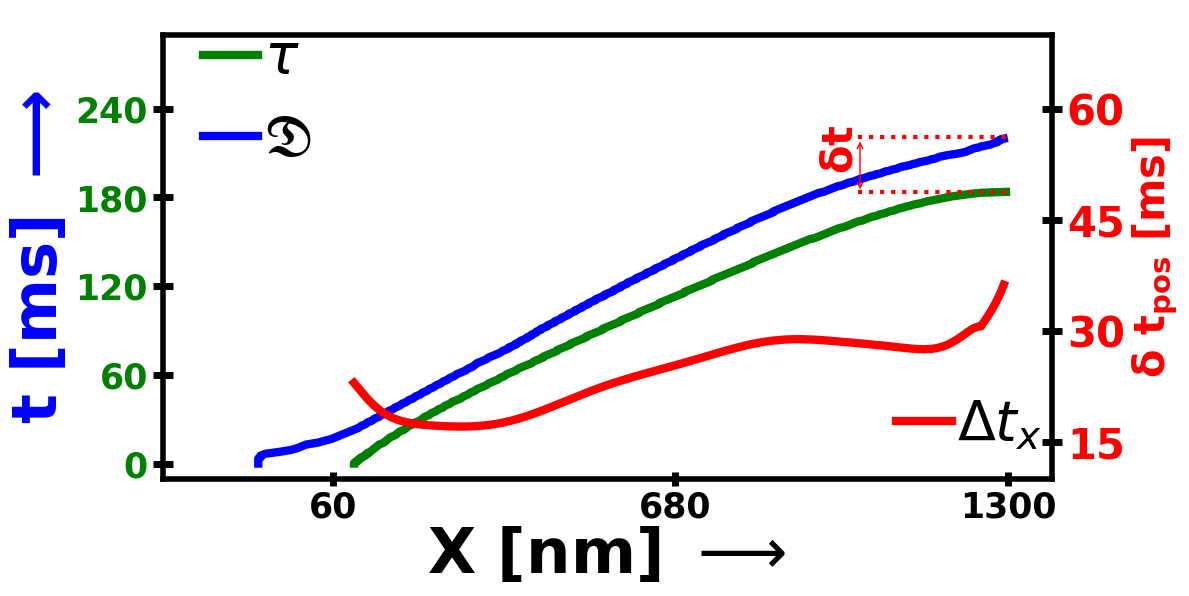

In [29]:
t_step = 305


fig, (ax1) = plt.subplots(1, 1, figsize=(12,6), frameon=False)
ax1.set_facecolor((0, 0, 0, 0))

if t_step>=T_end_dt2:
    ax1.plot(Lead_Temp2[1:T_end_dt2], time_lead_lag2[1:T_end_dt2], marker='o', c='green',markersize=1, linewidth=6, label =r'$\tau$')
else:
    ax1.plot(Lead_Temp2[1:t_step], time_lead_lag2[1:t_step], marker='o', c='green',markersize=1, linewidth=6, label =r'$\tau$')
    
ax1.plot(Lead_LIQ2[1:t_step], time_lead_lag2[1:t_step], marker='.', c='blue',markersize=1,linewidth=6, label =r'$\mathfrak{D}$')

ax1.set_ylabel("t [ms] $\mathbf{\longrightarrow}$",  weight = 'bold', size=45,  color='blue')
ax1.set_xlabel(r"X [nm] $\longrightarrow$", weight='bold', size=45, color='k', labelpad=1, ha='center')
ax1.set_xticks([75, 225, 371], labels=['60', '680', '1300'], size=25, color='k', weight='bold')
ax1.yaxis.set_tick_params(labelcolor='green', labelsize=25, pad=3,)
for label in ax1.get_yticklabels(): label.set_fontweight('bold')

if t_step>=common_position2:
    ax1.hlines(y=phase_fit_real_time2(Lead_LIQ2[t_step]), xmax=Lead_LIQ2[t_step], xmin=Lead_LIQ2[t_step]-65, linewidth=3, linestyle=':', color='red')
    if t_step>=T_slope0_dt2:
        ax1.hlines(y=temp_fit_real_time2(Lead_LIQ2[T_slope0_dt2]), xmax=Lead_LIQ2[t_step], xmin=Lead_LIQ2[t_step]-65,  linewidth=3, linestyle=':', color='red')
        # ax1.vlines(x=Lead_LIQ2[t_step],  ymin=temp_fit_real_time2(Lead_LIQ2[T_slope0_dt2])+1, ymax=phase_fit_real_time2(Lead_LIQ2[t_step]), linestyle='-', color='k', linewidth=2)
        ax1.text(x=Lead_LIQ2[t_step]-82, y= np.mean([phase_fit_real_time2(Lead_LIQ2[t_step]), temp_fit_real_time2(Lead_LIQ2[T_slope0_dt2])]), s=r"$\mathbf{\delta}$t", color='red', fontsize=30, rotation=90, weight='bold')
        ax1.annotate(text=' ', xy=(Lead_LIQ2[t_step]-65+1,temp_fit_real_time2(Lead_LIQ2[T_slope0_dt2])), xytext=(Lead_LIQ2[t_step]-65, phase_fit_real_time2(Lead_LIQ2[t_step])+3), arrowprops=dict(arrowstyle='<->', color='red'), )
    else:
        ax1.hlines(y=temp_fit_real_time2(Lead_LIQ2[t_step]), xmax=Lead_LIQ2[t_step], xmin=Lead_LIQ2[t_step]-65, linewidth=3, linestyle=':', color='red')
        # ax1.vlines(x=Lead_LIQ2[t_step],  ymin=temp_fit_real_time2(Lead_LIQ2[t_step])+1, ymax=phase_fit_real_time2(Lead_LIQ2[t_step]), linestyle='-', color='k', linewidth=2)
        ax1.text(x=Lead_LIQ2[t_step]-82, y=np.mean([phase_fit_real_time2(Lead_LIQ2[t_step]), temp_fit_real_time2(Lead_LIQ2[t_step])]), s=r"$\mathbf{\delta}$t", color='red', fontsize=30, rotation=90, weight='bold')
        ax1.annotate(text=' ', xy=(Lead_LIQ2[t_step]-65+1, temp_fit_real_time2(Lead_LIQ2[t_step])), xytext=(Lead_LIQ2[t_step]-65,phase_fit_real_time2(Lead_LIQ2[t_step])+3), arrowprops=dict(arrowstyle='<->', color='red'))

ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_ylim([-10,290])
ax1.set_xlim([00,380])
legend_1 = ax1.legend(loc=(0.02,0.65), prop={'weight':'bold', 'size':'40',}, handletextpad=0.1, handlelength=1.0,   frameon=False).get_frame().set_facecolor('none')

ax2 = ax1.twinx()
if t_step>common_position2:
    ax2.plot(Lead_LIQ2[common_position2:t_step],lag_time2[common_position2:t_step],   c='red', linewidth=6, label =r'$\Delta t_{x}$') # positional_timelag

legend_2 = ax2.legend(loc=(0.80,0.01), prop={'weight':'bold', 'size':'40',}, handletextpad=0.1, handlelength=1.0, frameon=False).get_frame().set_facecolor('none')

ax2.set_ylabel("$\mathbf{\delta}$ t$\mathbf{_{pos}}$ [ms]",  weight = 'bold', size=30, color='red')
ax2.yaxis.set_tick_params(labelcolor='red', labelsize=30)  
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
for label in ax2.get_yticklabels(): label.set_fontweight('bold')
ax2.set_ylim([10,70])
ax2.set_xlim([0,390])

ax1.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax2.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax1.tick_params(axis='x', direction='inout', which='both', length=10, width=5)

ax1.spines[:].set_linewidth(4)


plt.tight_layout()

# plt.savefig('for_manuscript/T_u/F7/jpg/m2.jpg', bbox_inches='tight')
# plt.savefig('for_manuscript/T_u/F7/m2.png', bbox_inches='tight', dpi=800)

plt.show()

##### t=30ms

/tmp/ipykernel_12823/3309647763.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


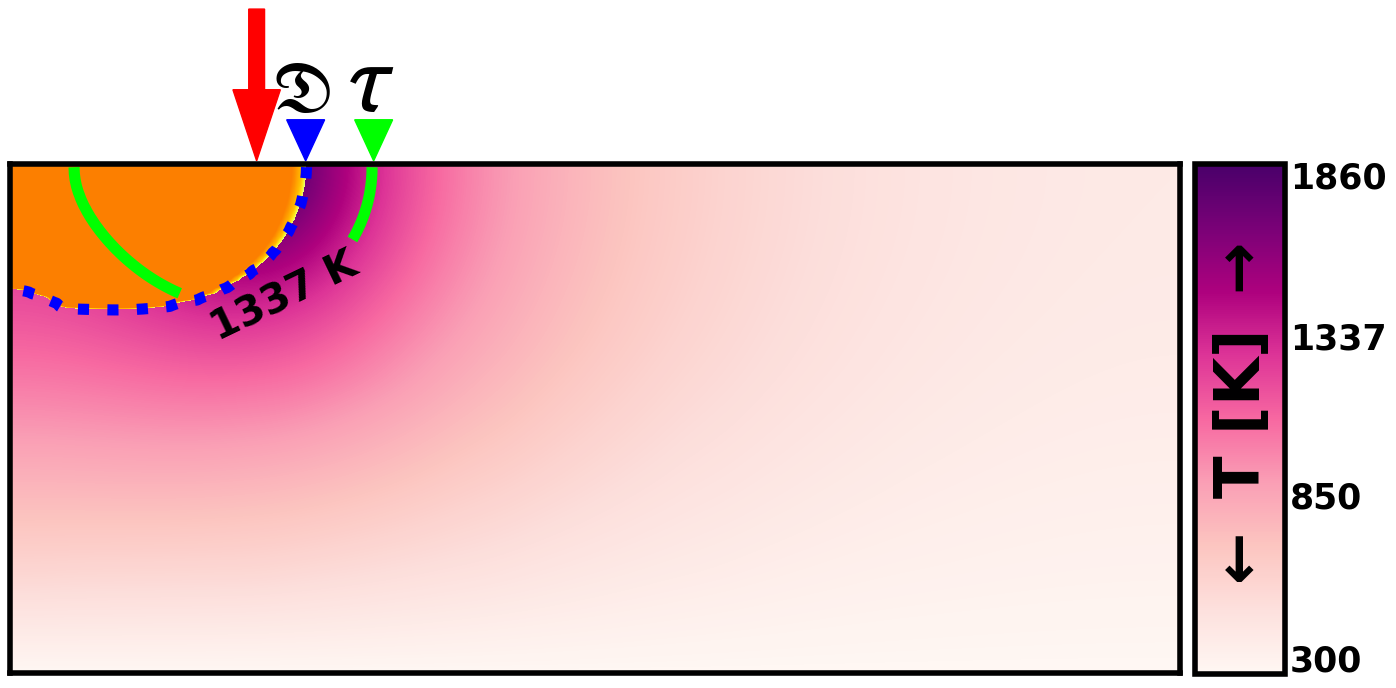

In [30]:
t_step = 32
if t_step>=end_step2:
    t_step=end_step2-1
    
scan_speed = '5' # nano meter per micro sec ==> 5e-4 * t (1e-7m / 1e-9s)
irradiance = r"134.6 $\mathbf{\frac{kW}{cm^2}}$"

max_temp = round(temp2[:,:,t_step].max())
max_temp_pos = np.unravel_index(np.argmax(temp2[:,:,t_step]), temp2[:,:,t_step].shape)

####################################################
x = np.arange(time_steps2-1)

fig, ax1 = plt.subplots(1, 1, figsize=[12, 8], frameon=False) #figsize=[8, 10])
hmap1 = ax1.imshow(temp2[:,:,t_step], cmap='RdPu', interpolation='bilinear')
ax1.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

############### Arrow #########################
ax1.arrow(max_temp_pos[1], -50, 0, 48,  width = 5, color='red', length_includes_head=True, clip_on=False)

ax1.set_ylim(160, -1)
ax1.set_xlim(0,370)
# ##############################################

################## Meltpool and Isotherm ################
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
meltpool_1 = ax1.imshow(Au_LIQ2[:,:,t_step], cmap=cmap, vmin=0.85, vmax=0.89, interpolation='bilinear')

ax1.arrow(Lead_Temp2[t_step]+1, -15, 0, 13,  width = 10, head_width=12, head_length=13, color='lime', length_includes_head=True, clip_on=False)
ax1.text(Lead_Temp2[t_step]-8, -18, s=r'$\mathfrak{\tau}$', fontsize=70, weight = 'bold')
ax1.arrow(Lead_LIQ2[t_step]+0.5, -15, 0, 13,  width = 10, head_width=12,  head_length=13,  color='b', length_includes_head=True, clip_on=False)
ax1.text(Lead_LIQ2[t_step]-10, -18, s=r'$\mathfrak{D}$', fontsize=50, weight = 'bold')

################# Contour ##################
contour_levels = [1337]
contour = plt.contour(temp2[:, :, t_step], levels=contour_levels, colors='lime', linewidths=8,)
clabels = plt.clabel(contour, inline=True, fontsize=29, colors='k', fmt=' %1.0f K ')
for label in clabels: label.set_fontweight('bold')

contour_level_LIQ = [0.85]
contour_LIQ = plt.contour(Au_LIQ2[:, :, t_step], levels=contour_level_LIQ, colors='blue', linestyles=':', linewidths=8,)

############## Color Bar ###########
ax2 = fig.add_axes([1.0, 0.17, 0.075, 0.637])
ax2.tick_params(axis='both', labelcolor='black', labelsize=1, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
cbar = fig.colorbar(hmap1, cax=ax2, orientation='vertical')
cbar.ax.tick_params(labelsize=25,direction='in', length=0) 
cbar.set_ticks([300+50, 850, 1337, max_temp-30],labels=['300', '850', '1337',  f'{max_temp}'], weight='bold') 
cbar.set_label(r'$\mathbf{{\leftarrow}}$ T $\mathbf{[K]}$ ${\mathbf{\rightarrow}}$', color='k',  labelpad=-125, fontsize=45, rotation=90, weight='bold')
ax1.spines[:].set_linewidth(4)
ax2.spines[:].set_linewidth(4)



plt.tight_layout()

# plt.savefig('for_manuscript/T_u/F7/jpg/m2_134_5_30_L_10_18.jpg', bbox_inches='tight')
# plt.savefig('for_manuscript/T_u/F7/m2_134_5_30_L_10_18.png', bbox_inches='tight', dpi=800)

plt.show()

##### t=175ms

/tmp/ipykernel_12823/2657869487.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


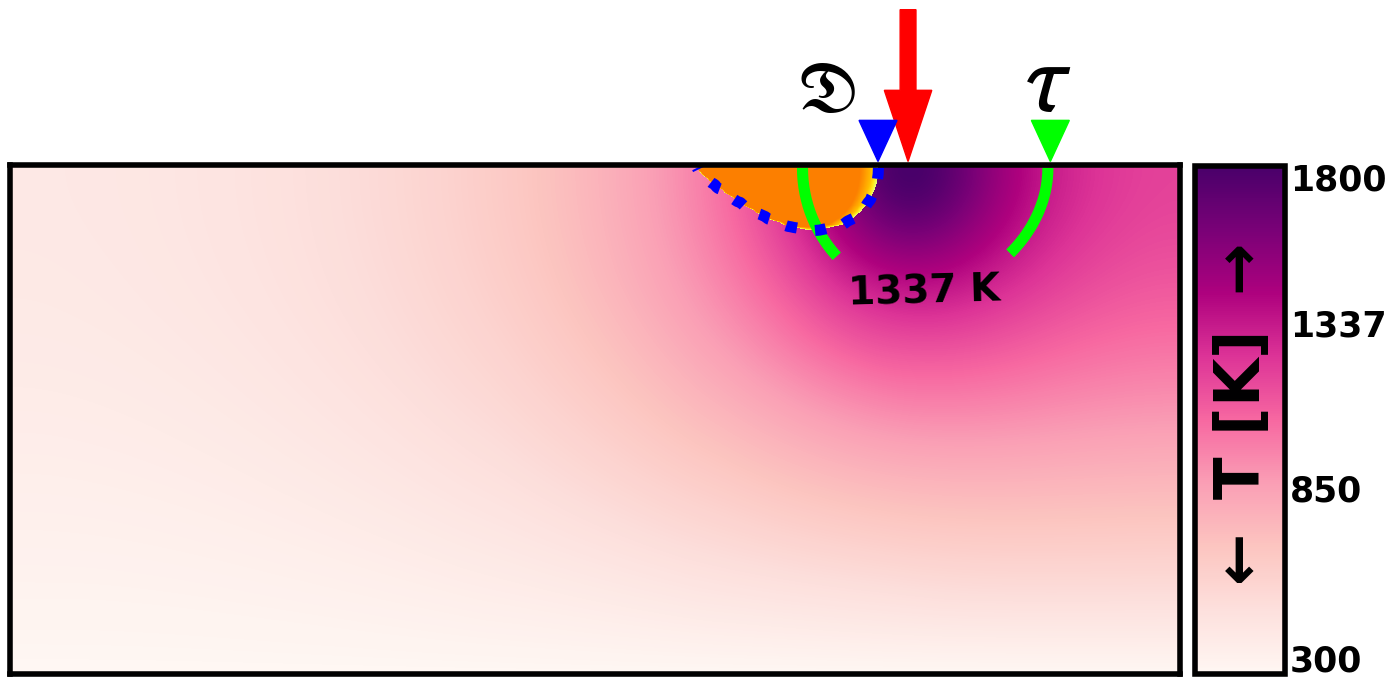

In [31]:
t_step = 228
if t_step>=end_step2:
    t_step=end_step2-1
    
scan_speed = '5' # nano meter per micro sec ==> 5e-4 * t (1e-7m / 1e-9s)
irradiance = r"134.6 $\mathbf{\frac{kW}{cm^2}}$"

max_temp = round(temp2[:,:,t_step].max())
max_temp_pos = np.unravel_index(np.argmax(temp2[:,:,t_step]), temp2[:,:,t_step].shape)

####################################################
x = np.arange(time_steps2-1)

fig, ax1 = plt.subplots(1, 1, figsize=[12, 8], frameon=False) #figsize=[8, 10])
hmap1 = ax1.imshow(temp2[:,:,t_step], cmap='RdPu', interpolation='bilinear')
ax1.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

############### Arrow #########################
ax1.arrow(max_temp_pos[1], -50, 0, 48,  width = 5, color='red', length_includes_head=True, clip_on=False)

ax1.set_ylim(160, -1)
ax1.set_xlim(0,370)
# ##############################################

################## Meltpool and Isotherm ################
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
meltpool_1 = ax1.imshow(Au_LIQ2[:,:,t_step], cmap=cmap, vmin=0.85, vmax=0.89, interpolation='bilinear')

ax1.arrow(Lead_Temp2[t_step]+1, -15, 0, 13,  width = 10, head_width=12, head_length=13, color='lime', length_includes_head=True, clip_on=False)
ax1.text(Lead_Temp2[t_step]-8, -18, s=r'$\mathfrak{\tau}$', fontsize=70, weight = 'bold')
ax1.arrow(Lead_LIQ2[t_step]+0.5, -15, 0, 13,  width = 10, head_width=12,  head_length=13,  color='b', length_includes_head=True, clip_on=False)
ax1.text(Lead_LIQ2[t_step]-25, -18, s=r'$\mathfrak{D}$', fontsize=50, weight = 'bold')

################# Contour ##################
contour_levels = [1337]
contour = plt.contour(temp2[:, :, t_step], levels=contour_levels, colors='lime', linewidths=8,)
clabels = plt.clabel(contour, inline=True, fontsize=28, colors='k', fmt=' %1.0f K ')
for label in clabels: label.set_fontweight('bold')

contour_level_LIQ = [0.85]
contour_LIQ = plt.contour(Au_LIQ2[:, :, t_step], levels=contour_level_LIQ, colors='blue', linestyles=':', linewidths=8,)

############## Color Bar ###########
ax2 = fig.add_axes([1.0, 0.17, 0.075, 0.635]) # [left, bottom, width, height]
ax2.tick_params(axis='both', labelcolor='black', labelsize=1, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
cbar = fig.colorbar(hmap1, cax=ax2, orientation='vertical')
cbar.ax.tick_params(labelsize=25,direction='in', length=0) 
cbar.set_ticks([300+50, 850, 1337, max_temp-30],labels=['300', '850', '1337',  f'{max_temp+1}'], weight='bold') 
# cbar.set_label(r'$\mathbf{{\leftarrow}}$ T $[K]$ ${\mathbf{\rightarrow}}$', color='k',  labelpad=-105, fontsize=45, rotation=90, weight='bold')
cbar.set_label(r'$\mathbf{{\leftarrow}}$ T $\mathbf{[K]}$ ${\mathbf{\rightarrow}}$', color='k',  labelpad=-125, fontsize=45, rotation=90, weight='bold')

ax1.spines[:].set_linewidth(4)
ax2.spines[:].set_linewidth(4)

plt.tight_layout()

# plt.savefig('for_manuscript/T_u/F7/jpg/m2_134_5_175_L_9_50.jpg', bbox_inches='tight')
# plt.savefig('for_manuscript/T_u/F7/m2_134_5_175_L_9_50.png', bbox_inches='tight', dpi=800)
plt.show()

#### Model 3
#### I 150 v 4

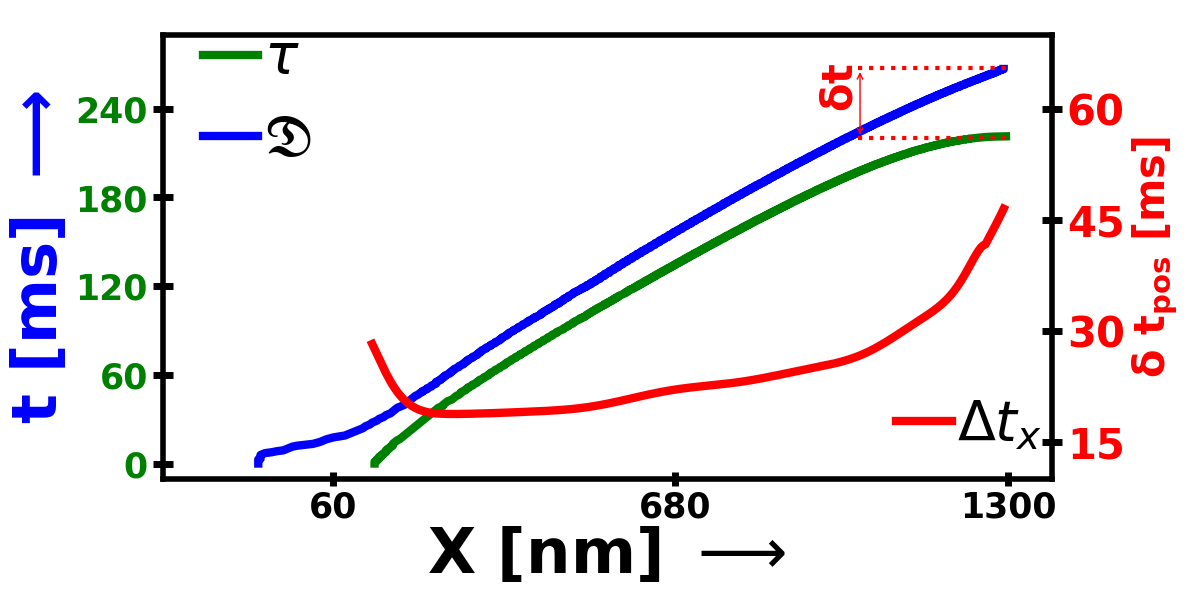

In [22]:
t_step = 1137


fig, (ax1) = plt.subplots(1, 1, figsize=(12,6), frameon=False)
ax1.set_facecolor((0, 0, 0, 0))

if t_step>=T_end_dt3:
    ax1.plot(Lead_Temp3[1:T_end_dt3], time_lead_lag3[1:T_end_dt3], marker='o', c='green',markersize=1, linewidth=6, label =r'$\tau$')
else:
    ax1.plot(Lead_Temp3[1:t_step], time_lead_lag3[1:t_step], marker='o', c='green',markersize=1, linewidth=6, label =r'$\tau$')
    
ax1.plot(Lead_LIQ3[1:t_step], time_lead_lag3[1:t_step], marker='.', c='blue',markersize=1,linewidth=6, label =r'$\mathfrak{D}$')

ax1.set_ylabel("t [ms] $\mathbf{\longrightarrow}$",  weight = 'bold', size=45,  color='blue')
ax1.set_xlabel(r"X [nm] $\longrightarrow$", weight='bold', size=45, color='k', labelpad=1, ha='center')
ax1.set_xticks([75, 225, 371], labels=['60', '680', '1300'], size=25, color='k', weight='bold')
ax1.yaxis.set_tick_params(labelcolor='green', labelsize=25, pad=3,)
for label in ax1.get_yticklabels(): label.set_fontweight('bold')

if t_step>=common_position3:
    ax1.hlines(y=phase_fit_real_time3(Lead_LIQ3[t_step]), xmax=Lead_LIQ3[t_step], xmin=Lead_LIQ3[t_step]-65, linewidth=3, linestyle=':', color='red')
    if t_step>=T_slope0_dt3:
        ax1.hlines(y=temp_fit_real_time3(Lead_LIQ3[T_slope0_dt3]), xmax=Lead_LIQ3[t_step], xmin=Lead_LIQ3[t_step]-65,  linewidth=3, linestyle=':', color='red')
        # ax1.vlines(x=Lead_LIQ3[t_step],  ymin=temp_fit_real_time3(Lead_LIQ3[T_slope0_dt3])+1, ymax=phase_fit_real_time3(Lead_LIQ3[t_step]), linestyle='-', color='k', linewidth=2)
        ax1.text(x=Lead_LIQ3[t_step]-82, y= np.mean([phase_fit_real_time3(Lead_LIQ3[t_step]), temp_fit_real_time3(Lead_LIQ3[T_slope0_dt3])]), s=r"$\mathbf{\delta}$t", color='red', fontsize=30, rotation=90, weight='bold')
        ax1.annotate(text=' ', xy=(Lead_LIQ3[t_step]-65+1,temp_fit_real_time3(Lead_LIQ3[T_slope0_dt3])), xytext=(Lead_LIQ3[t_step]-65, phase_fit_real_time3(Lead_LIQ3[t_step])+3), arrowprops=dict(arrowstyle='<->', color='red'), )
    else:
        ax1.hlines(y=temp_fit_real_time3(Lead_LIQ3[t_step]), xmax=Lead_LIQ3[t_step], xmin=Lead_LIQ3[t_step]-65, linewidth=3, linestyle=':', color='red')
        # ax1.vlines(x=Lead_LIQ3[t_step],  ymin=temp_fit_real_time3(Lead_LIQ3[t_step])+1, ymax=phase_fit_real_time3(Lead_LIQ3[t_step]), linestyle='-', color='k', linewidth=2)
        ax1.text(x=Lead_LIQ3[t_step]-82, y=np.mean([phase_fit_real_time3(Lead_LIQ3[t_step]), temp_fit_real_time3(Lead_LIQ3[t_step])]), s=r"$\mathbf{\delta}$t", color='red', fontsize=30, rotation=90, weight='bold')
        ax1.annotate(text=' ', xy=(Lead_LIQ3[t_step]-65+1, temp_fit_real_time3(Lead_LIQ3[t_step])), xytext=(Lead_LIQ3[t_step]-65,phase_fit_real_time3(Lead_LIQ3[t_step])+3), arrowprops=dict(arrowstyle='<->', color='red'))

ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_ylim([-10,290])
ax1.set_xlim([00,380])
legend_1 = ax1.legend(loc=(0.02,0.65), prop={'weight':'bold', 'size':'40',}, handletextpad=0.1, handlelength=1.0,   frameon=False).get_frame().set_facecolor('none')

ax2 = ax1.twinx()
if t_step>common_position3:
    ax2.plot(Lead_LIQ3[common_position3:t_step],lag_time3[common_position3:t_step],   c='red', linewidth=6, label =r'$\Delta t_{x}$') # positional_timelag

legend_2 = ax2.legend(loc=(0.80,0.01), prop={'weight':'bold', 'size':'40',}, handletextpad=0.1, handlelength=1.0, frameon=False).get_frame().set_facecolor('none')

ax2.set_ylabel("$\mathbf{\delta}$ t$\mathbf{_{pos}}$ [ms]",  weight = 'bold', size=30, color='red')
ax2.yaxis.set_tick_params(labelcolor='red', labelsize=30)  
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
for label in ax2.get_yticklabels(): label.set_fontweight('bold')
ax2.set_ylim([10,70])
ax2.set_xlim([0,390])

ax1.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax2.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax1.tick_params(axis='x', direction='inout', which='both', length=10, width=5)

ax1.spines[:].set_linewidth(4)

plt.tight_layout()

# plt.savefig('for_manuscript/T_u/F7/jpg/m3.jpg', bbox_inches='tight')
# plt.savefig('for_manuscript/T_u/F7/m3.png', bbox_inches='tight', dpi=800)

plt.show()

##### t=20ms

/tmp/ipykernel_21354/3662228036.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


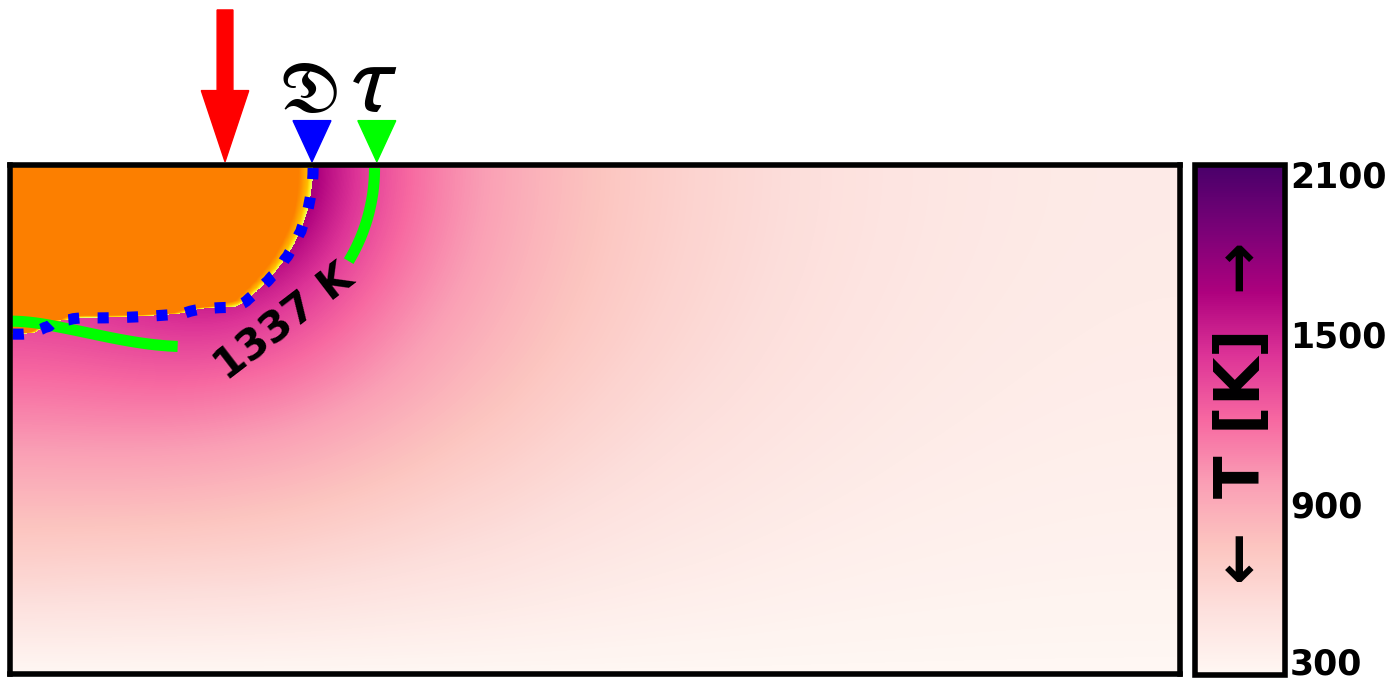

In [182]:
t_step = 44
if t_step>=end_step3:
    t_step=end_step3-1
    
scan_speed = '4' # nano meter per micro sec ==> 5e-4 * t (1e-7m / 1e-9s)
irradiance = r"150 $\mathbf{\frac{kW}{cm^2}}$"

max_temp = round(temp3[:,:,t_step].max())
max_temp_pos = np.unravel_index(np.argmax(temp3[:,:,t_step]), temp3[:,:,t_step].shape)

####################################################
x = np.arange(time_steps3-1)

fig, ax1 = plt.subplots(1, 1, figsize=[12, 8], frameon=False) #figsize=[8, 10])
hmap1 = ax1.imshow(temp3[:,:,t_step], cmap='RdPu', interpolation='bilinear')
ax1.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

############### Arrow #########################
ax1.arrow(max_temp_pos[1], -50, 0, 48,  width = 5, color='red', length_includes_head=True, clip_on=False)

ax1.set_ylim(160, -1)
ax1.set_xlim(0,370)
# ##############################################

################## Meltpool and Isotherm ################
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
meltpool_1 = ax1.imshow(Au_LIQ3[:,:,t_step], cmap=cmap, vmin=0.85, vmax=0.89, interpolation='bilinear')

ax1.arrow(Lead_Temp3[t_step]+1, -15, 0, 13,  width = 10, head_width=12, head_length=13, color='lime', length_includes_head=True, clip_on=False)
ax1.text(Lead_Temp3[t_step]-8, -18, s=r'$\mathfrak{\tau}$', fontsize=70, weight = 'bold')
ax1.arrow(Lead_LIQ3[t_step]+0.5, -15, 0, 13,  width = 10, head_width=12,  head_length=13,  color='b', length_includes_head=True, clip_on=False)
ax1.text(Lead_LIQ3[t_step]-10, -18, s=r'$\mathfrak{D}$', fontsize=50, weight = 'bold')

################# Contour ##################
contour_levels = [1337]
contour = plt.contour(temp3[:, :, t_step], levels=contour_levels, colors='lime', linewidths=8,)
clabels = plt.clabel(contour, inline=True, fontsize=30, colors='k', fmt=' %1.0f K ')
for label in clabels: label.set_fontweight('bold')

contour_level_LIQ = [0.85]
contour_LIQ = plt.contour(Au_LIQ3[:, :, t_step], levels=contour_level_LIQ, colors='blue', linestyles=':', linewidths=8,)

############## Color Bar ###########
ax2 = fig.add_axes([1.0, 0.17, 0.075, 0.637])
ax2.tick_params(axis='both', labelcolor='black', labelsize=1, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
cbar = fig.colorbar(hmap1, cax=ax2, orientation='vertical')
cbar.ax.tick_params(labelsize=25,direction='in', length=0) 
cbar.set_ticks([300+50, 900, 1500, max_temp-30],labels=['300', '900', '1500',  f'{max_temp+5}'], weight='bold') 
cbar.set_label(r'$\mathbf{{\leftarrow}}$ T $\mathbf{[K]}$ ${\mathbf{\rightarrow}}$', color='k',  labelpad=-125, fontsize=45, rotation=90, weight='bold')
ax1.spines[:].set_linewidth(4)
ax2.spines[:].set_linewidth(4)


plt.tight_layout()

# plt.savefig('for_manuscript/T_u/F7/jpg/m3_150_4_30_L_10_27.jpg', bbox_inches='tight')
# plt.savefig('for_manuscript/T_u/F7/m3_150_4_30_L_10_27.png', bbox_inches='tight', dpi=800)
plt.show()

##### t=175ms

/tmp/ipykernel_21354/1673559527.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


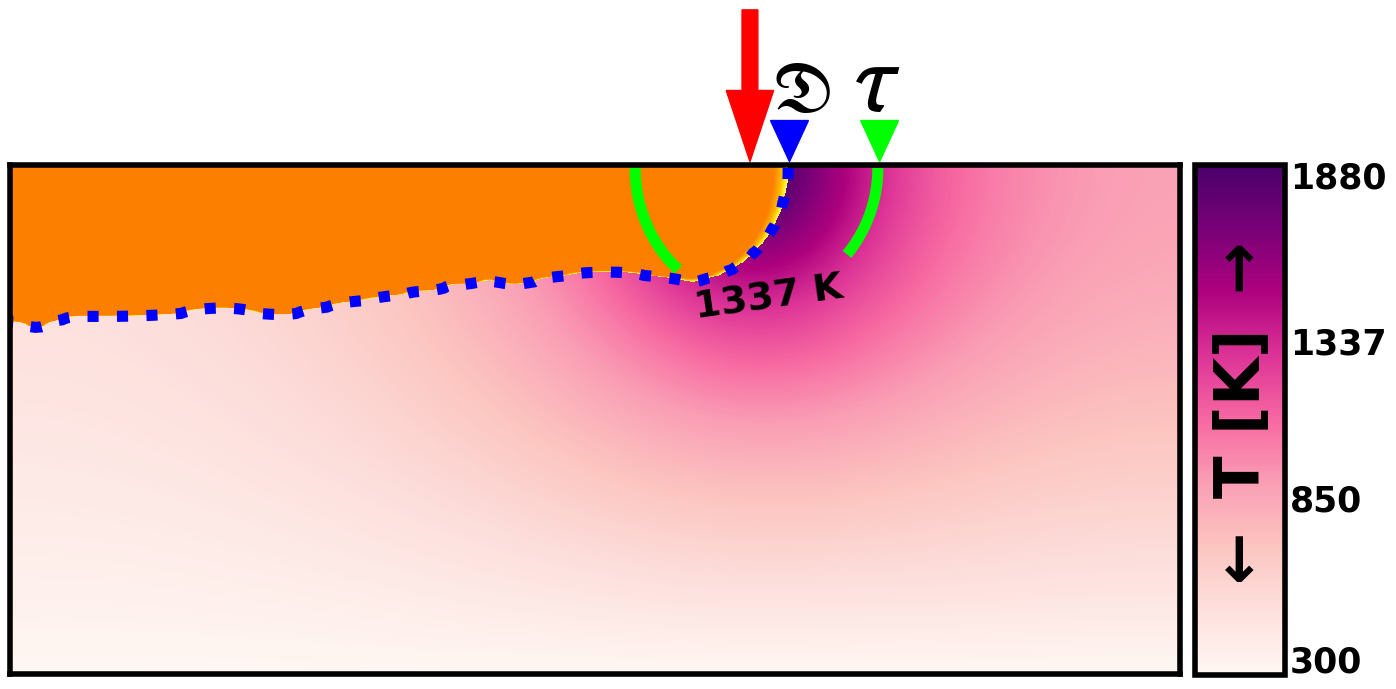

In [180]:
t_step = 549
if t_step>=end_step3:
    t_step=end_step3-1
    
scan_speed = '4' # nano meter per micro sec ==> 5e-4 * t (1e-7m / 1e-9s)
irradiance = r"150 $\mathbf{\frac{kW}{cm^2}}$"

max_temp = round(temp3[:,:,t_step].max())
max_temp_pos = np.unravel_index(np.argmax(temp3[:,:,t_step]), temp3[:,:,t_step].shape)

####################################################
x = np.arange(time_steps3-1)

fig, ax1 = plt.subplots(1, 1, figsize=[12, 8], frameon=False) #figsize=[8, 10])
hmap1 = ax1.imshow(temp3[:,:,t_step], cmap='RdPu', interpolation='bilinear')
ax1.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax1.arrow(max_temp_pos[1], -50, 0, 48,  width = 5, color='red', length_includes_head=True, clip_on=False)

ax1.set_ylim(160, -1)
ax1.set_xlim(0,370)
# ##############################################

################## Meltpool and Isotherm ################
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
meltpool_1 = ax1.imshow(Au_LIQ3[:,:,t_step], cmap=cmap, vmin=0.85, vmax=0.89, interpolation='bilinear')

ax1.arrow(Lead_Temp3[t_step]+1, -15, 0, 13,  width = 10, head_width=12, head_length=13, color='lime', length_includes_head=True, clip_on=False)
ax1.text(Lead_Temp3[t_step]-8, -18, s=r'$\mathfrak{\tau}$', fontsize=70, weight = 'bold')
ax1.arrow(Lead_LIQ3[t_step]+0.5, -15, 0, 13,  width = 10, head_width=12,  head_length=13,  color='b', length_includes_head=True, clip_on=False)
ax1.text(Lead_LIQ3[t_step]-5, -18, s=r'$\mathfrak{D}$', fontsize=50, weight = 'bold')

################# Contour ##################
contour_levels = [1337]
contour = plt.contour(temp3[:, :, t_step], levels=contour_levels, colors='lime', linewidths=8,)
clabels = plt.clabel(contour, inline=True, fontsize=27.5, colors='k', fmt=' %1.0f K ')
for label in clabels: label.set_fontweight('bold')

contour_level_LIQ = [0.85]
contour_LIQ = plt.contour(Au_LIQ3[:, :, t_step], levels=contour_level_LIQ, colors='blue', linestyles=':', linewidths=8,)

############## Color Bar ###########
ax2 = fig.add_axes([1.0, 0.17, 0.075, 0.637])
ax2.tick_params(axis='both', labelcolor='black', labelsize=1, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
cbar = fig.colorbar(hmap1, cax=ax2, orientation='vertical')
cbar.ax.tick_params(labelsize=25,direction='in', length=0) 
cbar.set_ticks([300+50, 850, 1337, max_temp-30],labels=['300', '850', '1337',  f'{max_temp-1}'], weight='bold') 
cbar.set_label(r'$\mathbf{{\leftarrow}}$ T $\mathbf{[K]}$ ${\mathbf{\rightarrow}}$', color='k',  labelpad=-125, fontsize=45, rotation=90, weight='bold')
ax1.spines[:].set_linewidth(4)
ax2.spines[:].set_linewidth(4)


plt.tight_layout()

# plt.savefig('for_manuscript/T_u/F7/jpg/m3_150_4_175_L_9_74.jpg', bbox_inches='tight')
# plt.savefig('for_manuscript/T_u/F7/m3_150_4_175_L_9_74.png', bbox_inches='tight', dpi=800)
plt.show()

#### Model 4
#### I 134.6 v 4

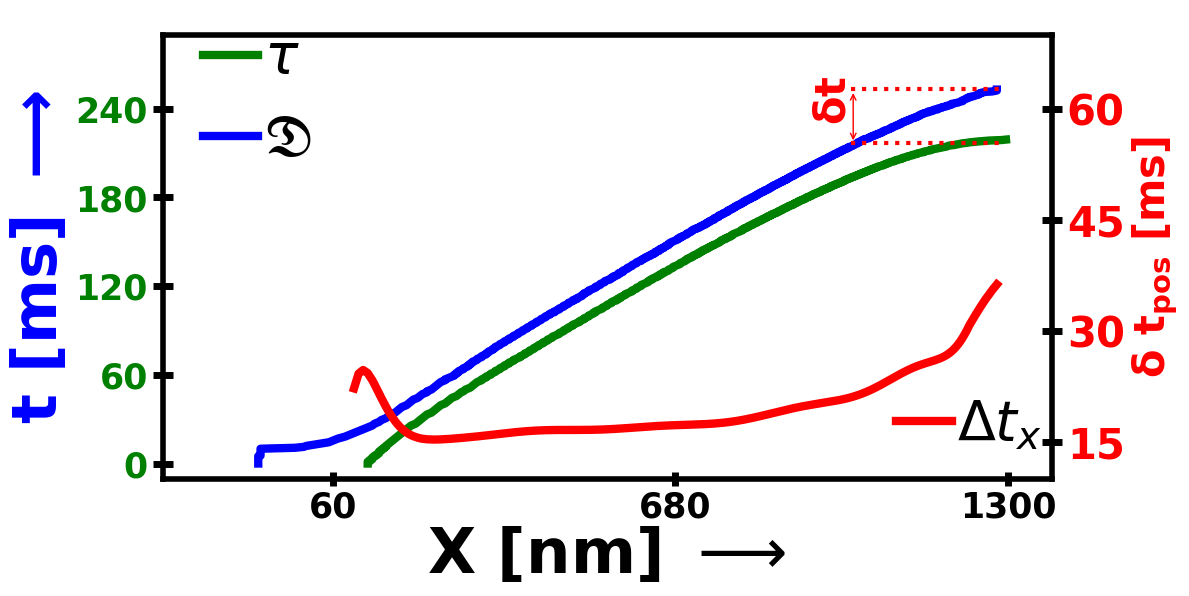

In [28]:
t_step = 545


fig, (ax1) = plt.subplots(1, 1, figsize=(12,6), frameon=False)
ax1.set_facecolor((0, 0, 0, 0))

if t_step>=T_end_dt4:
    ax1.plot(Lead_Temp4[1:T_end_dt4], time_lead_lag4[1:T_end_dt4], marker='o', c='green',markersize=1, linewidth=6, label =r'$\tau$')
else:
    ax1.plot(Lead_Temp4[1:t_step], time_lead_lag4[1:t_step], marker='o', c='green',markersize=1, linewidth=6, label =r'$\tau$')
    
ax1.plot(Lead_LIQ4[1:t_step], time_lead_lag4[1:t_step], marker='.', c='blue',markersize=1,linewidth=6, label =r'$\mathfrak{D}$')

ax1.set_ylabel("t [ms] $\mathbf{\longrightarrow}$",  weight = 'bold', size=45,  color='blue')
ax1.set_xlabel(r"X [nm] $\longrightarrow$", weight='bold', size=45, color='k', labelpad=1, ha='center')
ax1.set_xticks([75, 225, 371], labels=['60', '680', '1300'], size=25, color='k', weight='bold')
ax1.yaxis.set_tick_params(labelcolor='green', labelsize=25, pad=3,)
for label in ax1.get_yticklabels(): label.set_fontweight('bold')

if t_step>=common_position4:
    ax1.hlines(y=phase_fit_real_time4(Lead_LIQ4[t_step]), xmax=Lead_LIQ4[t_step], xmin=Lead_LIQ4[t_step]-65, linewidth=3, linestyle=':', color='red')
    if t_step>=T_slope0_dt4:
        ax1.hlines(y=temp_fit_real_time4(Lead_LIQ4[T_slope0_dt4]), xmax=Lead_LIQ4[t_step], xmin=Lead_LIQ4[t_step]-65,  linewidth=3, linestyle=':', color='red')
        # ax1.vlines(x=Lead_LIQ4[t_step],  ymin=temp_fit_real_time4(Lead_LIQ4[T_slope0_dt4])+1, ymax=phase_fit_real_time4(Lead_LIQ4[t_step]), linestyle='-', color='k', linewidth=2)
        ax1.text(x=Lead_LIQ4[t_step]-82, y= np.mean([phase_fit_real_time4(Lead_LIQ4[t_step]), temp_fit_real_time4(Lead_LIQ4[T_slope0_dt4])]), s=r"$\mathbf{\delta}$t", color='red', fontsize=30, rotation=90, weight='bold')
        ax1.annotate(text=' ', xy=(Lead_LIQ4[t_step]-65+1,temp_fit_real_time4(Lead_LIQ4[T_slope0_dt4])), xytext=(Lead_LIQ4[t_step]-65, phase_fit_real_time4(Lead_LIQ4[t_step])+3), arrowprops=dict(arrowstyle='<->', color='red'), )
    else:
        ax1.hlines(y=temp_fit_real_time4(Lead_LIQ4[t_step]), xmax=Lead_LIQ4[t_step], xmin=Lead_LIQ4[t_step]-65, linewidth=3, linestyle=':', color='red')
        # ax1.vlines(x=Lead_LIQ4[t_step],  ymin=temp_fit_real_time4(Lead_LIQ4[t_step])+1, ymax=phase_fit_real_time4(Lead_LIQ4[t_step]), linestyle='-', color='k', linewidth=2)
        ax1.text(x=Lead_LIQ4[t_step]-82, y=np.mean([phase_fit_real_time4(Lead_LIQ4[t_step]), temp_fit_real_time4(Lead_LIQ4[t_step])]), s=r"$\mathbf{\delta}$t", color='red', fontsize=30, rotation=90, weight='bold')
        ax1.annotate(text=' ', xy=(Lead_LIQ4[t_step]-65+1, temp_fit_real_time4(Lead_LIQ4[t_step])), xytext=(Lead_LIQ4[t_step]-65,phase_fit_real_time4(Lead_LIQ4[t_step])+3), arrowprops=dict(arrowstyle='<->', color='red'))

ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_ylim([-10,290])
ax1.set_xlim([00,380])
legend_1 = ax1.legend(loc=(0.02,0.65), prop={'weight':'bold', 'size':'40',}, handletextpad=0.1, handlelength=1.0,   frameon=False).get_frame().set_facecolor('none')

ax2 = ax1.twinx()
if t_step>common_position4:
    ax2.plot(Lead_LIQ4[common_position4:t_step],lag_time4[common_position4:t_step],   c='red', linewidth=6, label =r'$\Delta t_{x}$') # positional_timelag

legend_2 = ax2.legend(loc=(0.80,0.01), prop={'weight':'bold', 'size':'40',}, handletextpad=0.1, handlelength=1.0, frameon=False).get_frame().set_facecolor('none')

ax2.set_ylabel("$\mathbf{\delta}$ t$\mathbf{_{pos}}$ [ms]",  weight = 'bold', size=30, color='red')
ax2.yaxis.set_tick_params(labelcolor='red', labelsize=30)  
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
for label in ax2.get_yticklabels(): label.set_fontweight('bold')
ax2.set_ylim([10,70])
ax2.set_xlim([0,390])

ax1.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax2.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax1.tick_params(axis='x', direction='inout', which='both', length=10, width=5)

ax1.spines[:].set_linewidth(4)

plt.tight_layout()

# plt.savefig('for_manuscript/T_u/F7/jpg/m4.jpg', bbox_inches='tight')
# plt.savefig('for_manuscript/T_u/F7/m4.png', bbox_inches='tight', dpi=800)

plt.show()

##### t=20ms

/tmp/ipykernel_21354/1456736497.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


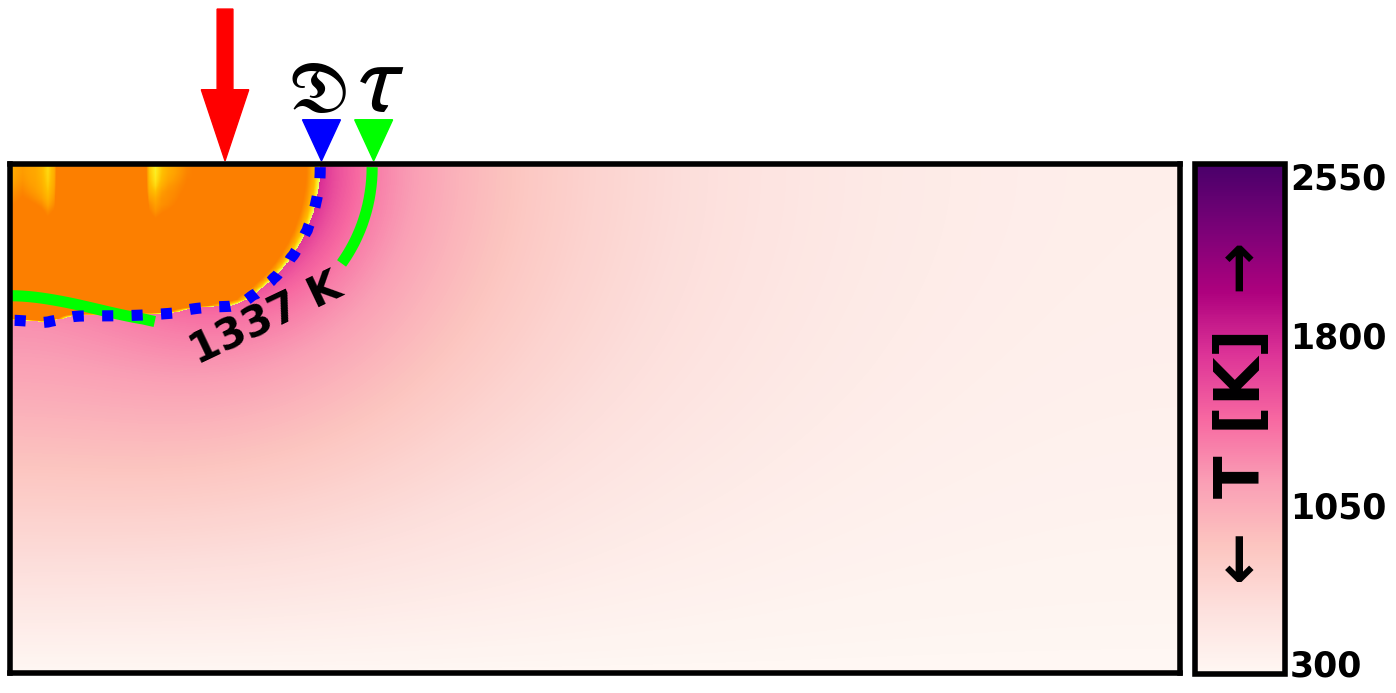

In [163]:
t_step = 44
if t_step>=end_step4:
    t_step=end_step4-1
    
scan_speed = '4' # nano meter per micro sec ==> 5e-4 * t (1e-7m / 1e-9s)
irradiance = r"134.6 $\mathbf{\frac{kW}{cm^2}}$"

max_temp = round(temp4[:,:,t_step].max())
max_temp_pos = np.unravel_index(np.argmax(temp4[:,:,t_step]), temp4[:,:,t_step].shape)

####################################################
x = np.arange(time_steps4-1)

fig, ax1 = plt.subplots(1, 1, figsize=[12, 8], frameon=False) #figsize=[8, 10])
hmap1 = ax1.imshow(temp4[:,:,t_step], cmap='RdPu', interpolation='bilinear')
ax1.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

############### Arrow #########################
ax1.arrow(max_temp_pos[1], -50, 0, 48,  width = 5, color='red', length_includes_head=True, clip_on=False)

ax1.set_ylim(160, -1)
ax1.set_xlim(0,370)
# ##############################################

################## Meltpool and Isotherm ################
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
meltpool_1 = ax1.imshow(Au_LIQ4[:,:,t_step], cmap=cmap, vmin=0.85, vmax=0.89, interpolation='bilinear')

ax1.arrow(Lead_Temp4[t_step]+1, -15, 0, 13,  width = 10, head_width=12, head_length=13, color='lime', length_includes_head=True, clip_on=False)
ax1.text(Lead_Temp4[t_step]-5, -18, s=r'$\mathfrak{\tau}$', fontsize=70, weight = 'bold')
ax1.arrow(Lead_LIQ4[t_step]+0.5, -15, 0, 13,  width = 10, head_width=12,  head_length=13,  color='b', length_includes_head=True, clip_on=False)
ax1.text(Lead_LIQ4[t_step]-10, -18, s=r'$\mathfrak{D}$', fontsize=50, weight = 'bold')

################# Contour ##################
contour_levels = [1337]
contour = plt.contour(temp4[:, :, t_step], levels=contour_levels, colors='lime', linewidths=8,)
clabels = plt.clabel(contour, inline=True, fontsize=30, colors='k', fmt=' %1.0f K ')
for label in clabels: label.set_fontweight('bold')

contour_level_LIQ = [0.85]
contour_LIQ = plt.contour(Au_LIQ4[:, :, t_step], levels=contour_level_LIQ, colors='blue', linestyles=':', linewidths=8,)

############## Color Bar ###########
ax2 = fig.add_axes([1.0, 0.17, 0.075, 0.637])
ax2.tick_params(axis='both', labelcolor='black', labelsize=1, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
cbar = fig.colorbar(hmap1, cax=ax2, orientation='vertical')
cbar.ax.tick_params(labelsize=25,direction='in', length=0) 
cbar.set_ticks([300+50, 1050, 1800, max_temp-50],labels=['300', '1050', '1800',  f'{max_temp-3}'], weight='bold') 
cbar.set_label(r'$\mathbf{{\leftarrow}}$ T $\mathbf{[K]}$ ${\mathbf{\rightarrow}}$', color='k',  labelpad=-125, fontsize=45, rotation=90, weight='bold')
ax1.spines[:].set_linewidth(4)
ax2.spines[:].set_linewidth(4)


plt.tight_layout()

# plt.savefig('for_manuscript/T_u/F7/jpg/m4_134_4_30_L10_35.jpg', bbox_inches='tight')
# plt.savefig('for_manuscript/T_u/F7/m4_134_4_30_L10_35.png', bbox_inches='tight', dpi=800)
plt.show()

##### t=175ms

/tmp/ipykernel_21354/1489686781.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


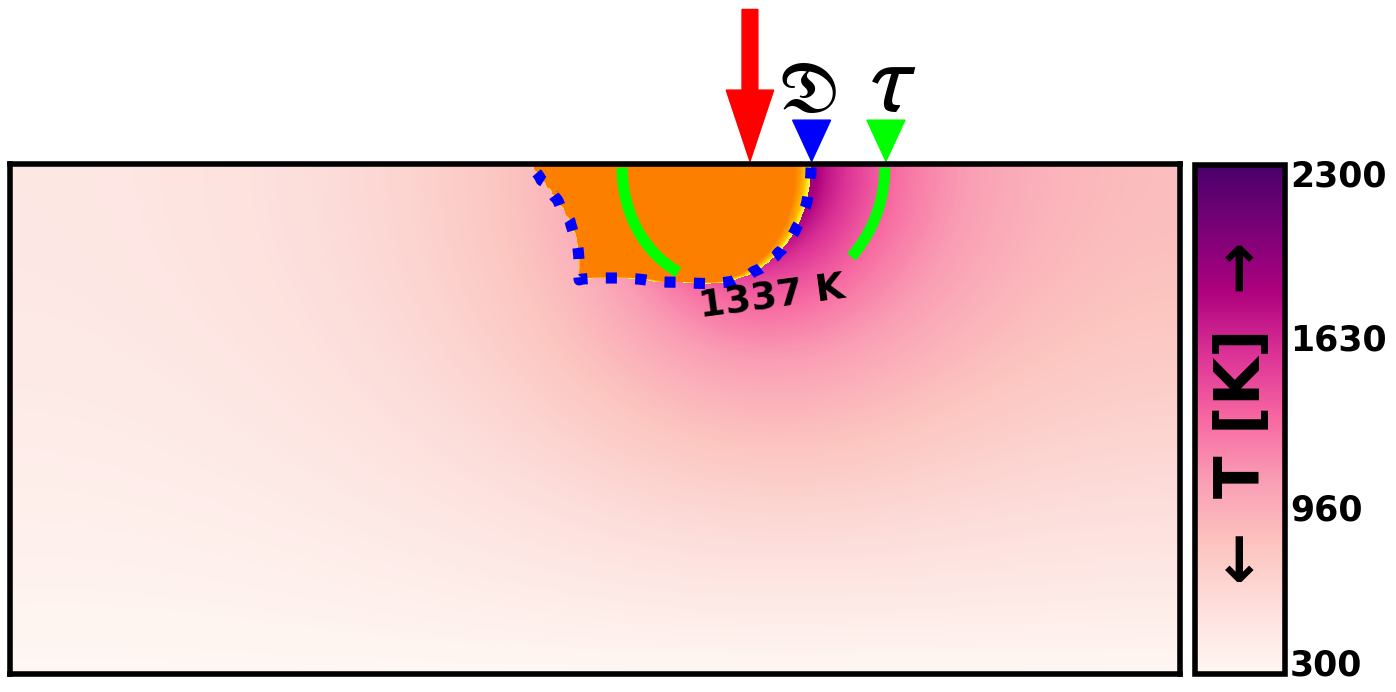

In [179]:
t_step = 312
if t_step>=end_step4:
    t_step=end_step4-1
    
scan_speed = '4' # nano meter per micro sec ==> 5e-4 * t (1e-7m / 1e-9s)
irradiance = r"134.6 $\mathbf{\frac{kW}{cm^2}}$"

max_temp = round(temp4[:,:,t_step].max())
max_temp_pos = np.unravel_index(np.argmax(temp4[:,:,t_step]), temp4[:,:,t_step].shape)

####################################################
x = np.arange(time_steps4-1)

fig, ax1 = plt.subplots(1, 1, figsize=[12, 8], frameon=False) #figsize=[8, 10])
hmap1 = ax1.imshow(temp4[:,:,t_step], cmap='RdPu', interpolation='bilinear')
ax1.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

############### Arrow #########################
ax1.arrow(max_temp_pos[1], -50, 0, 48,  width = 5, color='red', length_includes_head=True, clip_on=False)

ax1.set_ylim(160, -1)
ax1.set_xlim(0,370)
# ##############################################

################## Meltpool and Isotherm ################
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
meltpool_1 = ax1.imshow(Au_LIQ4[:,:,t_step], cmap=cmap, vmin=0.85, vmax=0.89, interpolation='bilinear')

ax1.arrow(Lead_Temp4[t_step]+1, -15, 0, 13,  width = 10, head_width=12, head_length=13, color='lime', length_includes_head=True, clip_on=False)
ax1.text(Lead_Temp4[t_step]-5, -18, s=r'$\mathfrak{\tau}$', fontsize=70, weight = 'bold')
ax1.arrow(Lead_LIQ4[t_step]+0.5, -15, 0, 13,  width = 10, head_width=12,  head_length=13,  color='b', length_includes_head=True, clip_on=False)
ax1.text(Lead_LIQ4[t_step]-10, -18, s=r'$\mathfrak{D}$', fontsize=50, weight = 'bold')

################# Contour ##################
contour_levels = [1337]
contour = plt.contour(temp4[:, :, t_step], levels=contour_levels, colors='lime', linewidths=8,)
clabels = plt.clabel(contour, inline=True, fontsize=27, colors='k', fmt=' %1.0f K ')
for label in clabels: label.set_fontweight('bold')

contour_level_LIQ = [0.85]
contour_LIQ = plt.contour(Au_LIQ4[:, :, t_step], levels=contour_level_LIQ, colors='blue', linestyles=':', linewidths=8,)

############## Color Bar ###########
ax2 = fig.add_axes([1.0, 0.17, 0.075, 0.637]) # [left, bottom, width, height]
ax2.tick_params(axis='both', labelcolor='black', labelsize=1, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
cbar = fig.colorbar(hmap1, cax=ax2, orientation='vertical')
cbar.ax.tick_params(labelsize=25,direction='in', length=0) 
cbar.set_ticks([300+50, 960, 1630, max_temp-30],labels=['300', '960', '1630',  f'{max_temp-4}'], weight='bold') 
cbar.set_label(r'$\mathbf{{\leftarrow}}$ T $\mathbf{[K]}$ ${\mathbf{\rightarrow}}$', color='k',  labelpad=-125, fontsize=45, rotation=90, weight='bold')
ax1.spines[:].set_linewidth(4)
ax2.spines[:].set_linewidth(4)


plt.tight_layout()

# plt.savefig('for_manuscript/T_u/F7/jpg/m4_134_4_175_L_9_88.jpg', bbox_inches='tight')
# plt.savefig('for_manuscript/T_u/F7/m4_134_4_175_L_9_88.png', bbox_inches='tight', dpi=800)
plt.show()

### Leading Front